### Singlephotoelectron mini analysis: windows identification

The plugIn for getting the LED data can be find here: https://github.com/XENONnT/straxen/blob/led_plugin/straxen/plugins/led_calibration.py.

The motivation for this analysis is to estimate the SPE acceptance using low-intensity LED runs.

Before using the plugin, the LED windwos and the noise window have to be indentificated.

In [1]:
%run '/home/gvolta/XENONnT/Initialization/Initialization_for_SPE.py'

0.0.8


In [2]:
st.data_info('led_calibration')

Field name Data type                                           Comment
0            area     int32              Area averaged in integration windows
1    amplitudeLED     int32                           Amplitude in LED window
2  amplitudeNOISE     int32                       Amplitude in off LED window
3         channel     int16                                           Channel
4            time     int64  Start time of the interval (ns since unix epoch)
5              dt     int16                             Time resolution in ns
6          length     int32                 Length of the interval in samples

In [3]:
st.show_config('led_calibration')

option          default    current          applies_to  \
0          LED_window       (125, 250)  <OMITTED>  (led_calibration,)   
1        noise_window       (350, 475)  <OMITTED>  (led_calibration,)   
2         light_level         (0, 248)  <OMITTED>  (led_calibration,)   
3         pax_raw_dir  /data/xenon/raw  <OMITTED>      (raw_records,)   
4     stop_after_zips                0  <OMITTED>      (raw_records,)   
5    events_per_chunk               50  <OMITTED>      (raw_records,)   
6  samples_per_record              110  <OMITTED>      (raw_records,)   

                                                                                               help  
0                                    Window (samples) where we expect the signal in LED calibration  
1                                                            Window (samples) to analysis the noise  
2  Three different light level for XENON1T: (0,36), (37,126), (127,248). Defalt value: all the PMTs  
3                                                                   Directory with raw pax datasets  
4                                                        Convert only this many zip files. 0 = all.  
5                                                               Number of events to yield per chunk  
6                                                                      Number of samples per record

In [4]:
runs = st.select_runs(run_mode='LED*')
runs

Checking data availability: 100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


end             mode         name  number  \
121 2018-02-19 10:00:16+00:00  LED_3mus_stable  180219_0952   16979   
122 2018-02-19 10:09:44+00:00  LED_3mus_stable  180219_1001   16980   
123 2018-02-19 10:19:09+00:00  LED_3mus_stable  180219_1011   16981   
124 2018-02-19 10:29:22+00:00  LED_3mus_stable  180219_1021   16982   
125 2018-02-19 10:39:05+00:00  LED_3mus_stable  180219_1030   16983   
126 2018-02-19 10:58:02+00:00  LED_3mus_stable  180219_1049   16985   
127 2018-02-19 11:07:24+00:00  LED_3mus_stable  180219_1059   16986   
128 2018-02-19 11:15:31+00:00  LED_7mus_stable  180219_1110   16987   
129 2018-02-19 11:31:50+00:00  LED_7mus_stable  180219_1116   16988   

     reader.ini.name                     start  \
121  LED_3mus_stable 2018-02-19 09:52:13+00:00   
122  LED_3mus_stable 2018-02-19 10:01:41+00:00   
123  LED_3mus_stable 2018-02-19 10:11:06+00:00   
124  LED_3mus_stable 2018-02-19 10:21:18+00:00   
125  LED_3mus_stable 2018-02-19 10:31:02+00:00   
126  LED_3mus_stable 2018-02-19 10:50:00+00:00   
127  LED_3mus_stable 2018-02-19 10:59:21+00:00   
128  LED_7mus_stable 2018-02-19 11:10:28+00:00   
129  LED_7mus_stable 2018-02-19 11:16:48+00:00   

                                   tags  trigger.events_built  \
121   gain_step0,_sciencerun2_candidate              196157.0   
122   gain_step1,_sciencerun2_candidate              196207.0   
123   gain_step2,_sciencerun2_candidate              194686.0   
124   gain_step3,_sciencerun2_candidate              196373.0   
125   gain_step4,_sciencerun2_candidate              195938.0   
126  spe_topbulk,_sciencerun2_candidate              194366.0   
127  spe_topring,_sciencerun2_candidate              193050.0   
128   Afterpulse,_sciencerun2_candidate               46116.0   
129   Afterpulse,_sciencerun2_candidate              137431.0   

     records_available  raw_records_available  events_available  \
121              False                   True             False   
122              False                   True             False   
123              False                   True             False   
124              False                   True             False   
125              False                   True             False   
126              False                   True             False   
127              False                   True             False   
128              False                   True             False   
129              False                   True             False   

     event_info_available  peaks_available  
121                 False            False  
122                 False            False  
123                 False            False  
124                 False            False  
125                 False            False  
126                 False            False  
127                 False            False  
128                 False            False  
129                 False            False

#### Determining LED and noise window:
- Identify the rough amplitude range corresponding to a single photoelectron;
- Find the time window in which we have an excess of sample in this amplitude range;
- Define the noise window far from the LED window.

In [5]:
# The LED and the noise window are computed
# using the raw record. The the straxen.config
# of LEDCalibration pulgin will be modified

run_id = '180219_1049'
data_rr = st.get_array(run_id, 'raw_records', seconds_range=(0,20))

In [6]:
def gaus(x, a, mu, sig):
    return a*np.exp(-0.5*(x-mu)**2/sig**2)

In [14]:
datatype = [('pmt', np.int16),
            ('Amplitude', np.float32),
            ('Sample of Amplitude', np.float32)]

Data = np.zeros((len(data_rr)), dtype = datatype)

for i in range(len(data_rr)):
    Data[i]['pmt'] = data_rr['channel'][i]
    Data[i]['Amplitude'] = np.max(data_rr['data'][i])
    Data[i]['Sample of Amplitude'] = np.argmax(data_rr['data'][i])

  0%|          | 0/248 [00:00<?, ?it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:155: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  0%|          | 1/248 [00:00<01:25,  2.90it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:733: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  8%|▊         | 20/248 [00:04<00:52,  4.36it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/mat

mean:  162.95775 sigma:  50.318783 window LED:  [137, 188]


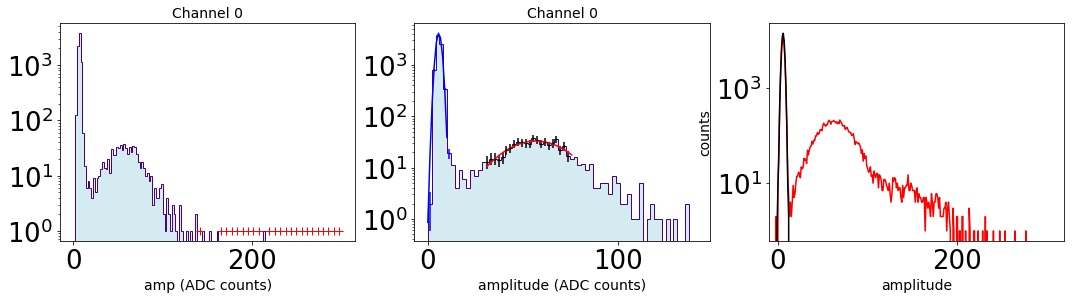

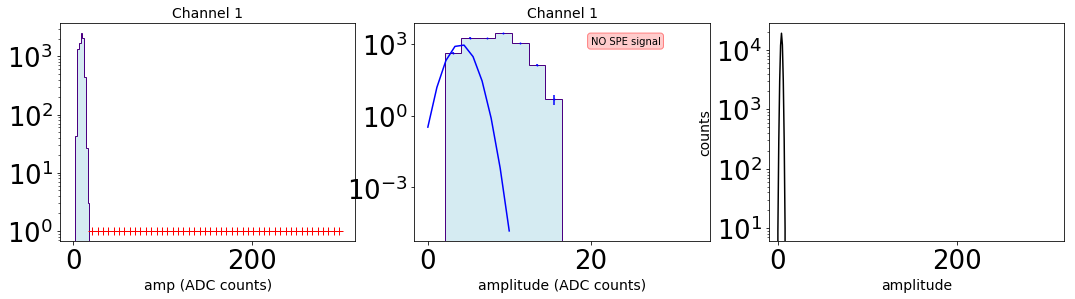

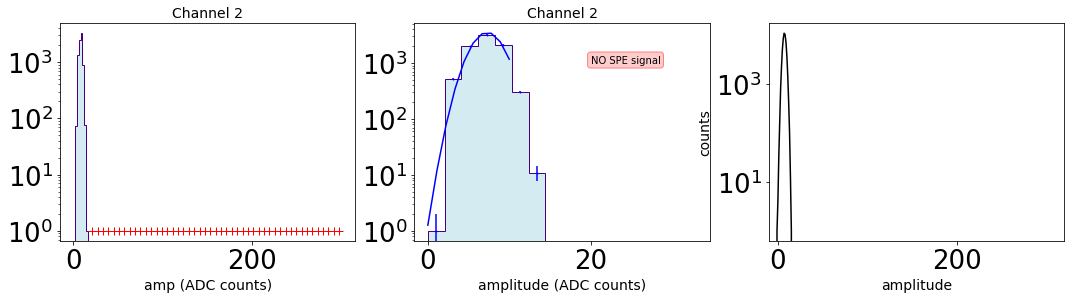

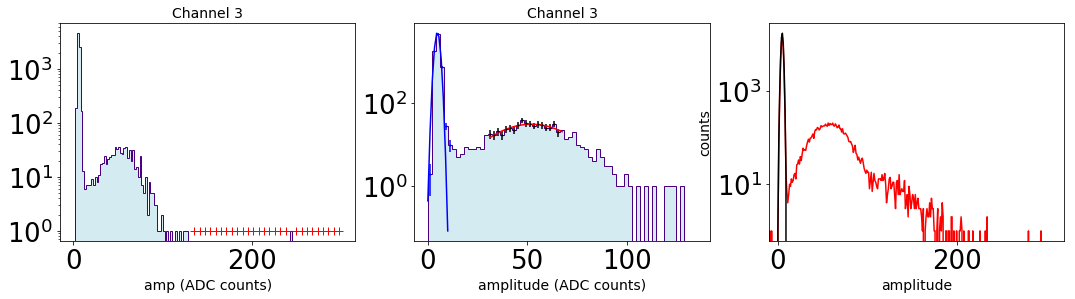

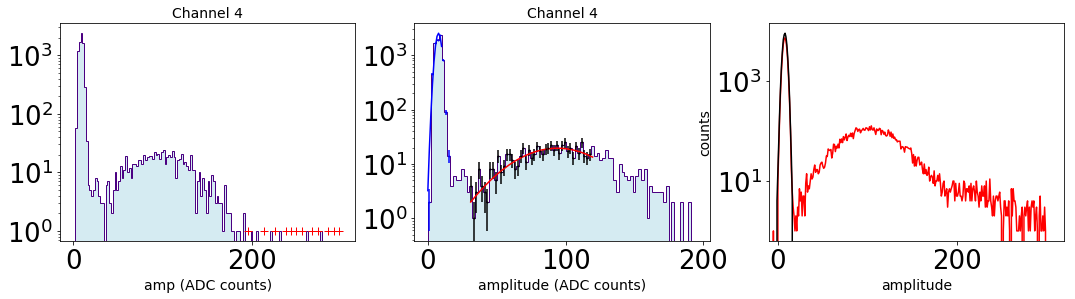

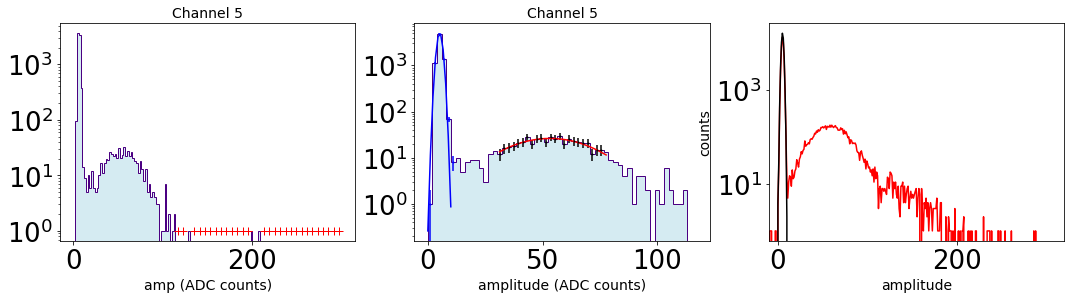

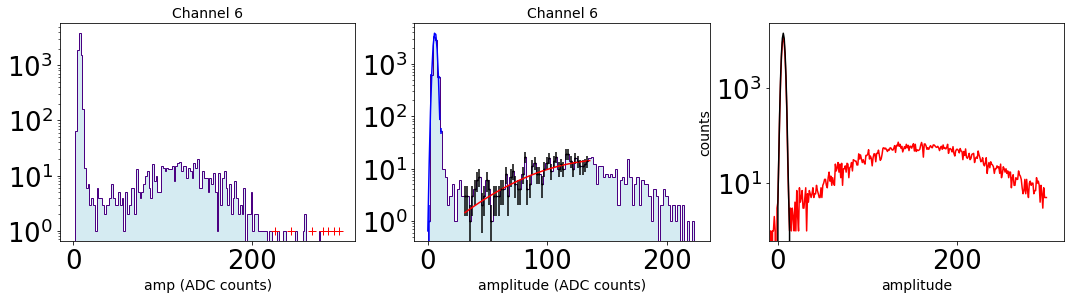

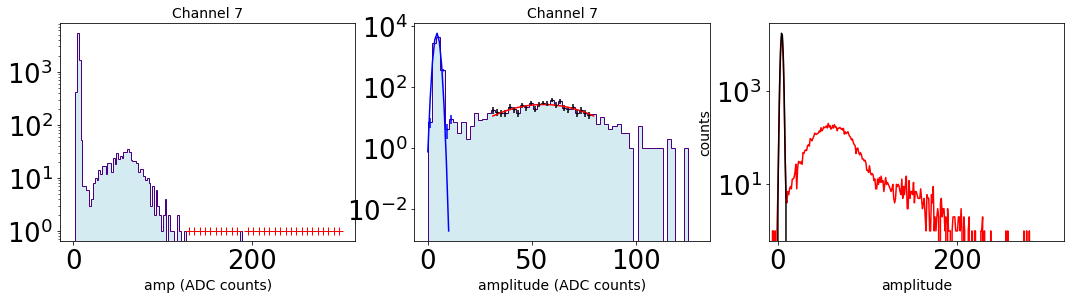

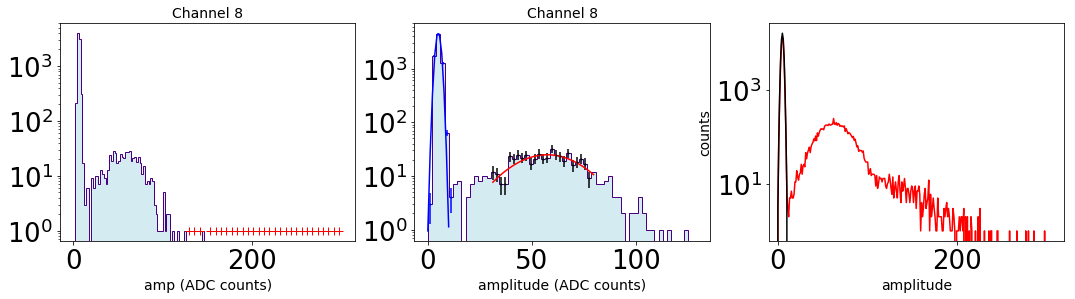

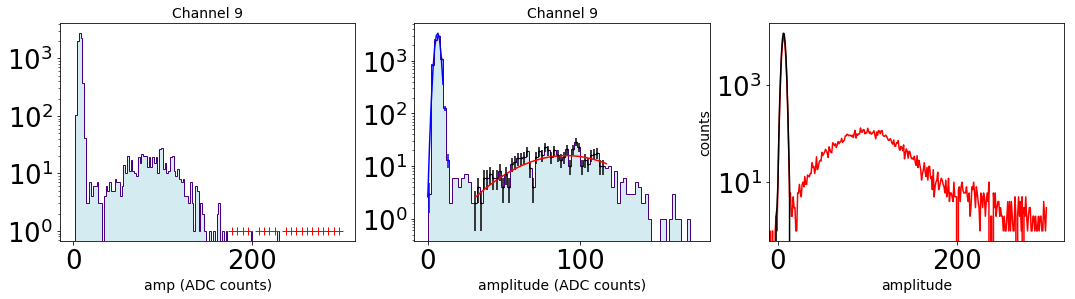

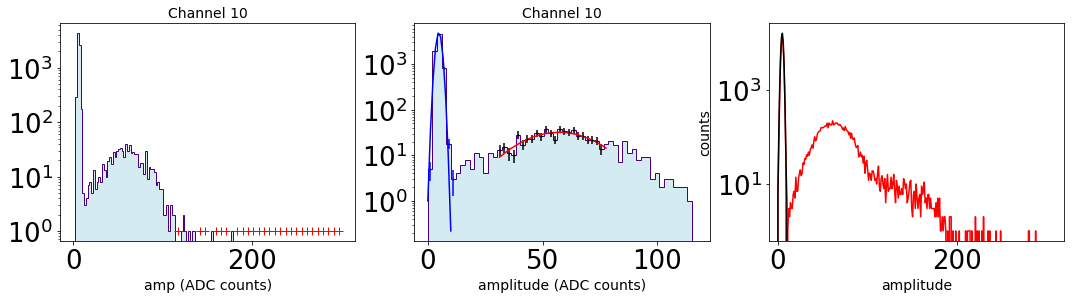

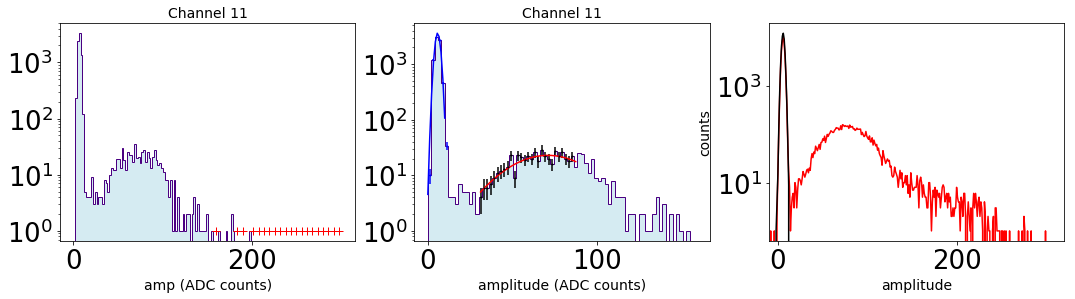

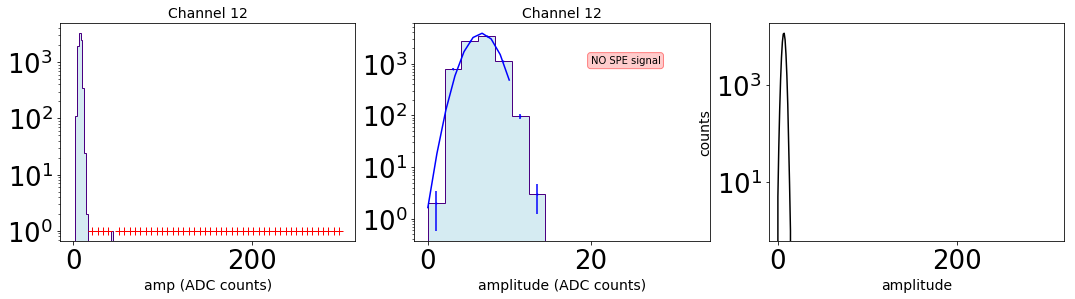

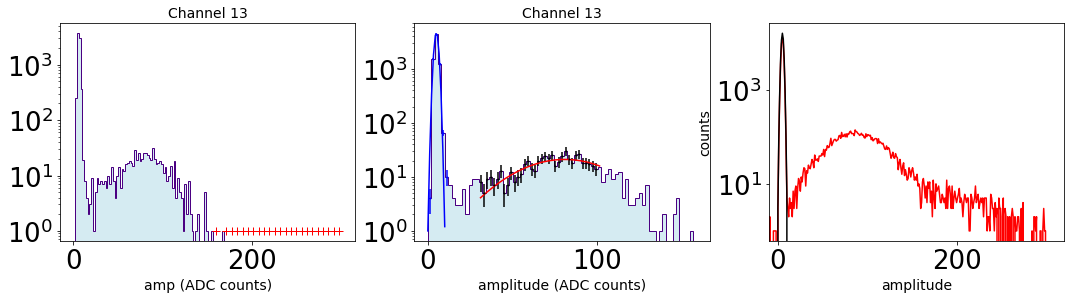

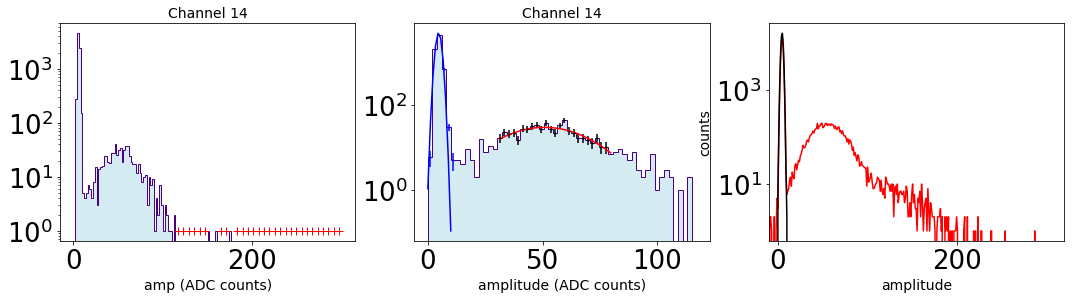

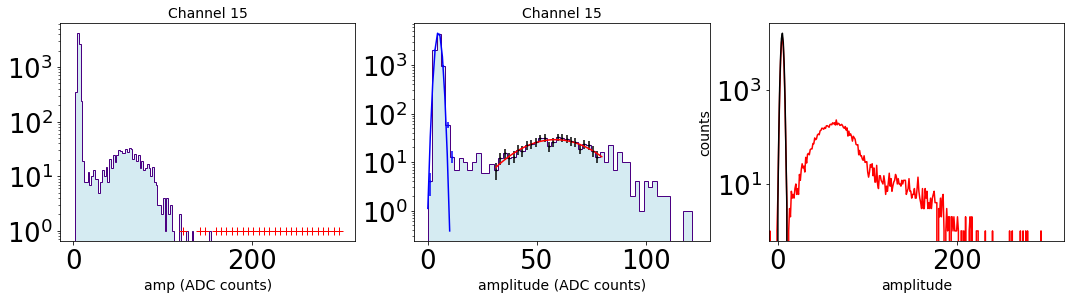

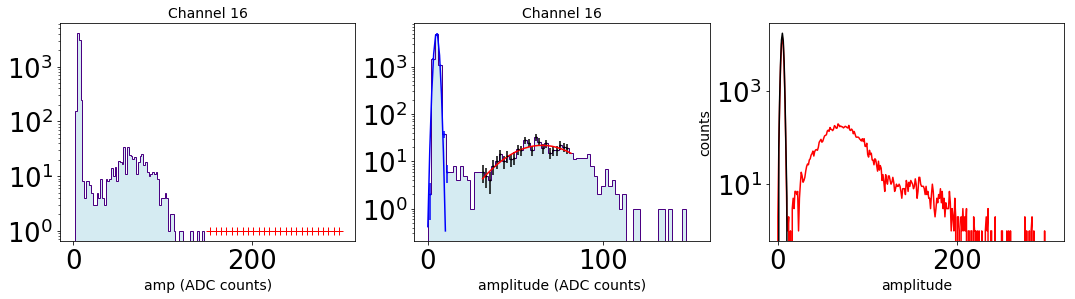

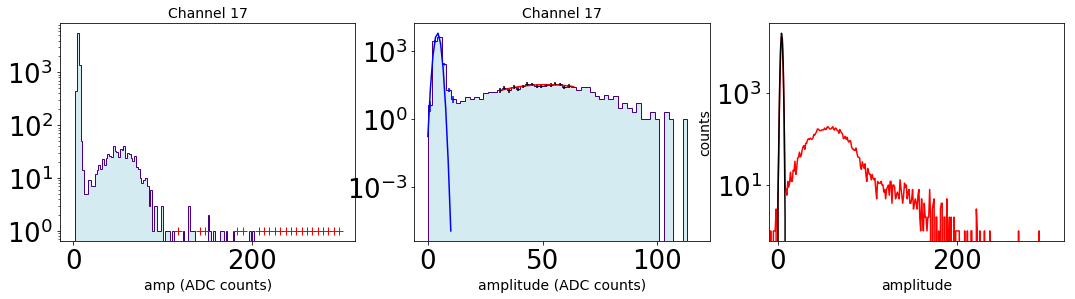

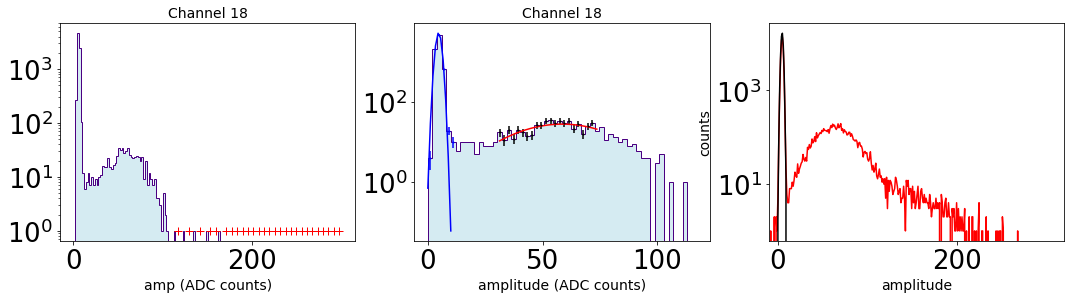

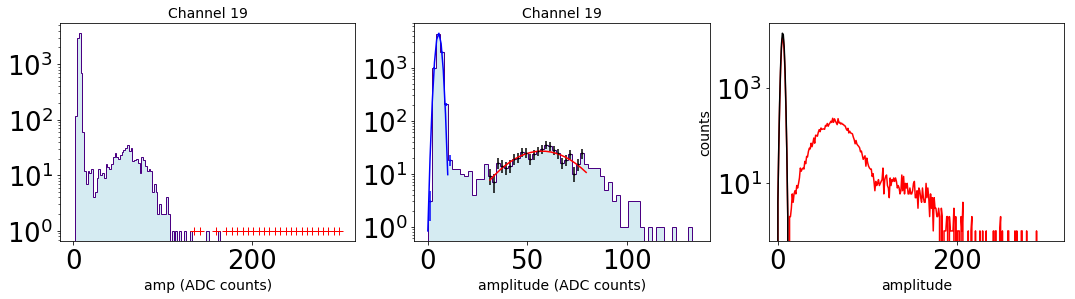

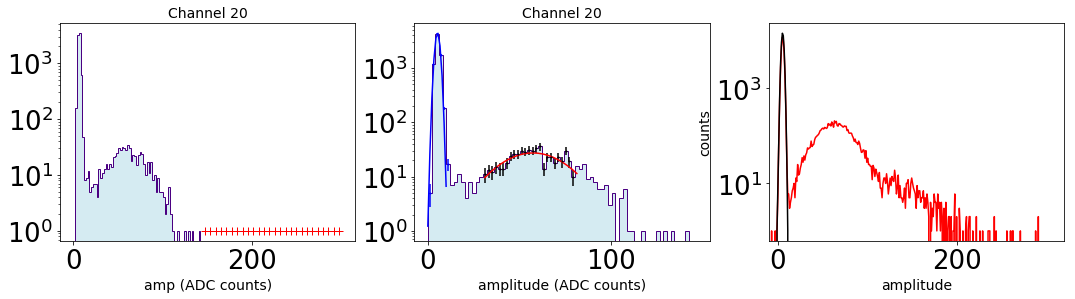

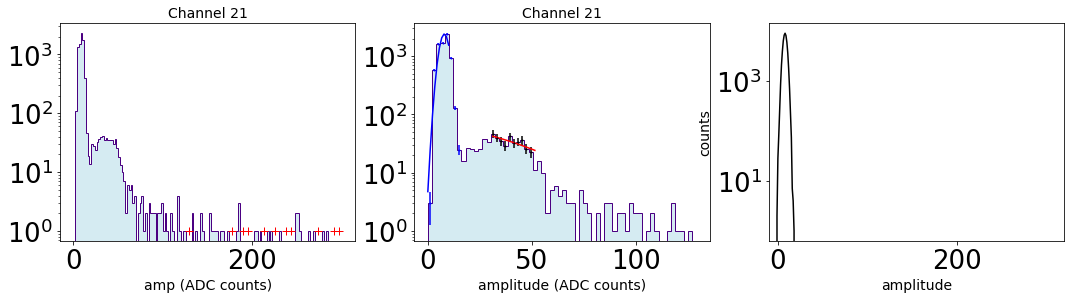

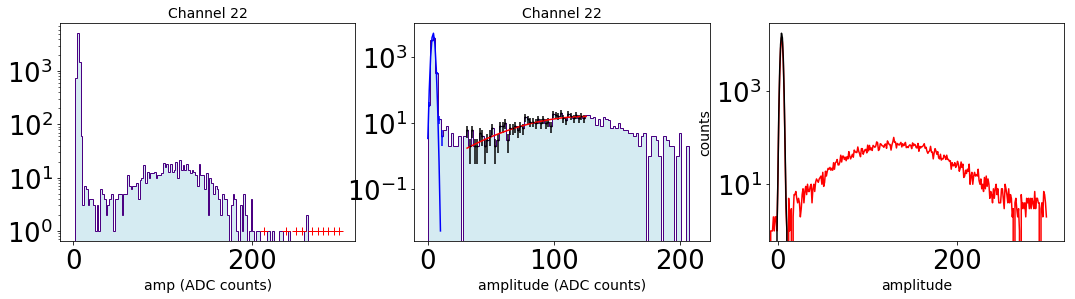

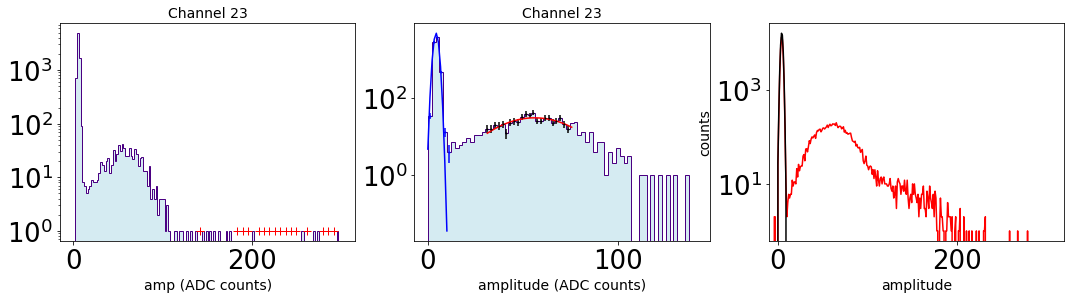

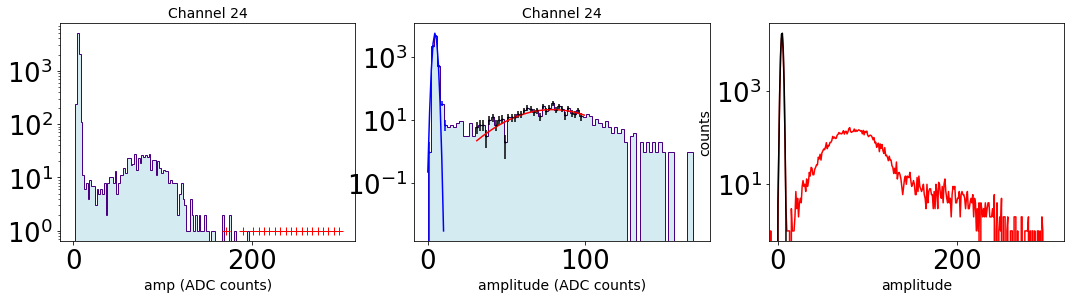

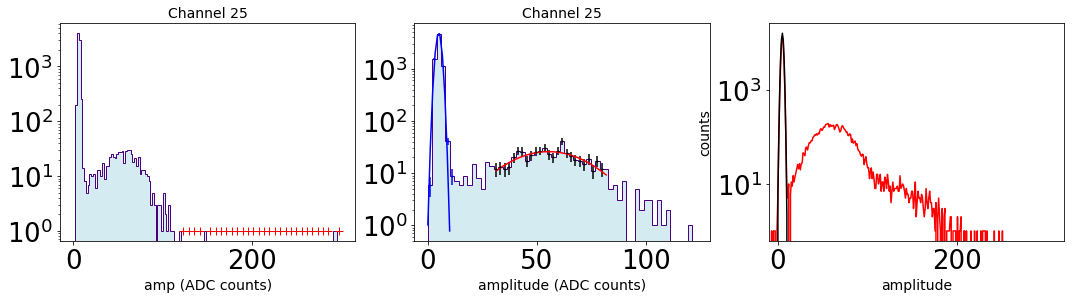

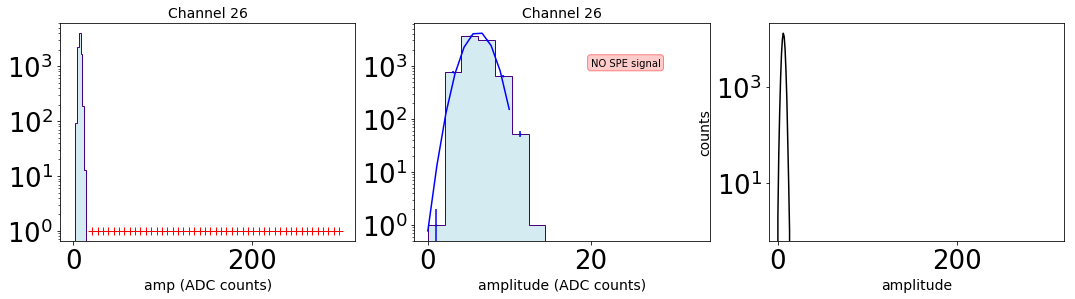

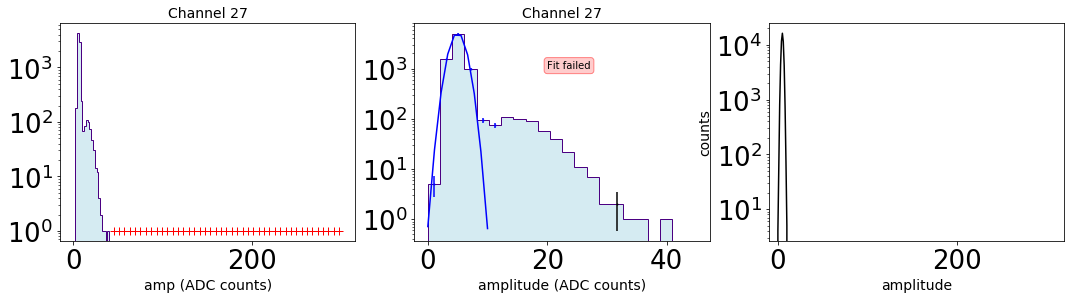

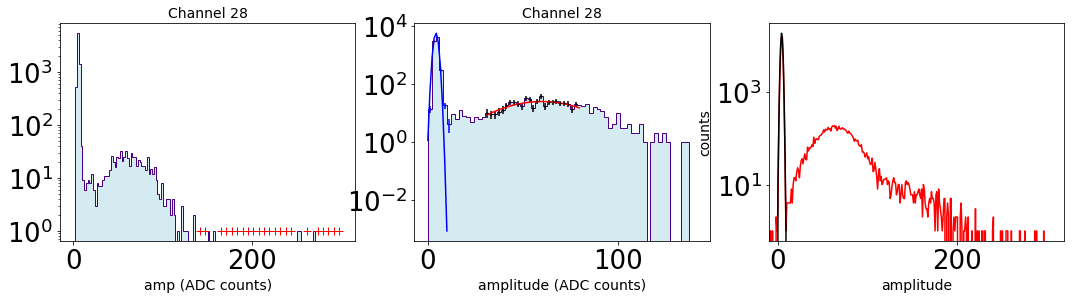

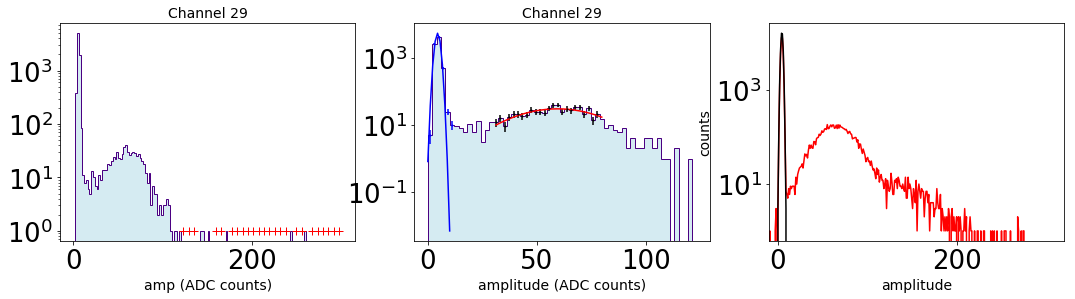

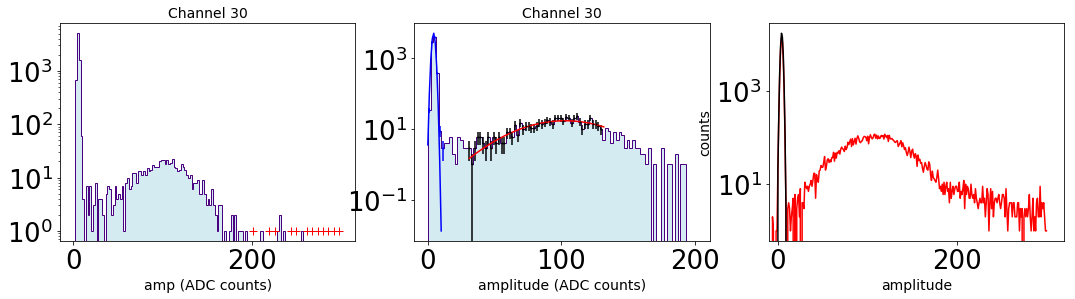

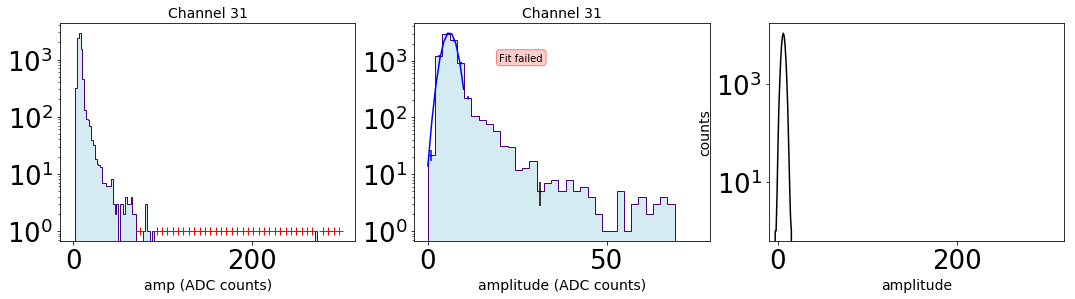

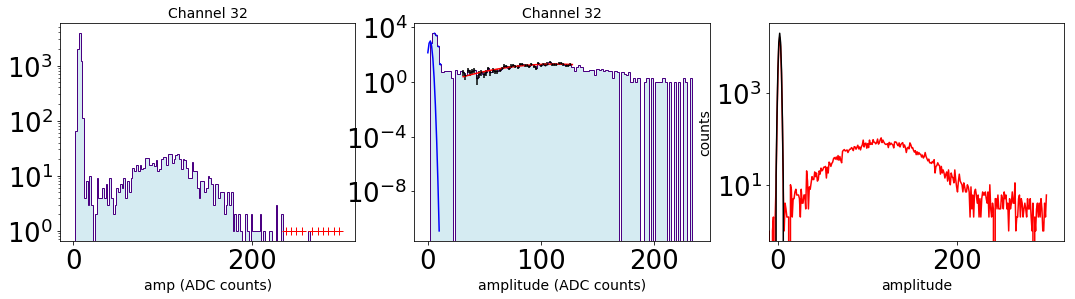

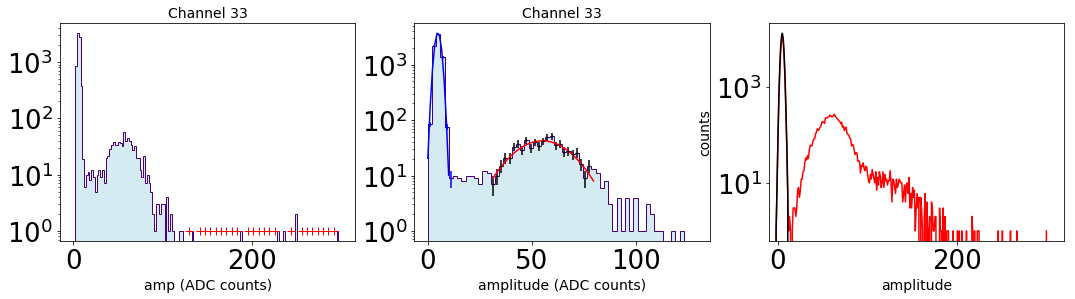

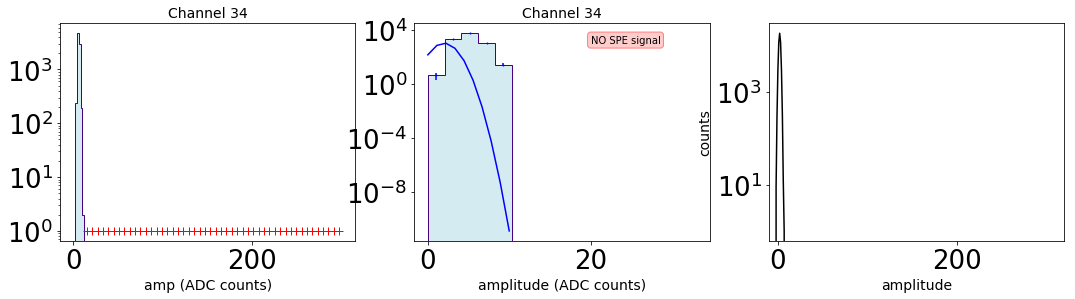

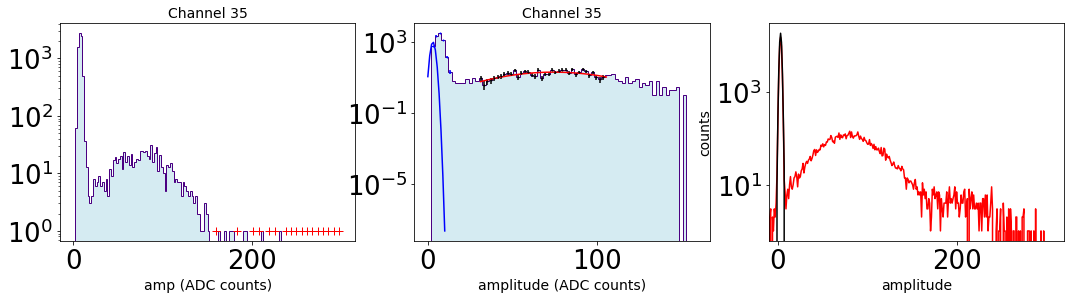

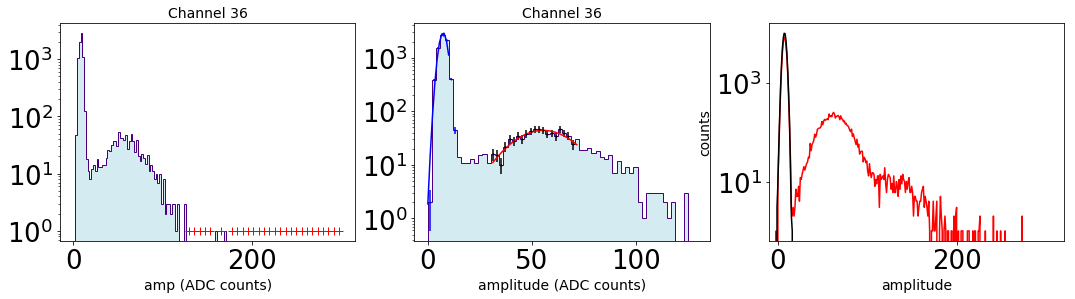

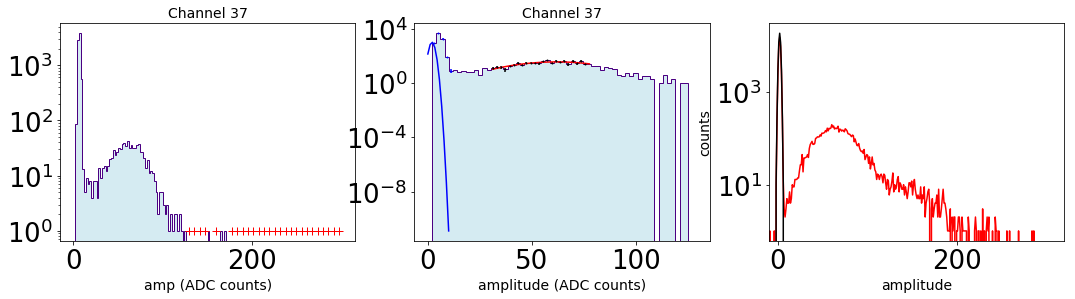

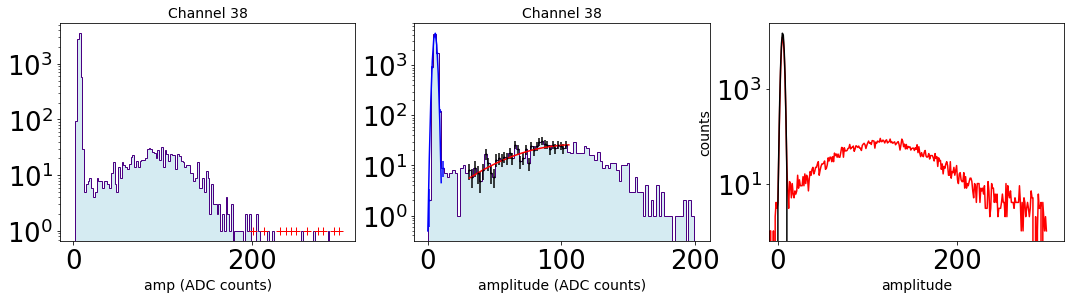

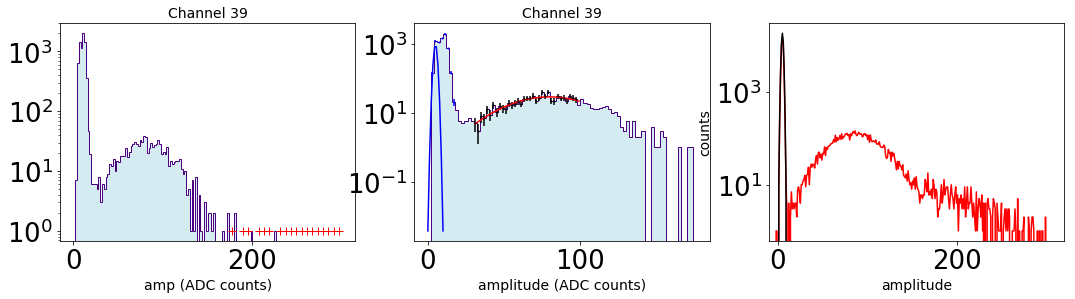

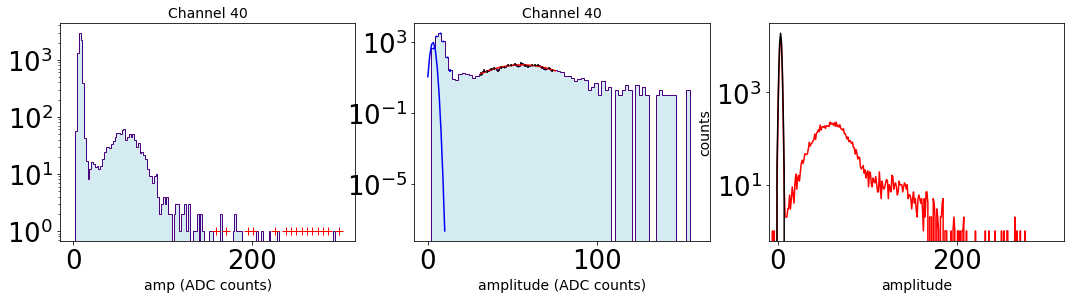

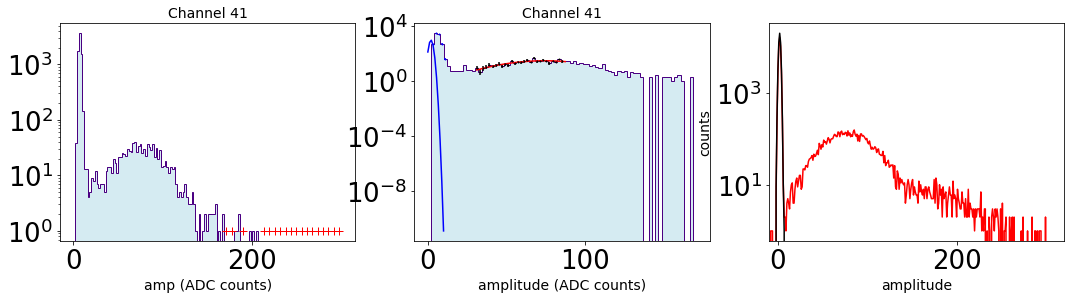

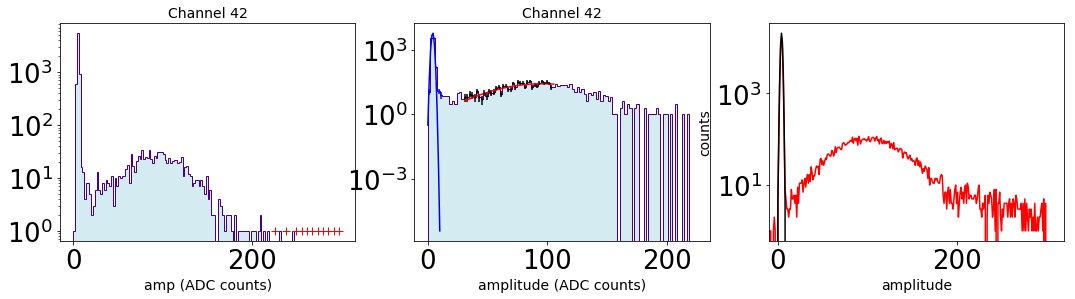

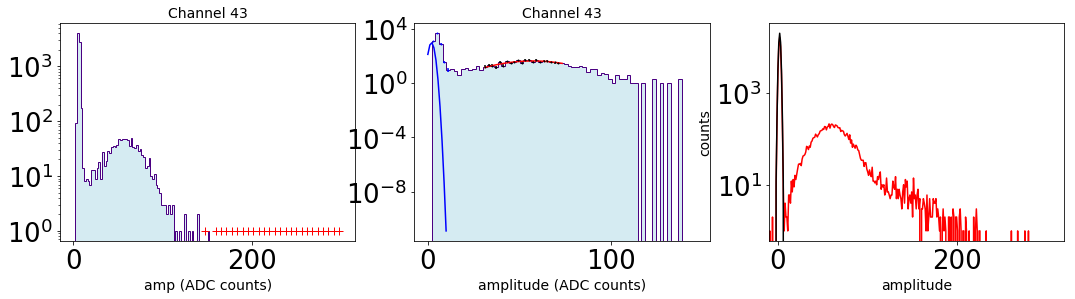

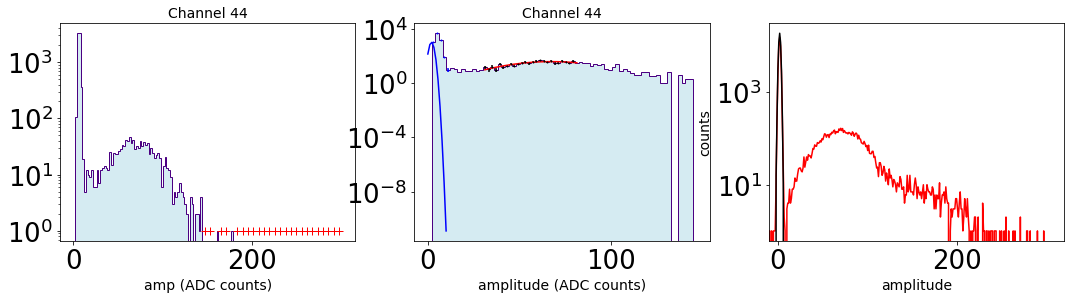

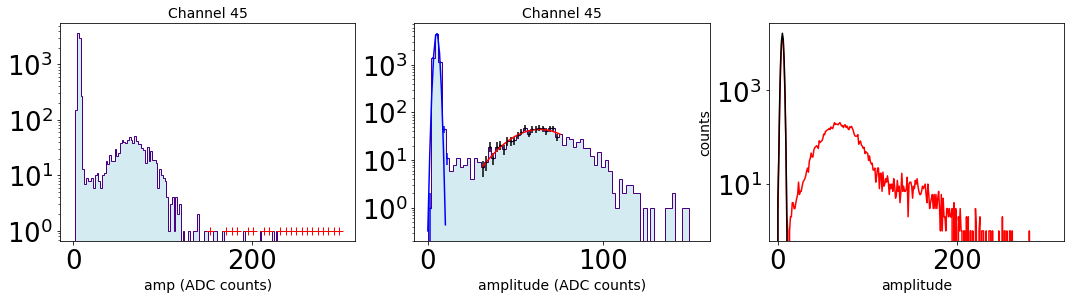

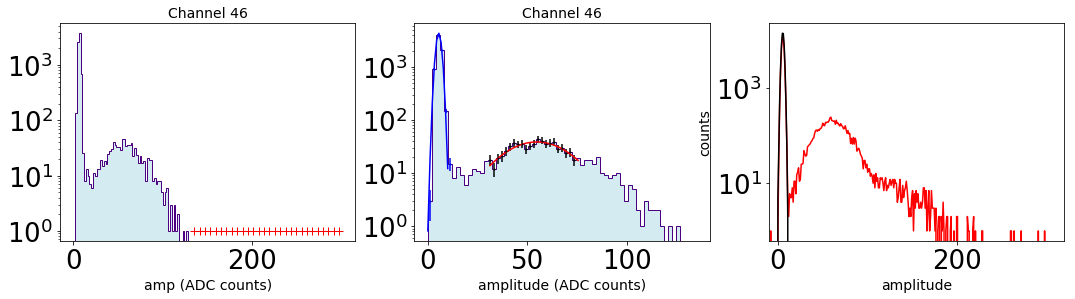

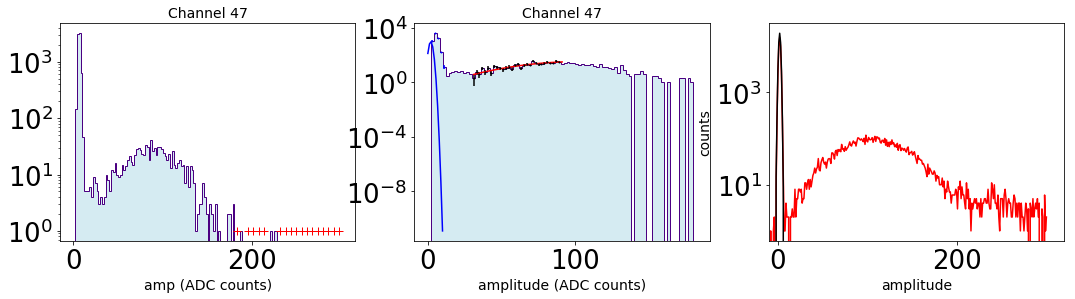

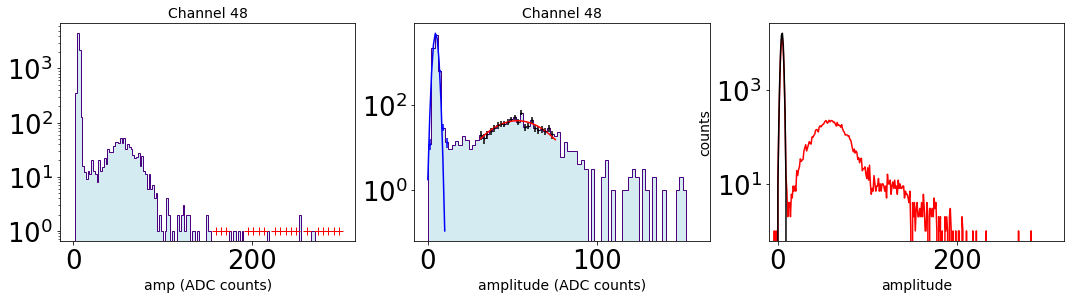

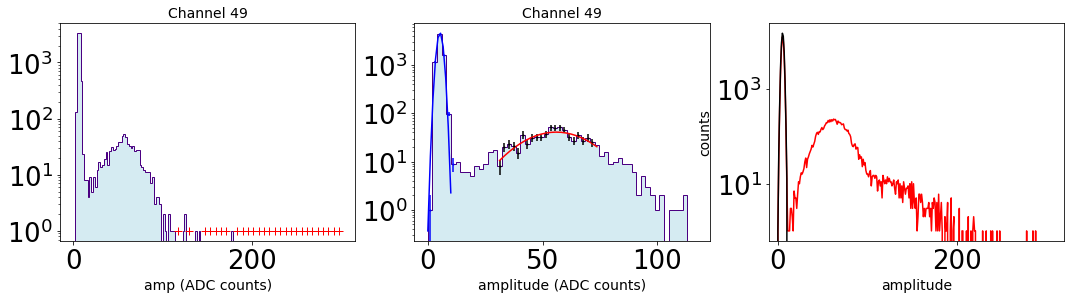

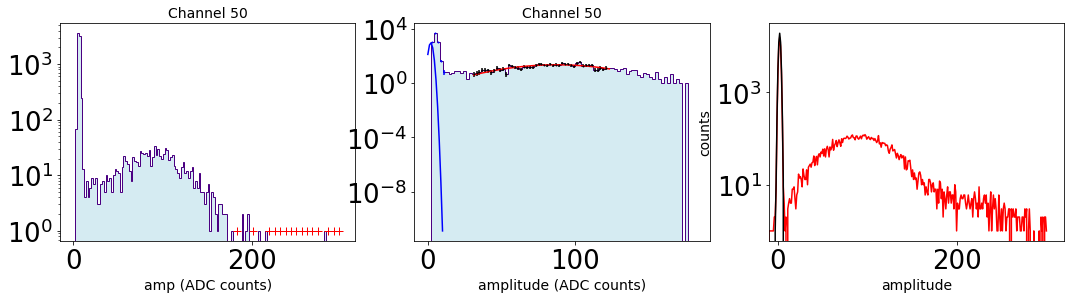

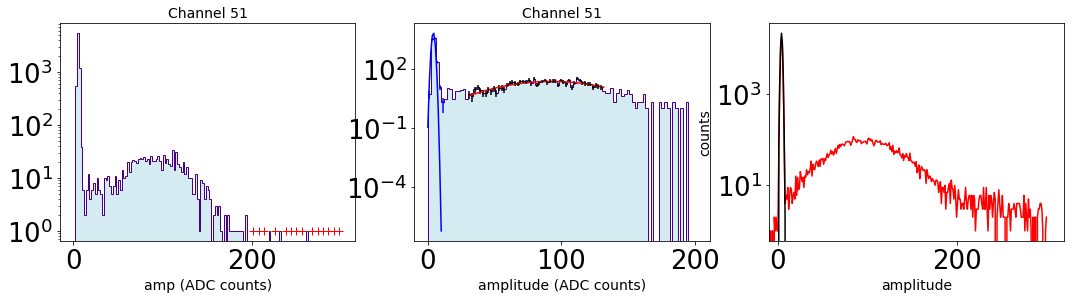

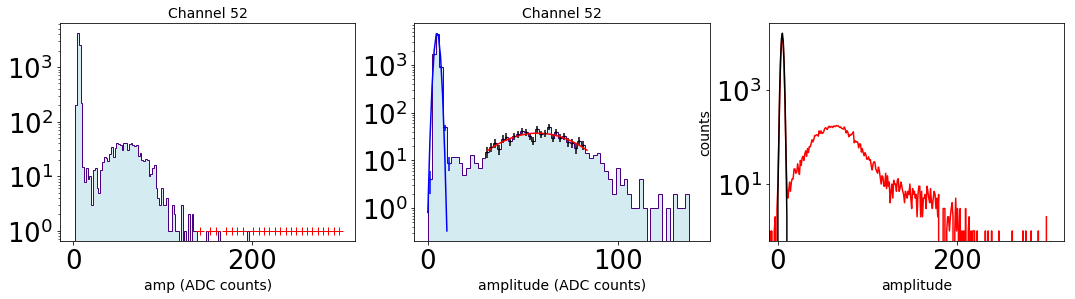

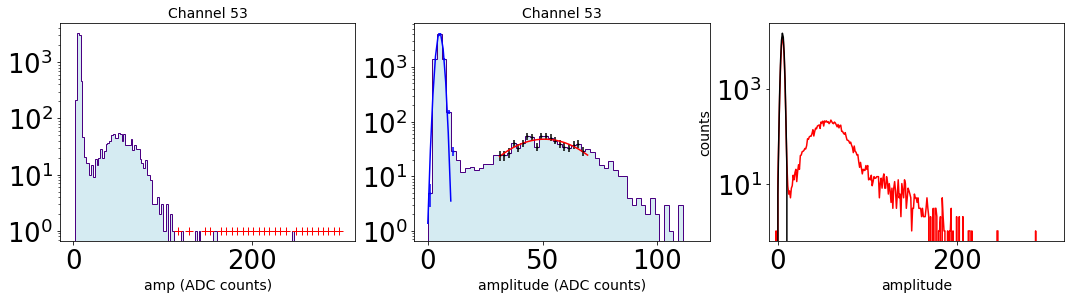

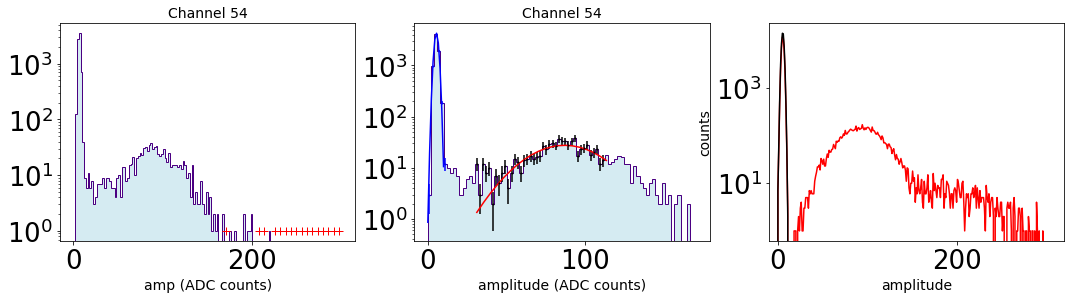

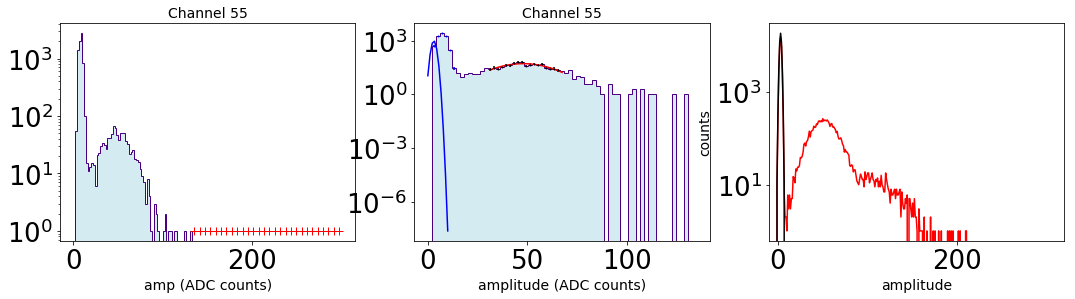

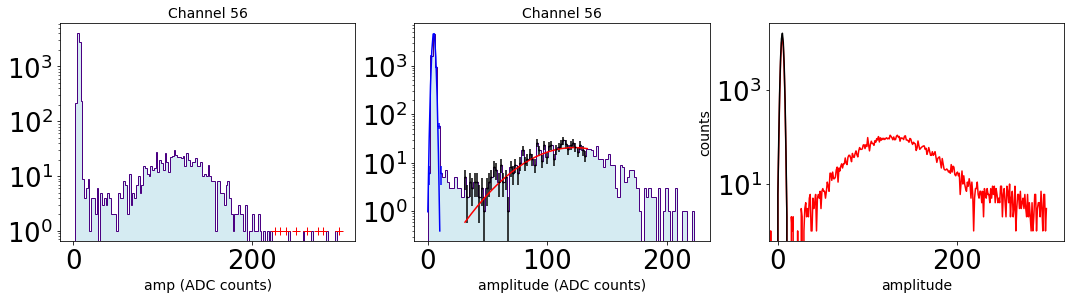

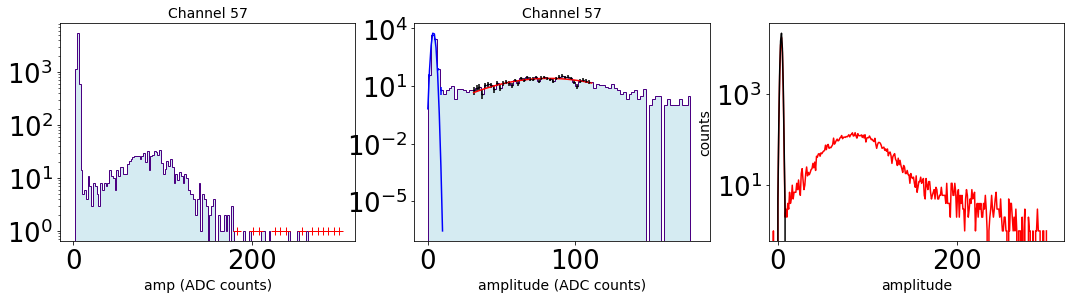

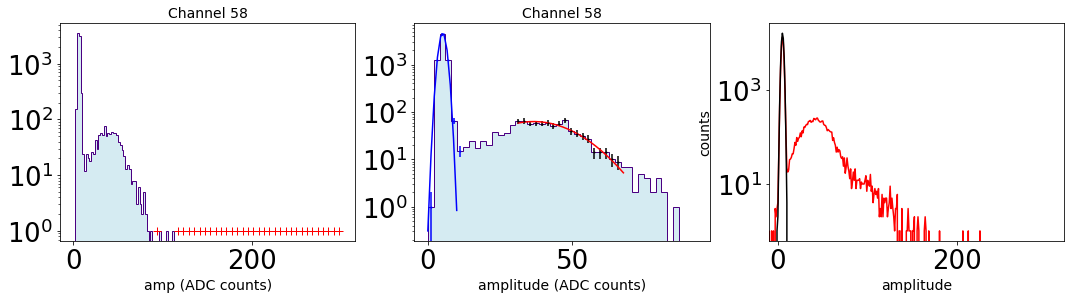

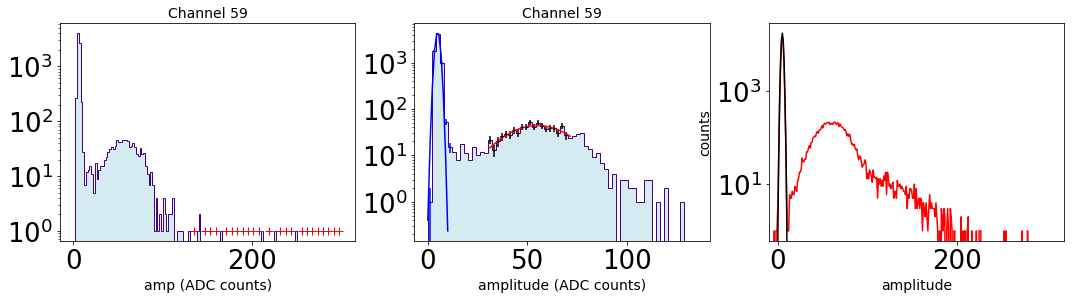

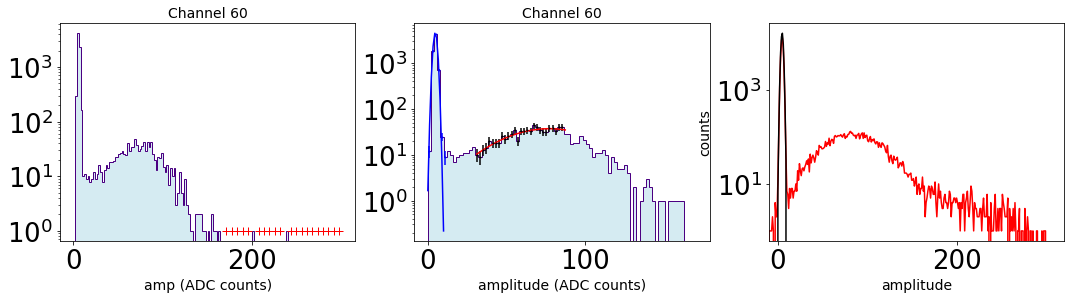

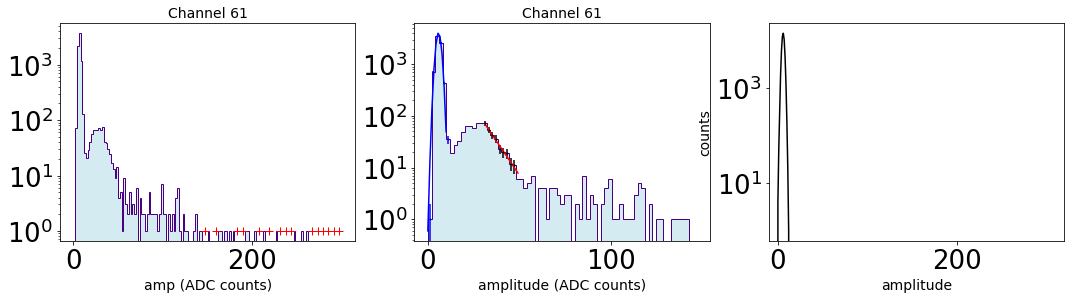

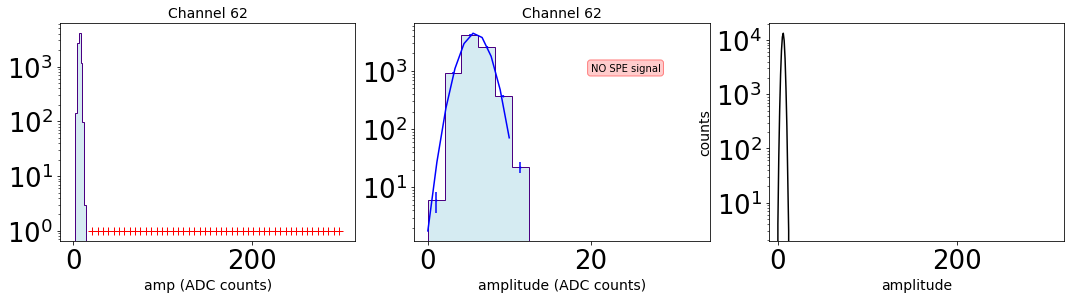

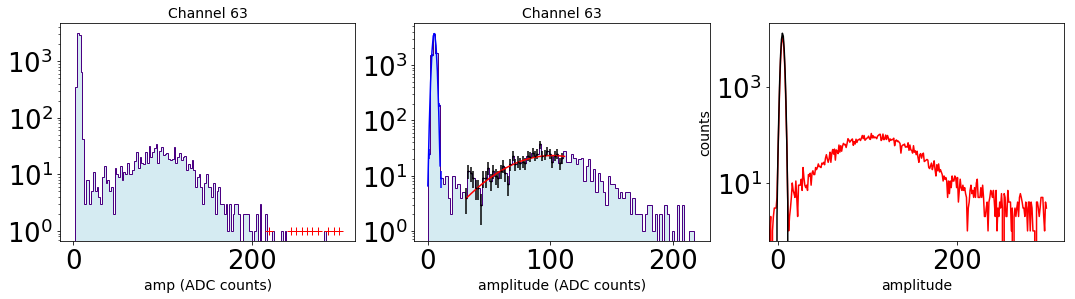

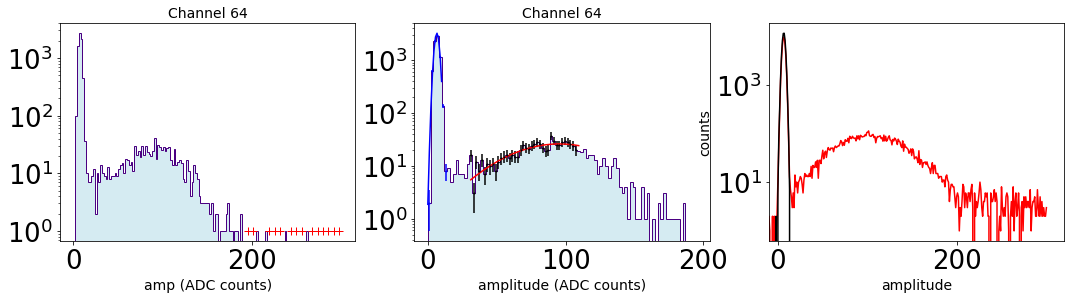

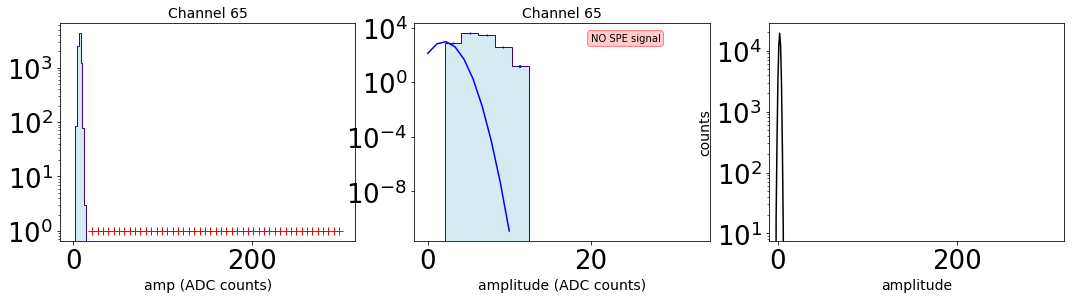

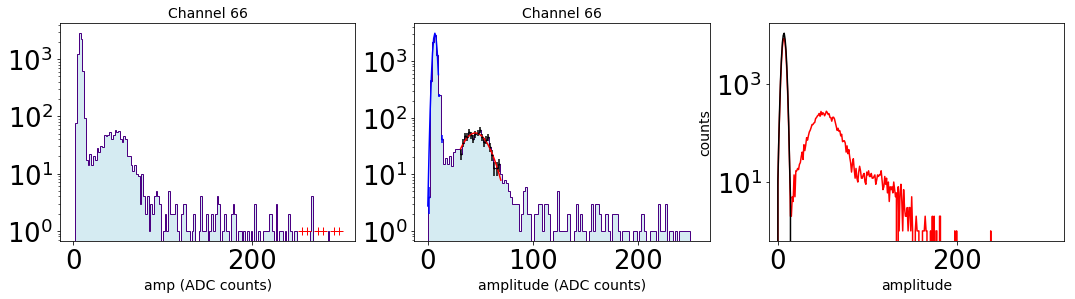

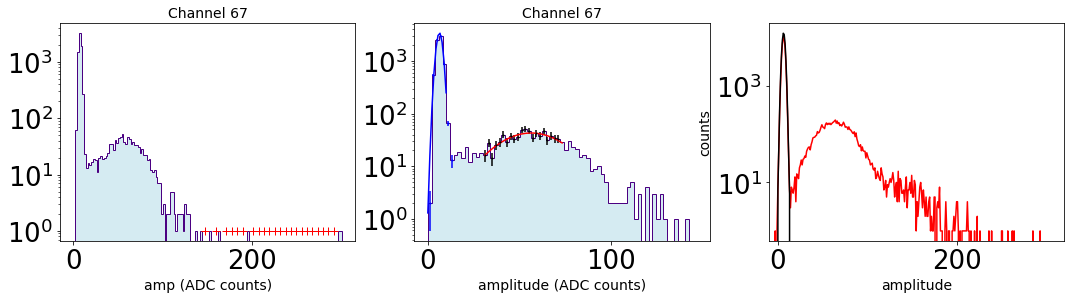

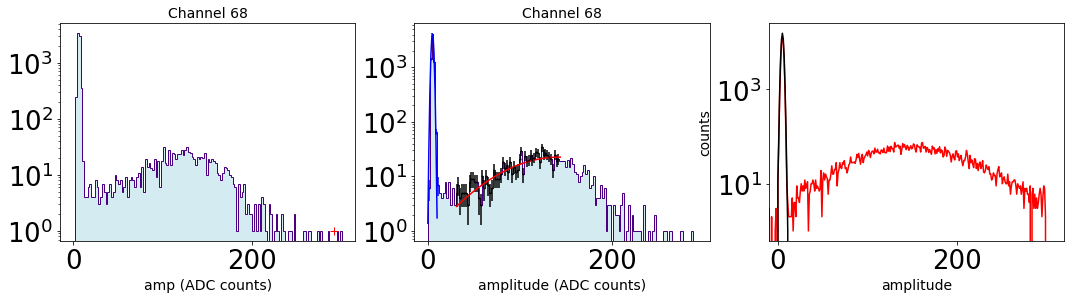

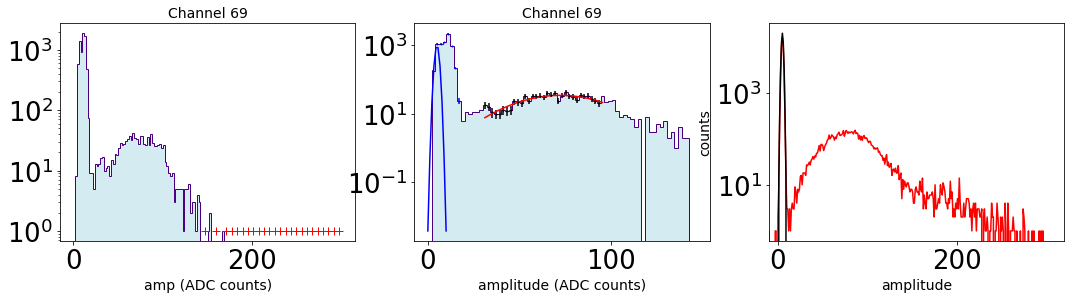

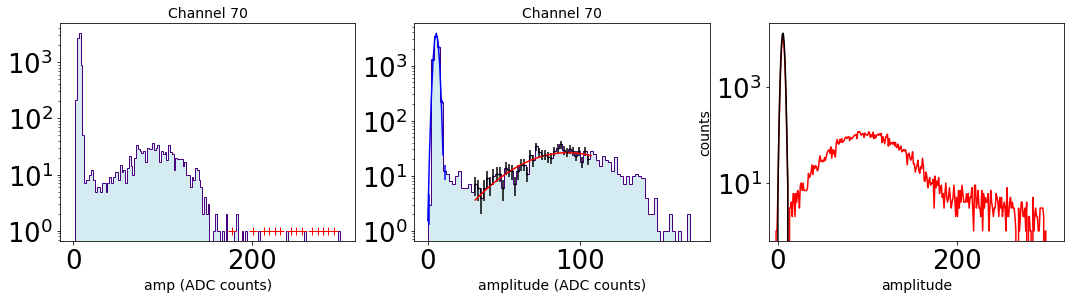

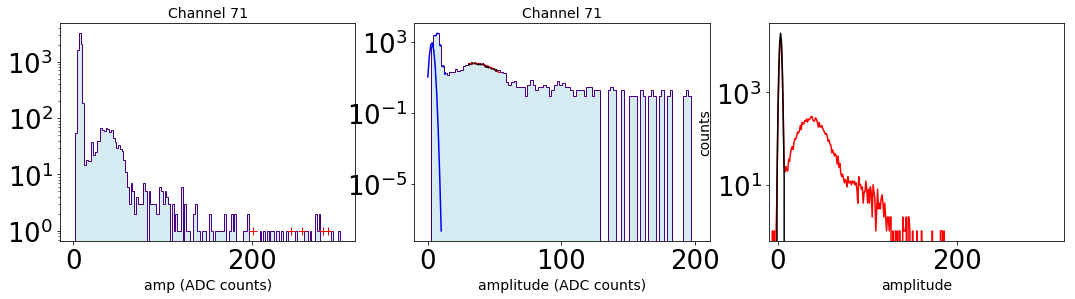

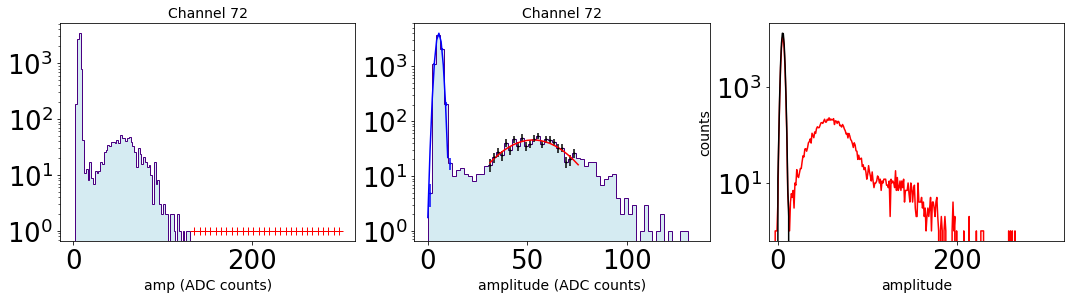

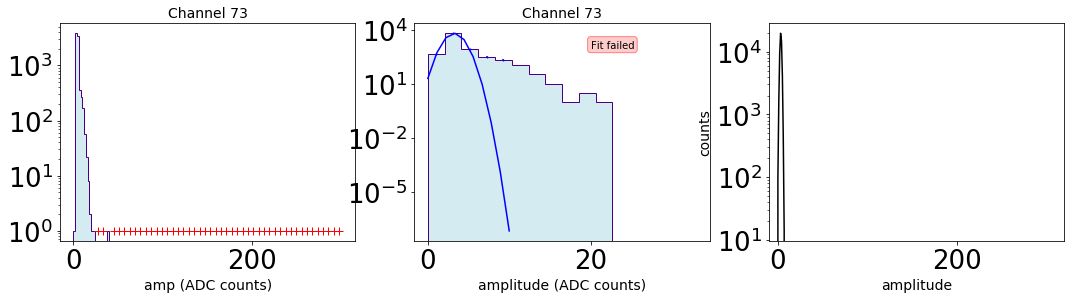

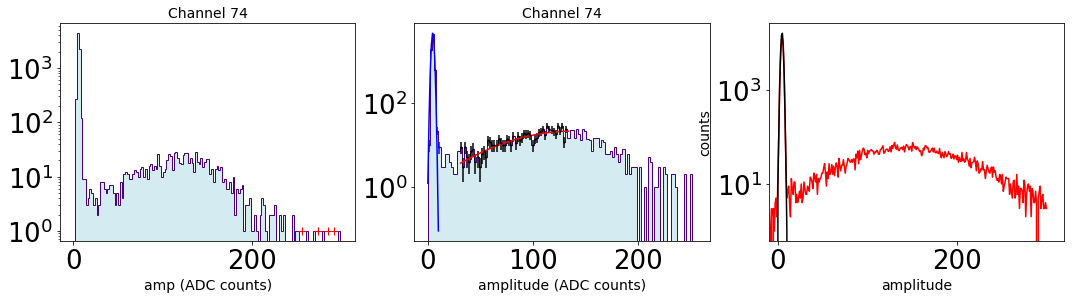

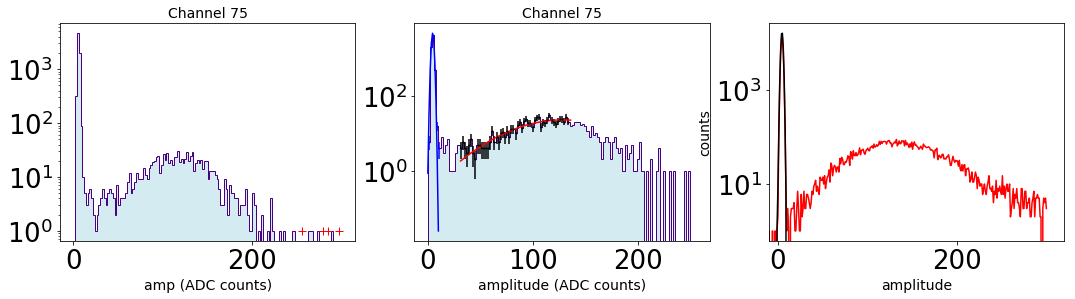

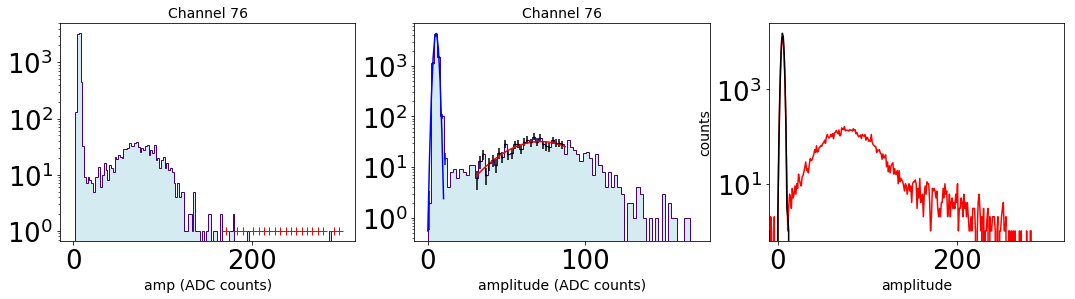

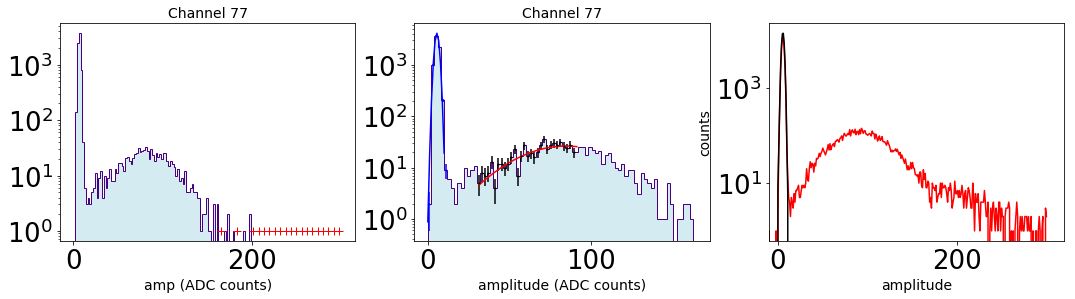

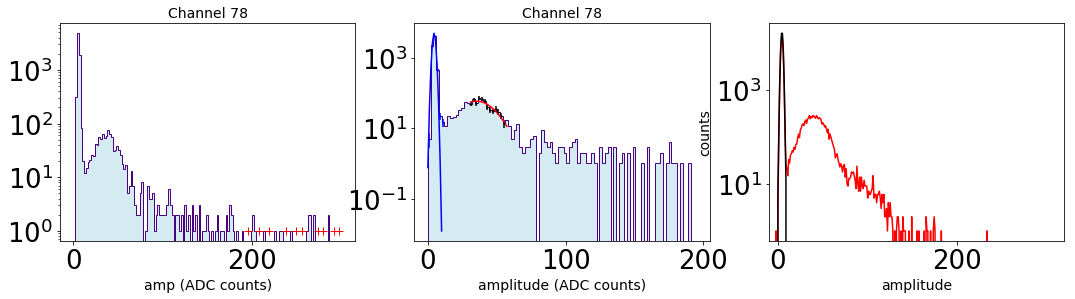

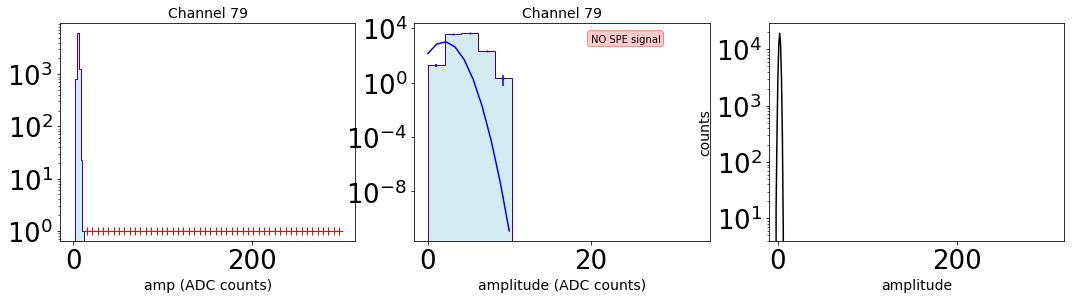

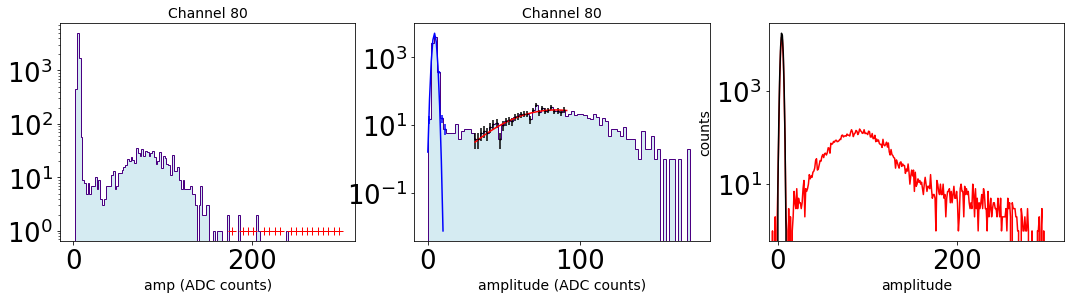

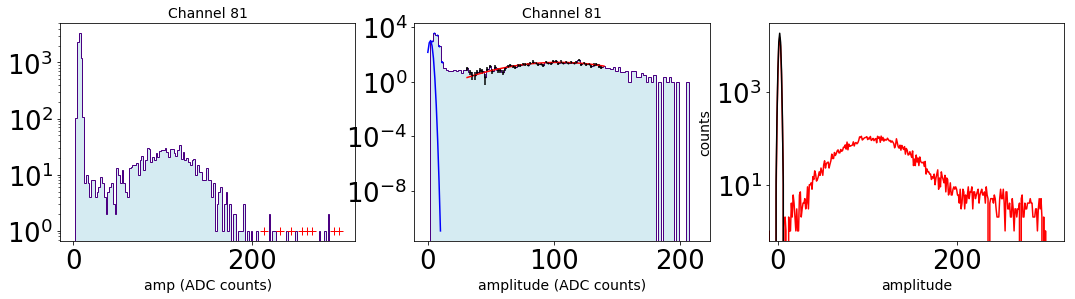

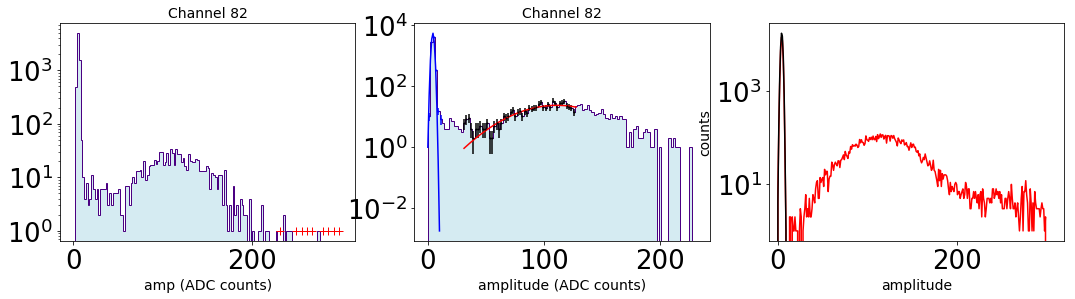

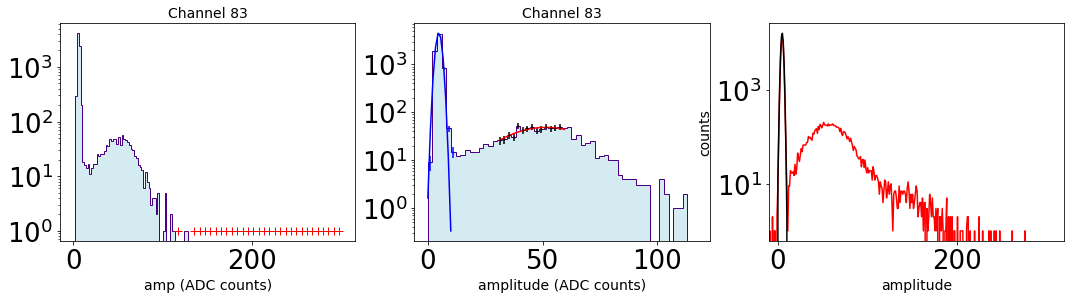

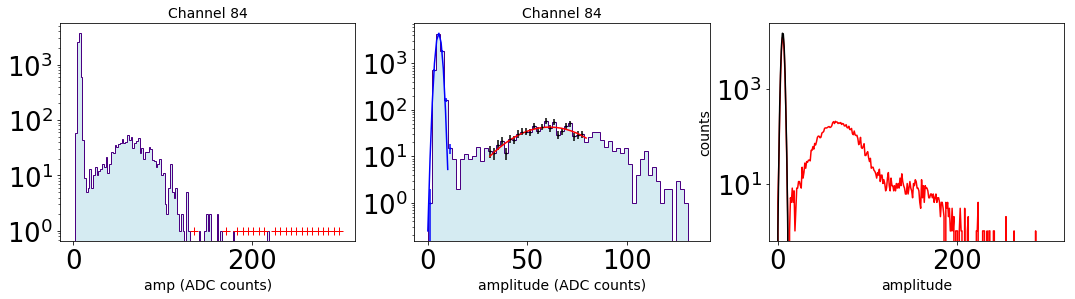

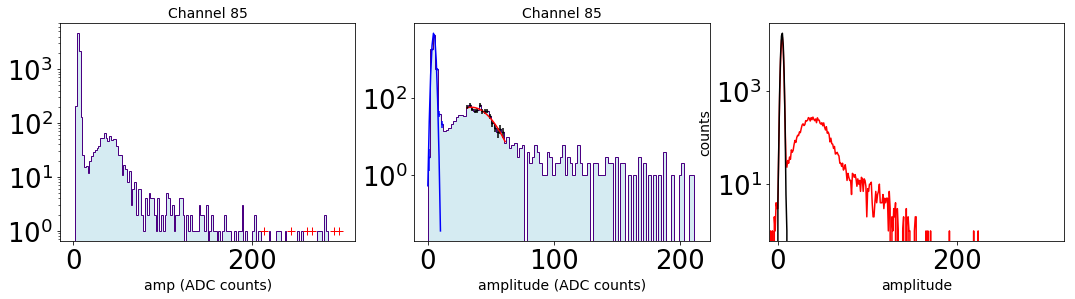

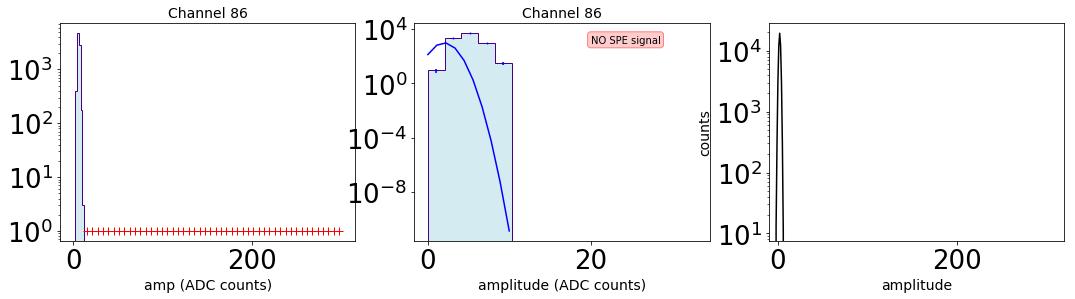

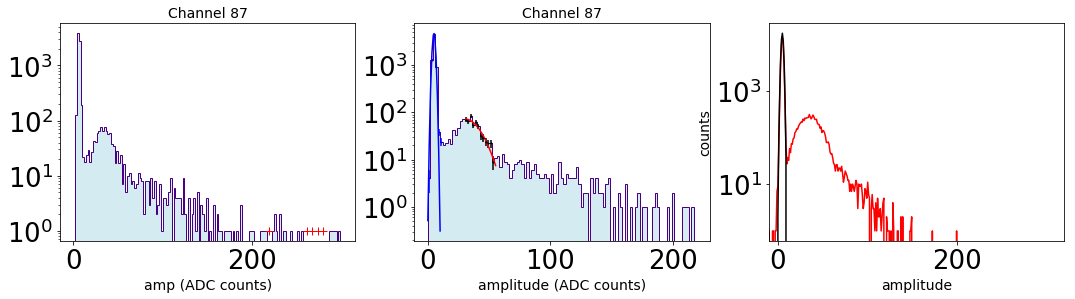

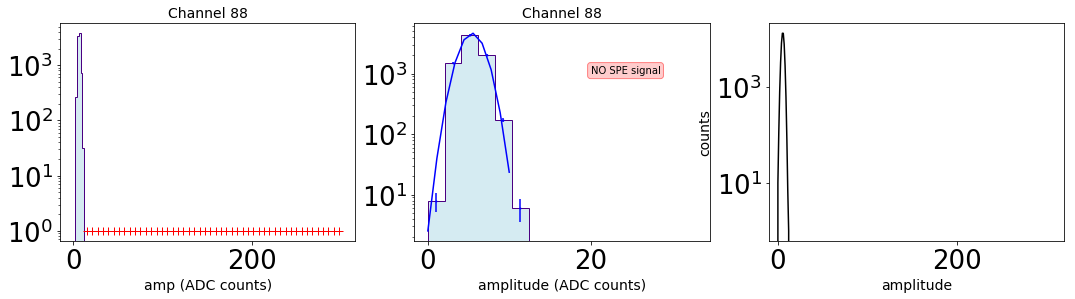

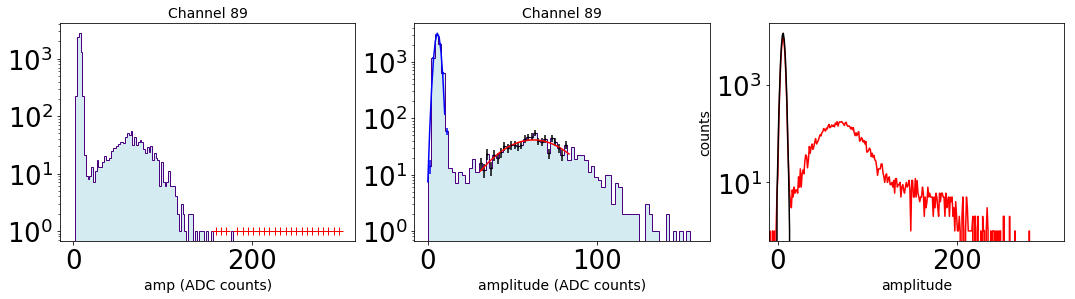

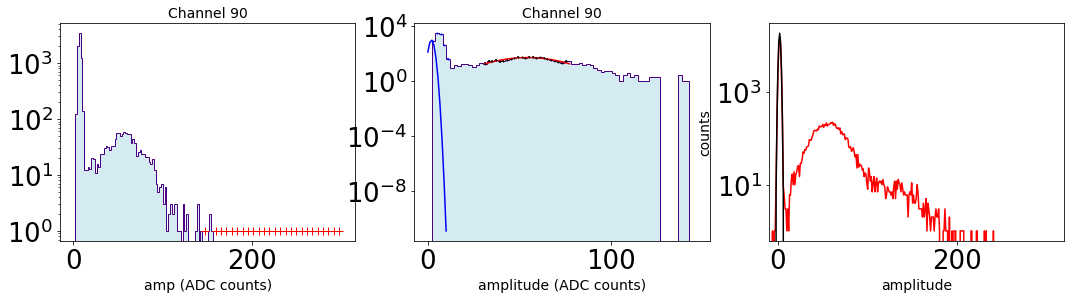

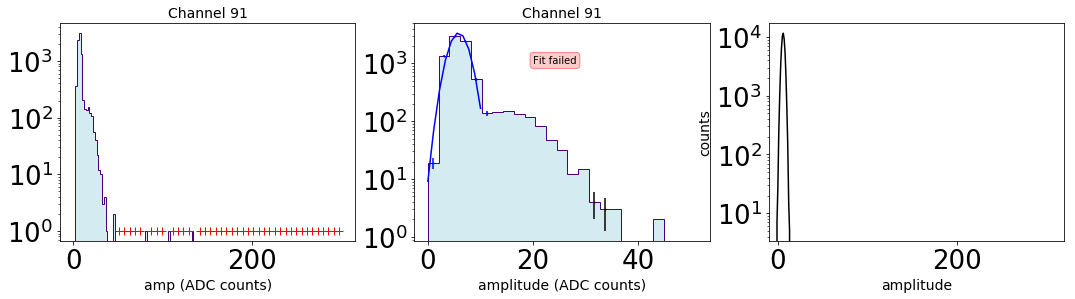

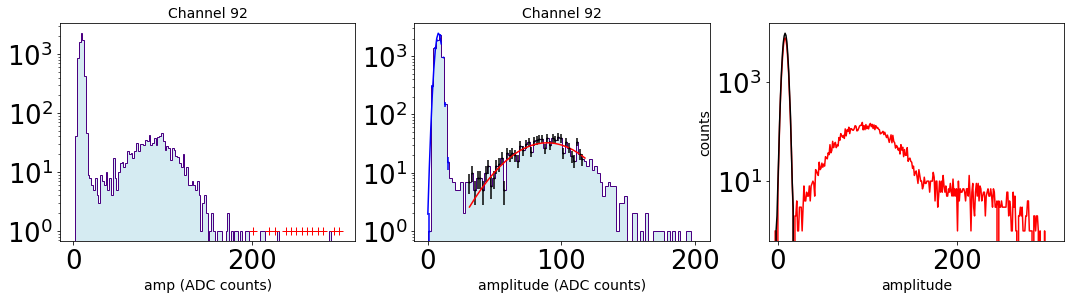

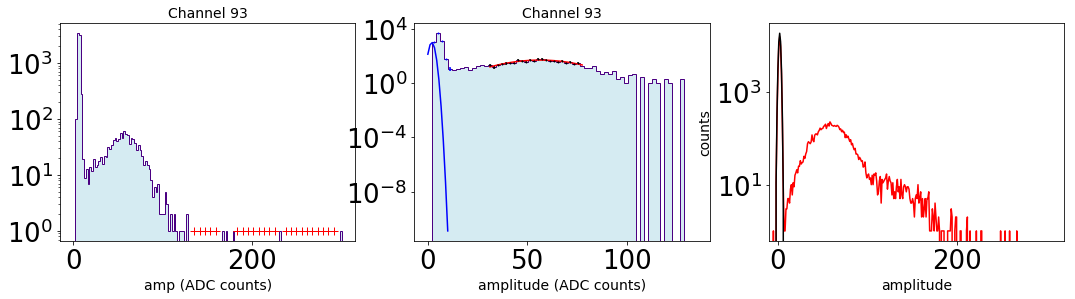

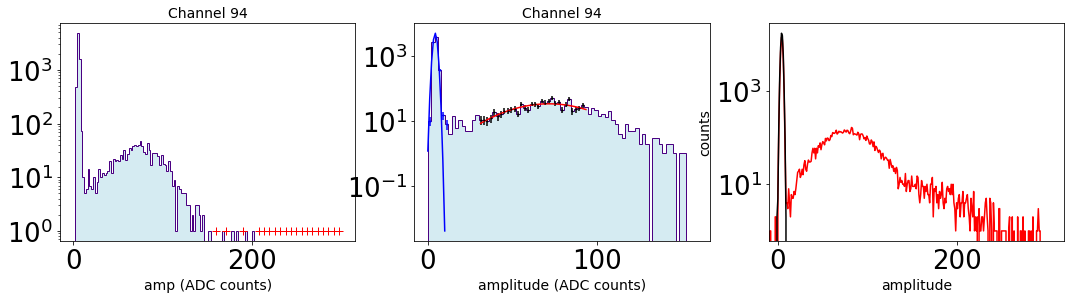

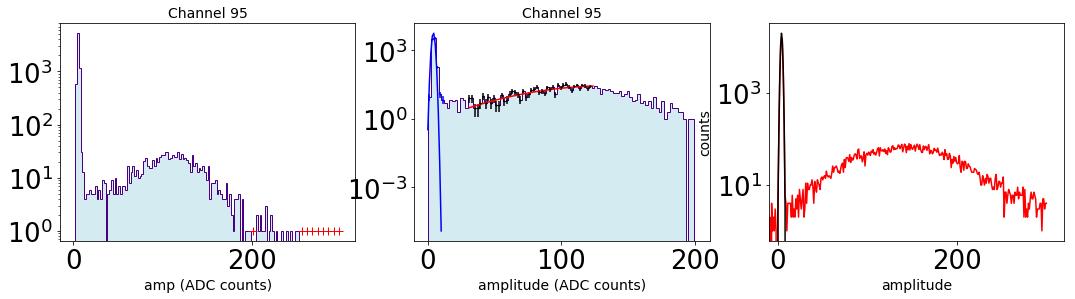

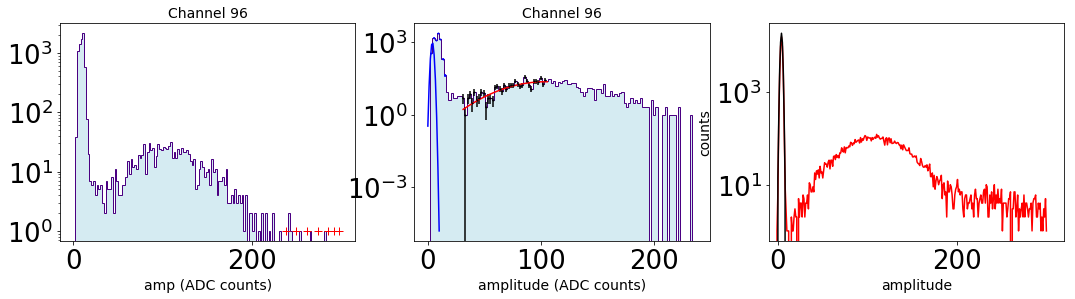

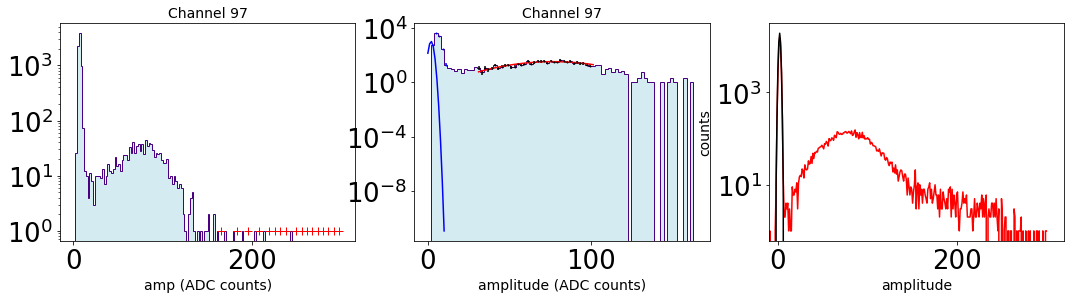

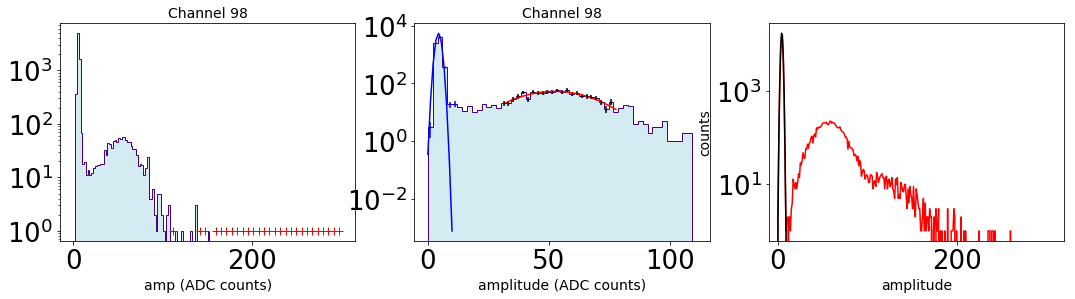

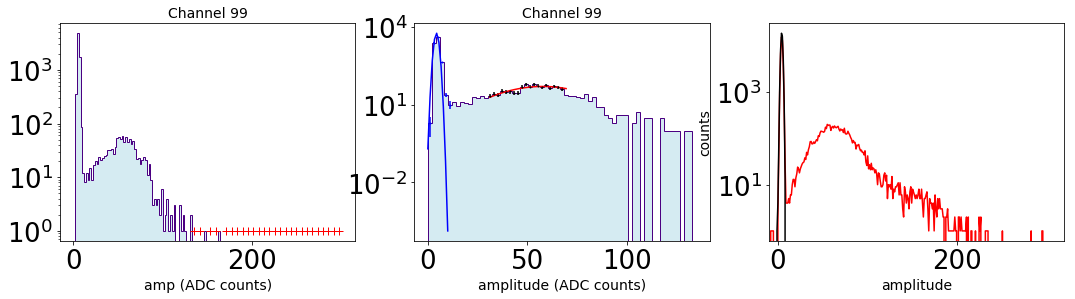

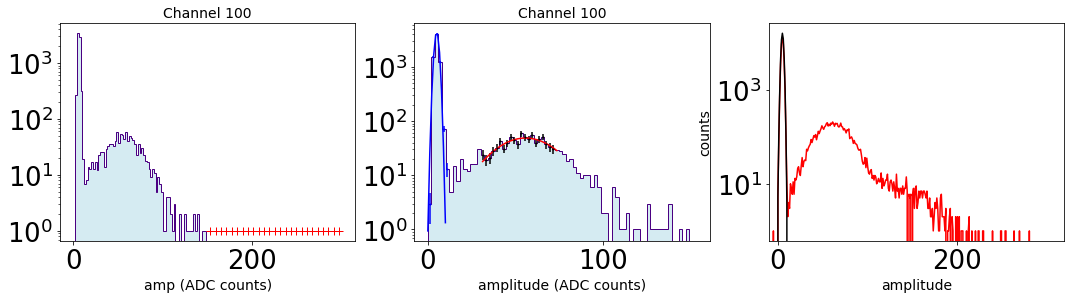

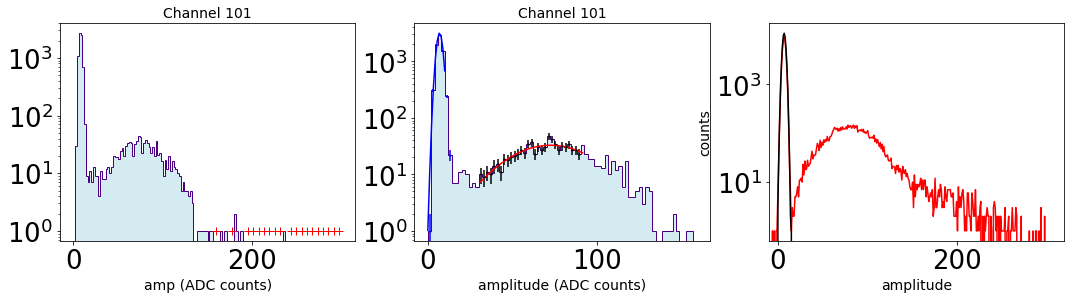

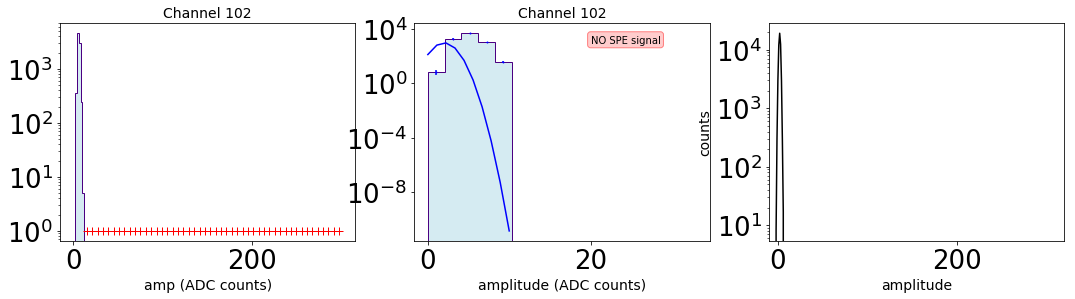

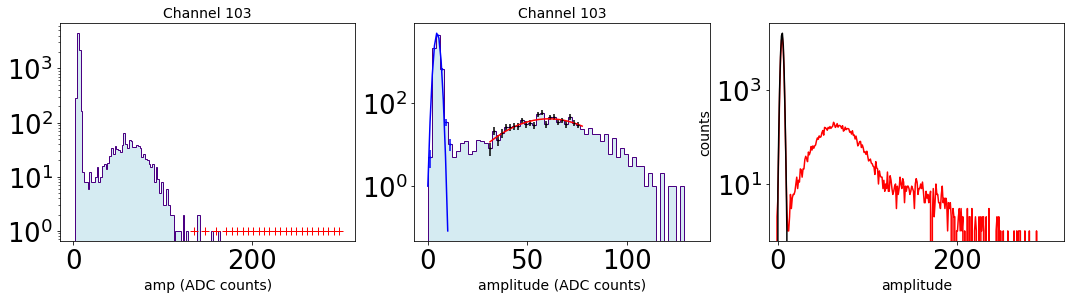

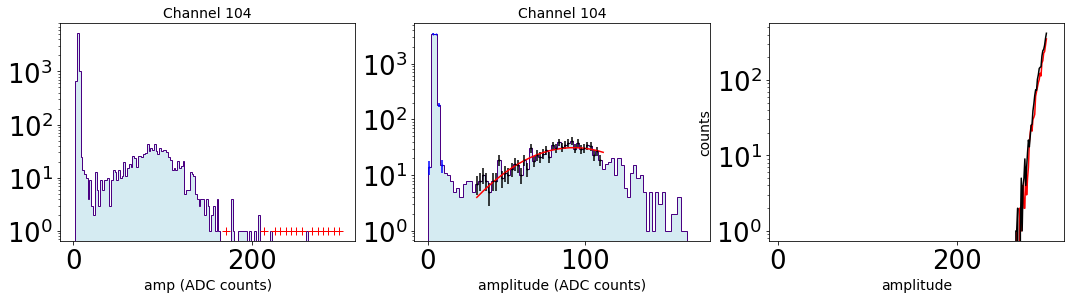

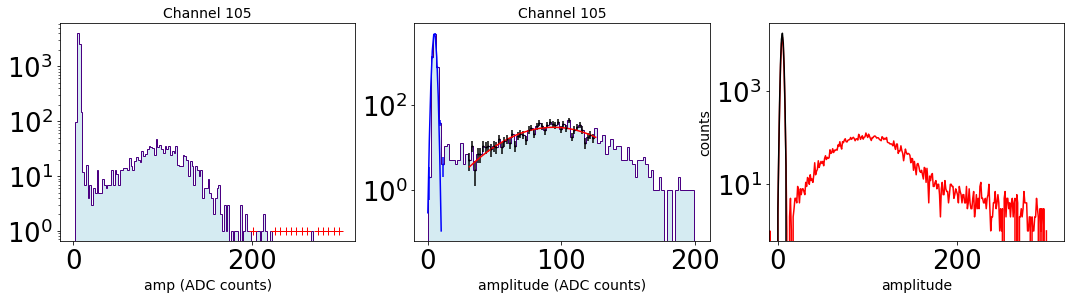

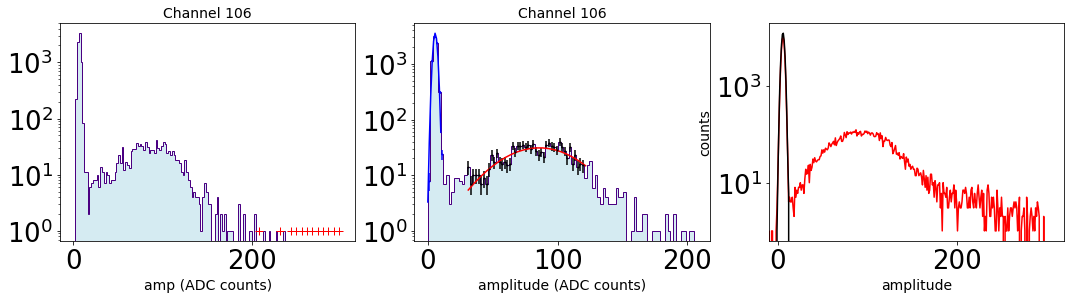

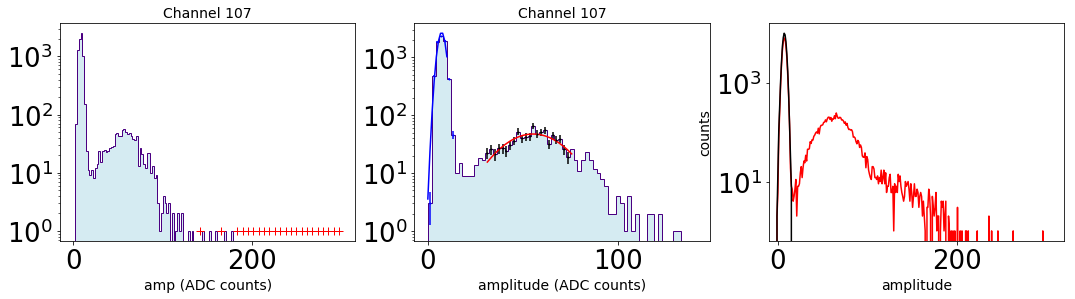

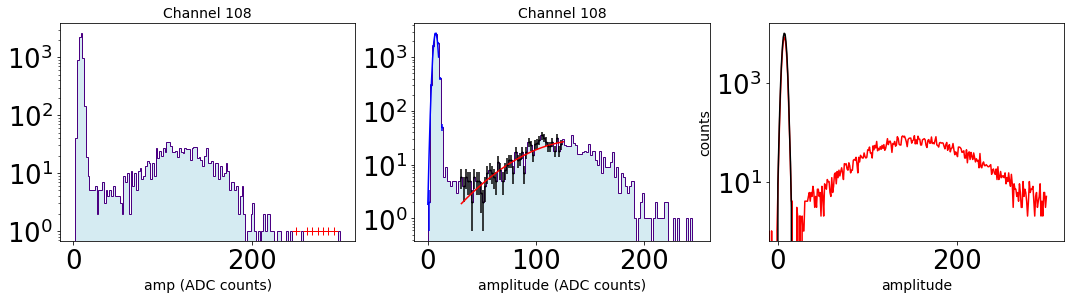

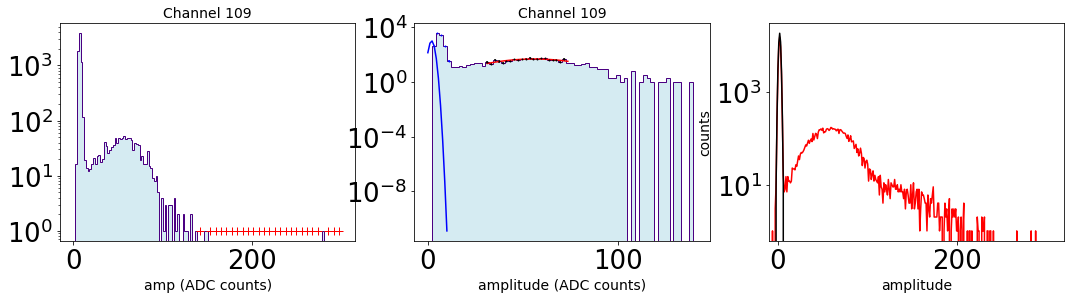

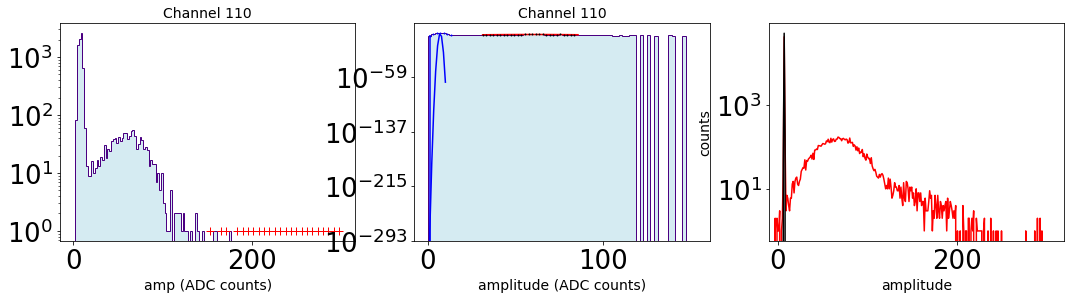

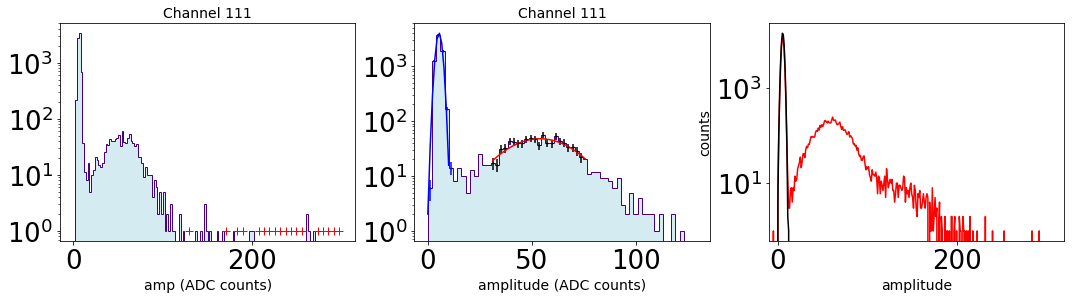

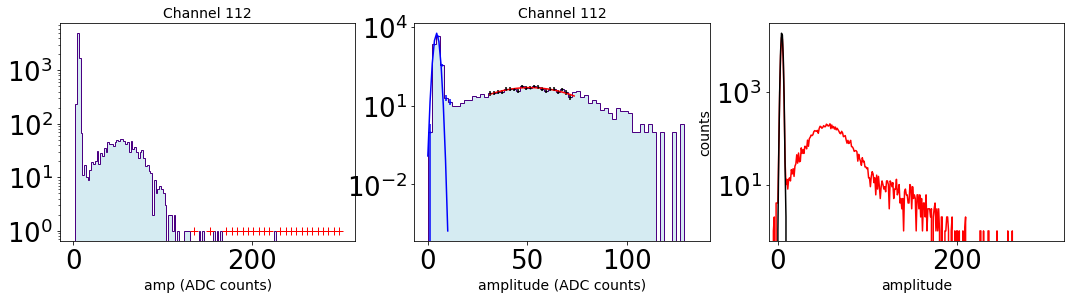

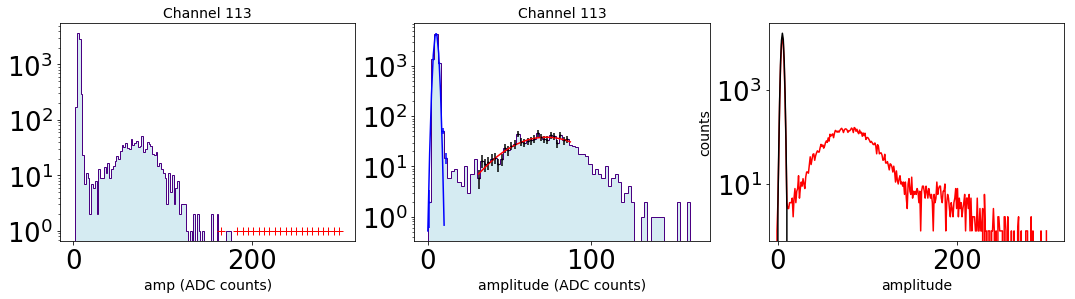

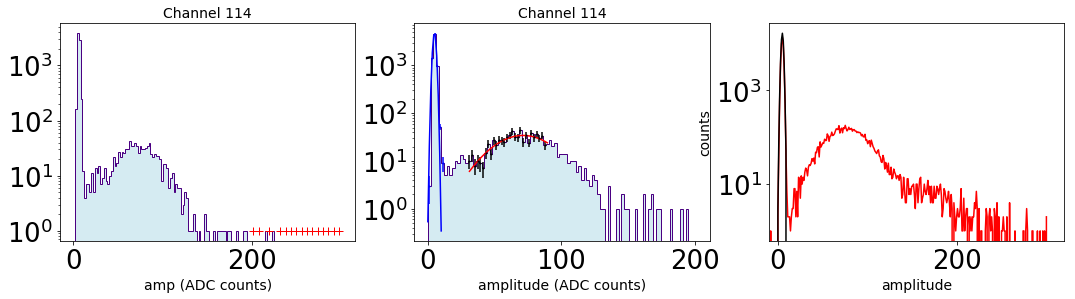

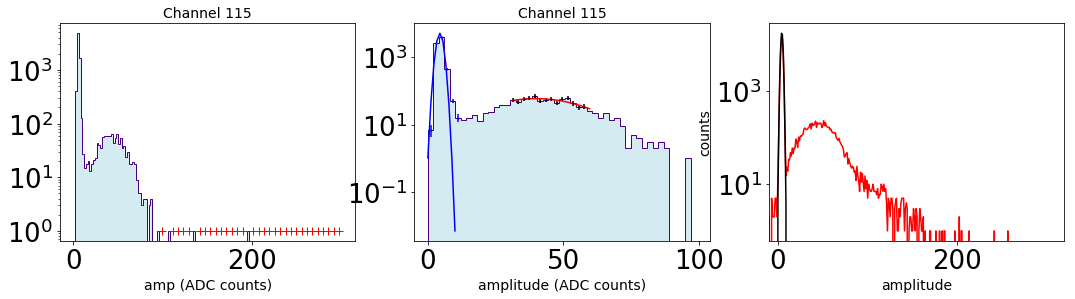

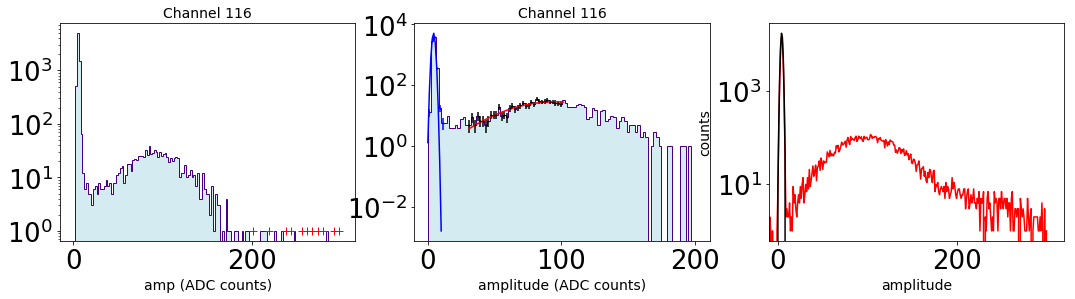

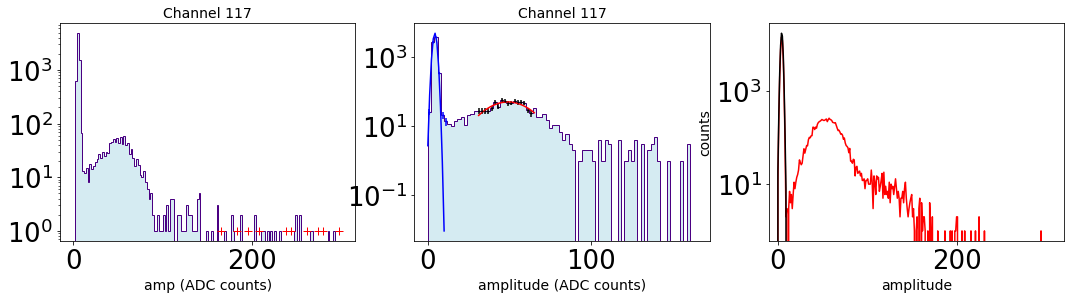

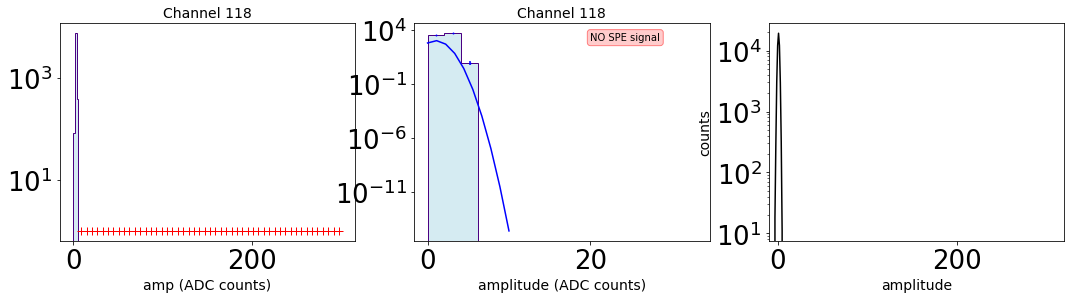

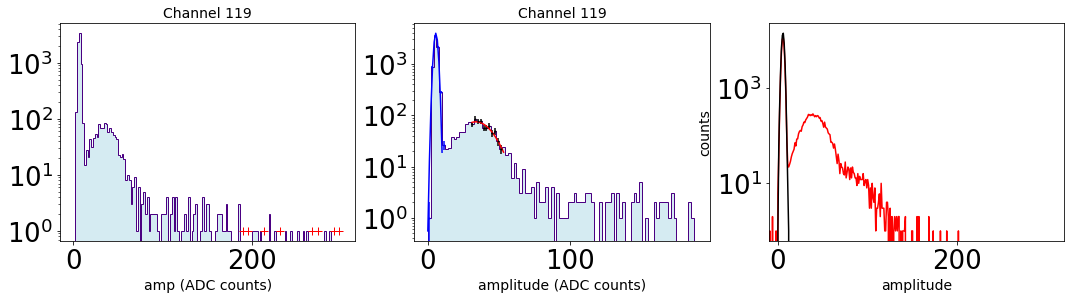

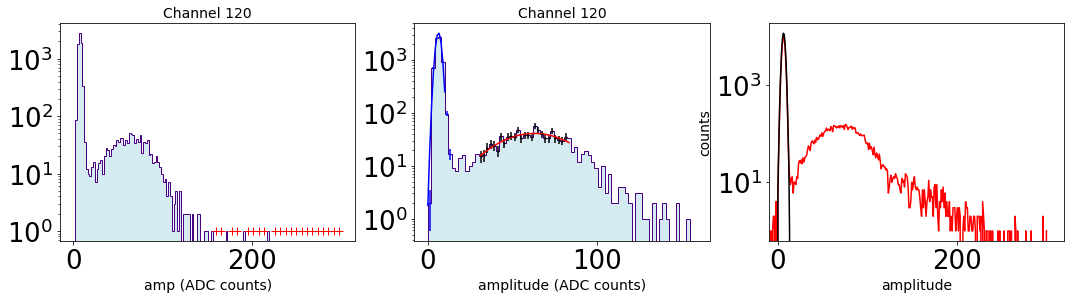

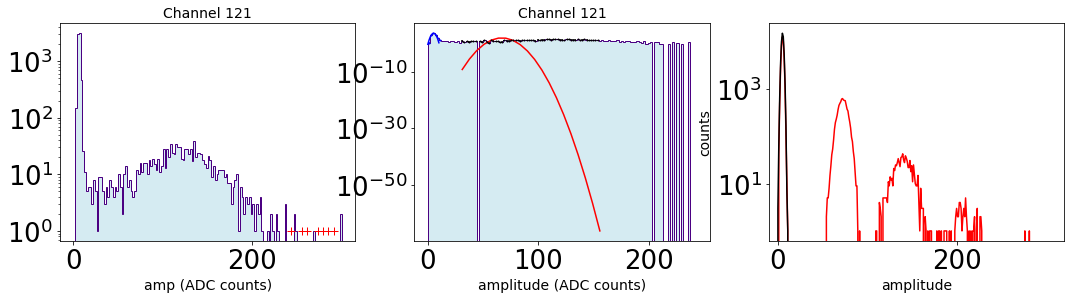

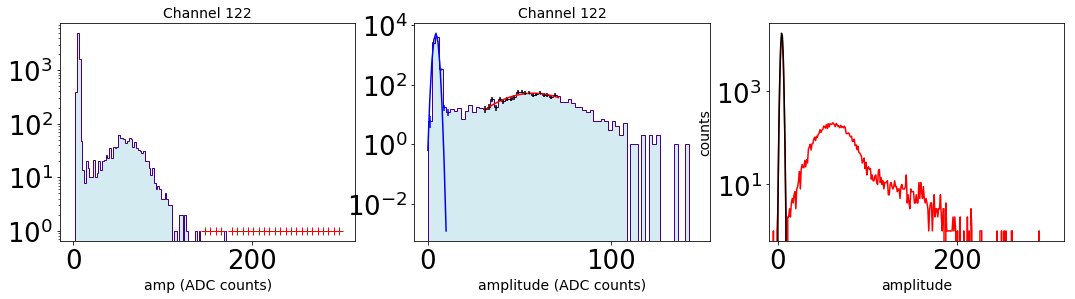

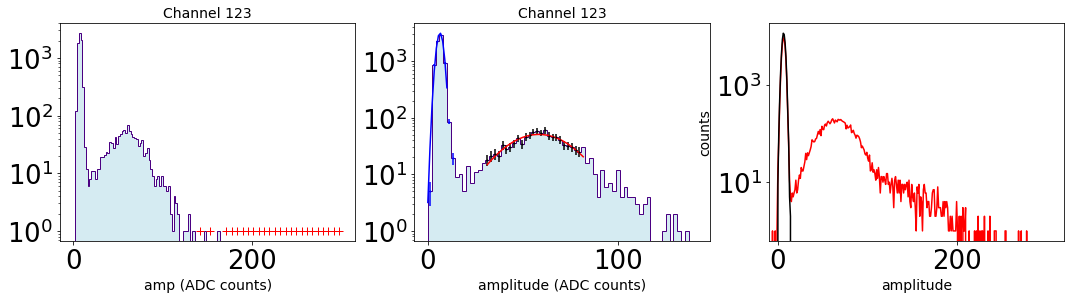

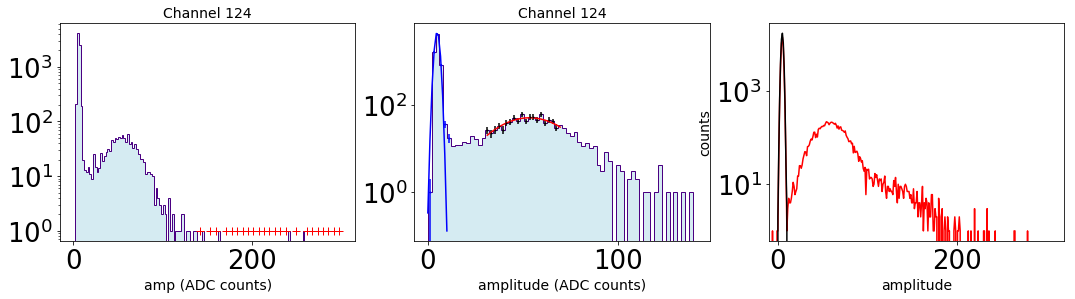

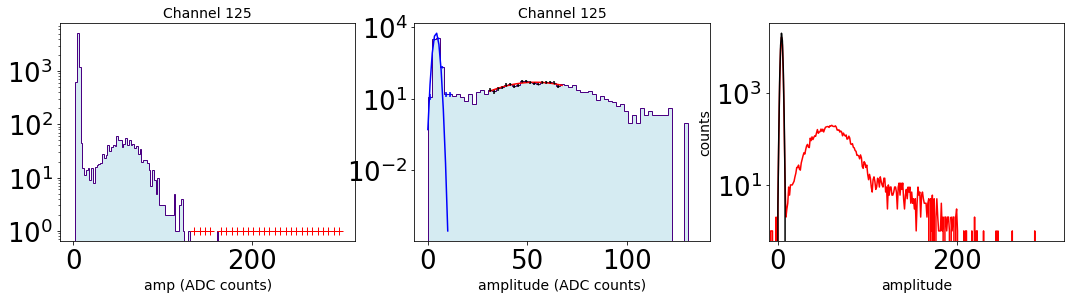

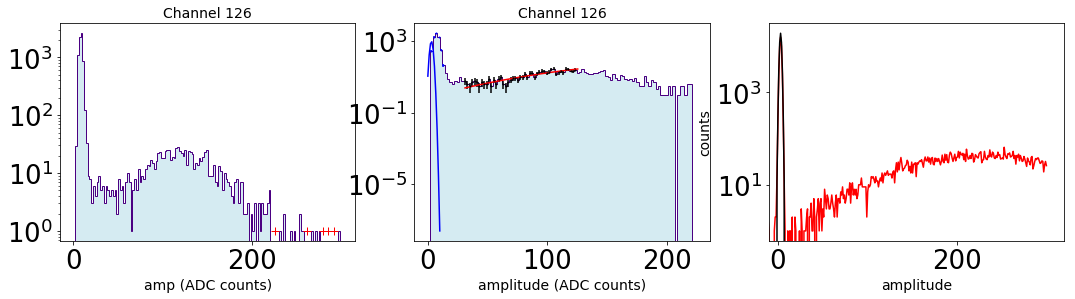

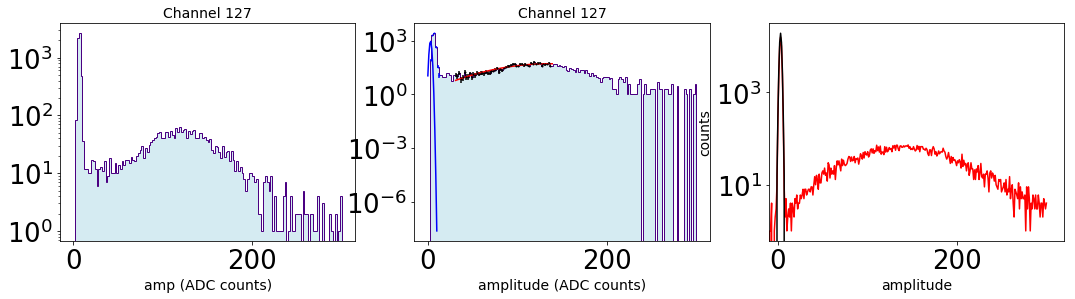

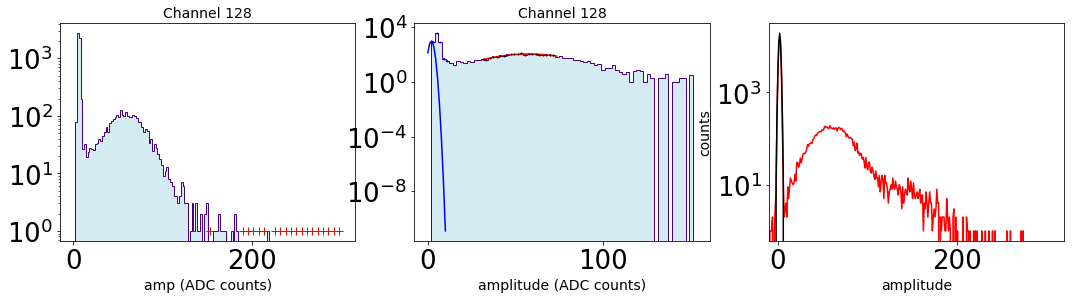

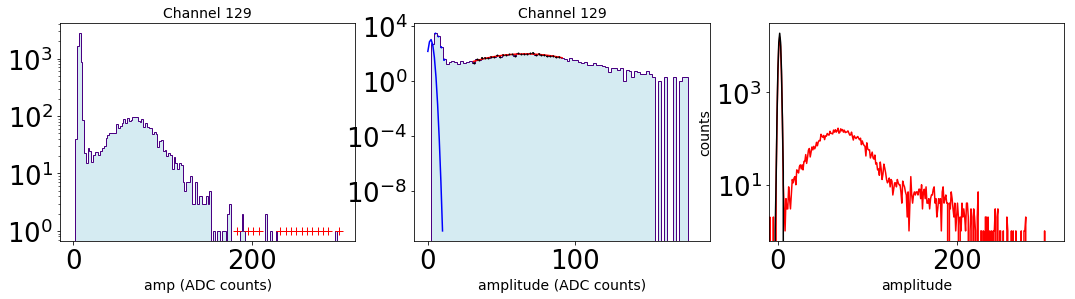

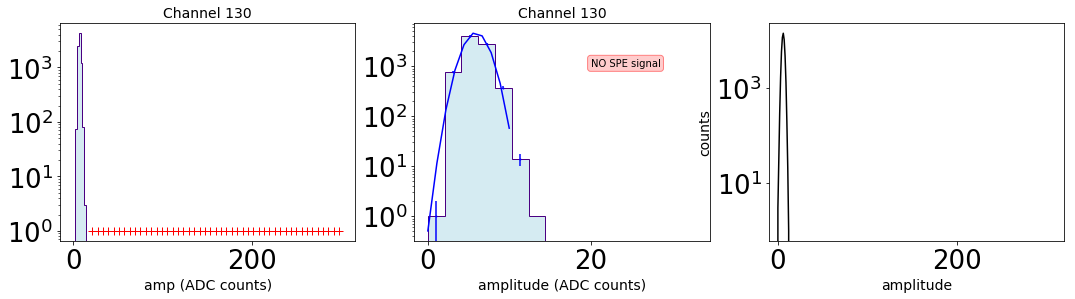

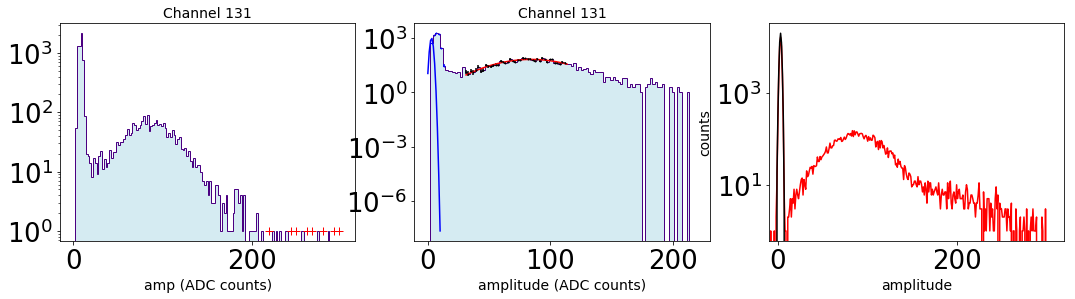

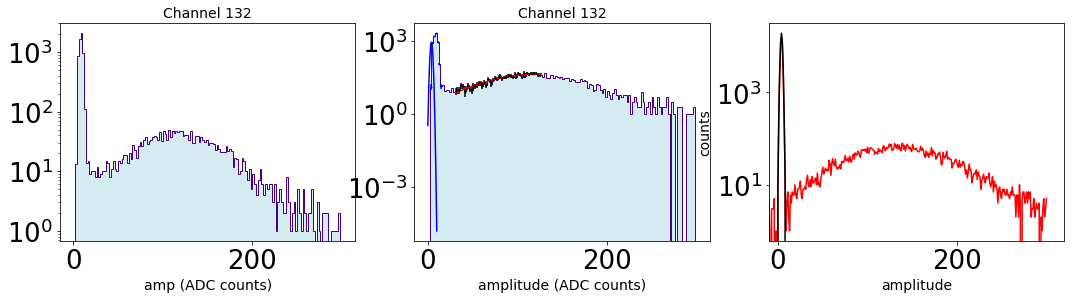

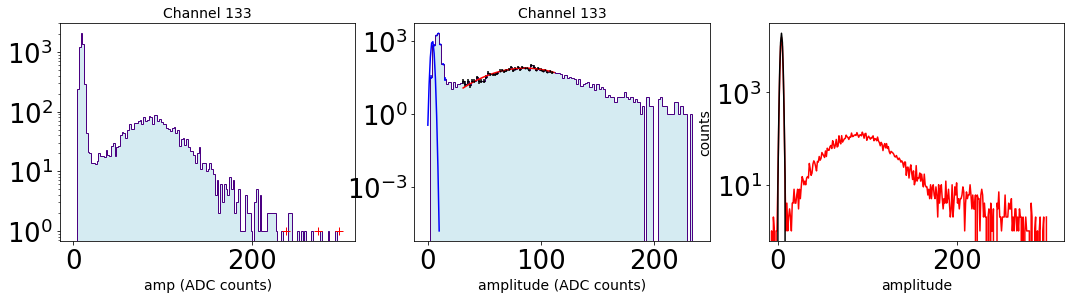

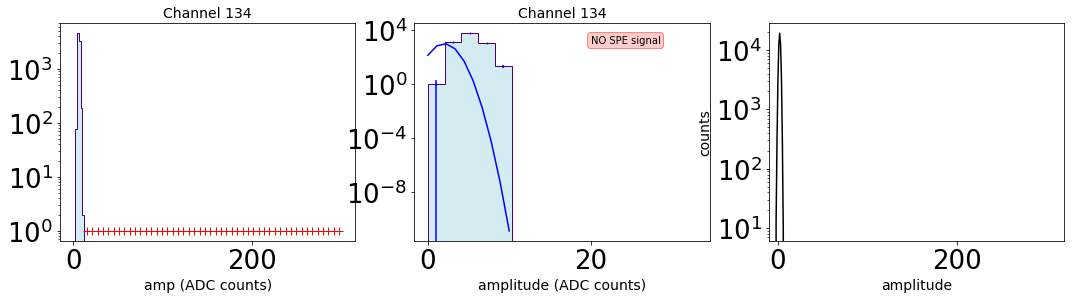

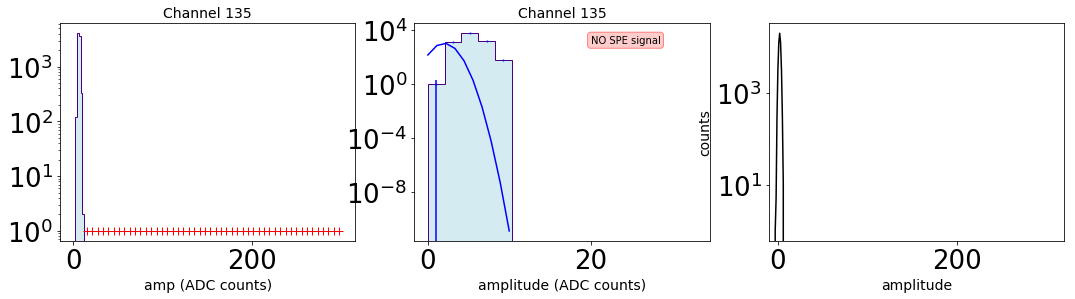

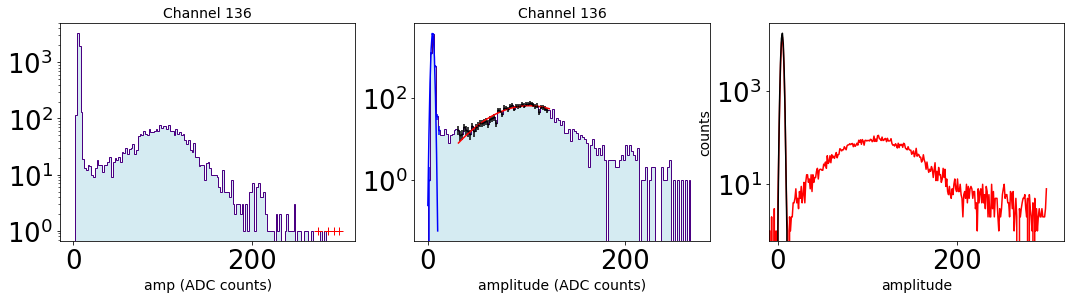

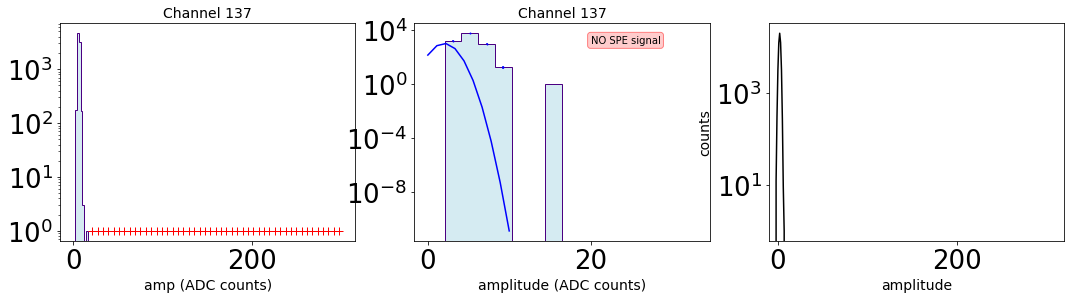

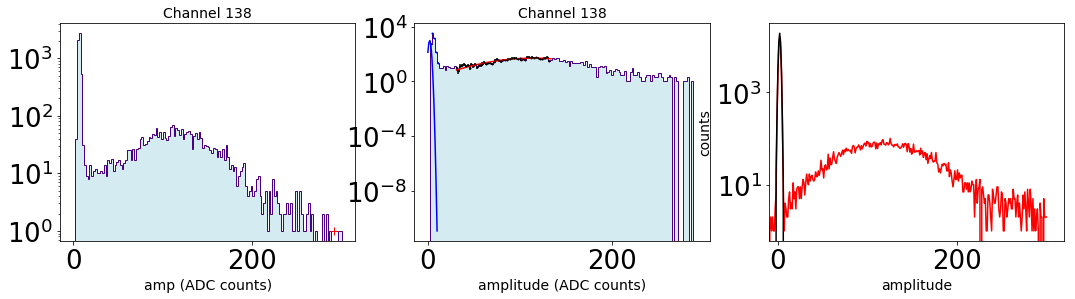

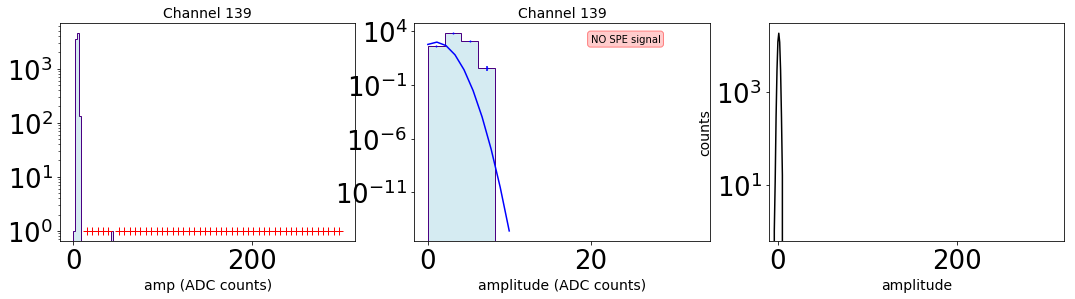

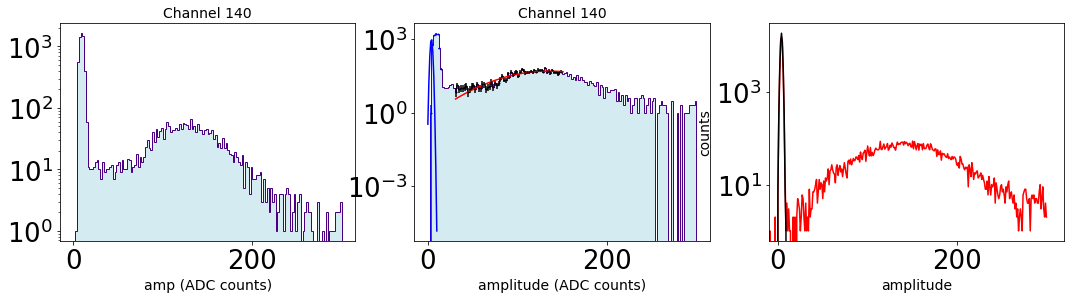

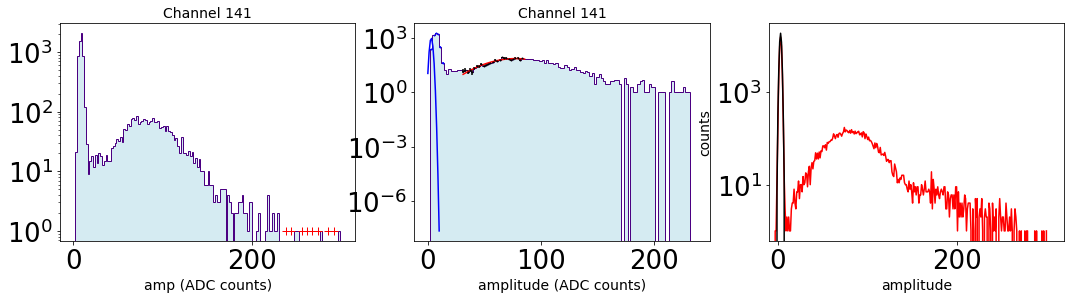

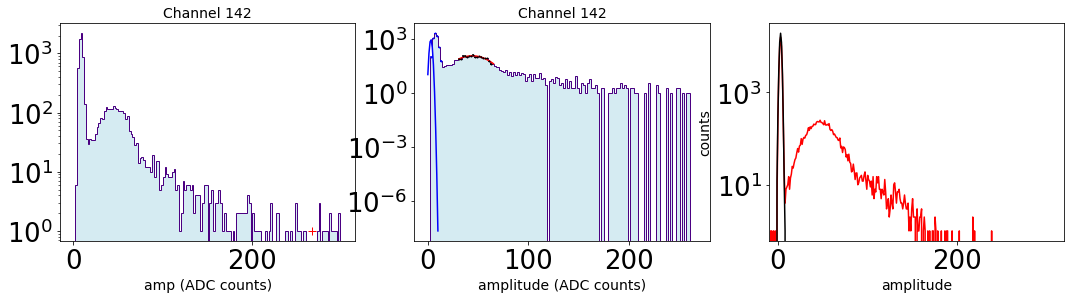

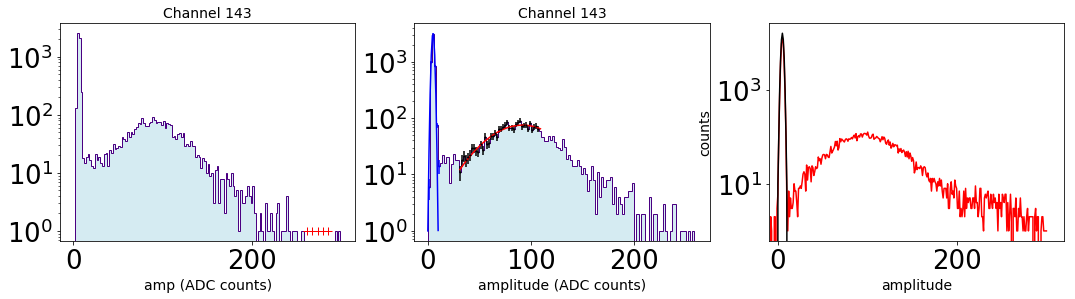

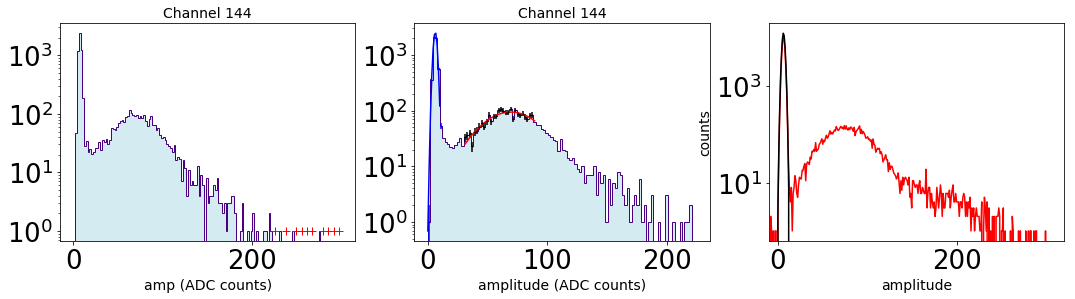

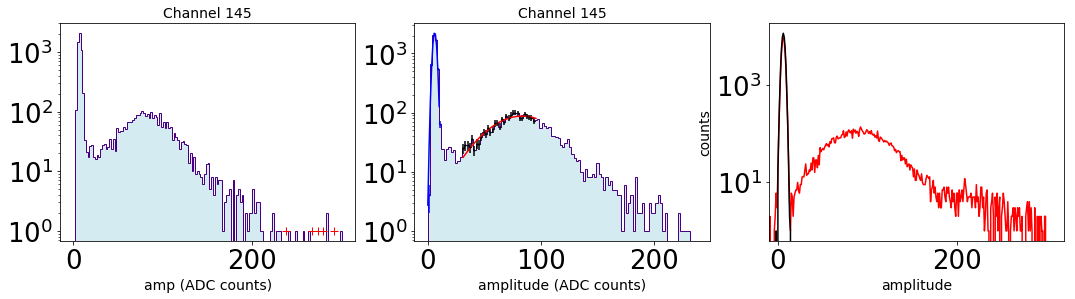

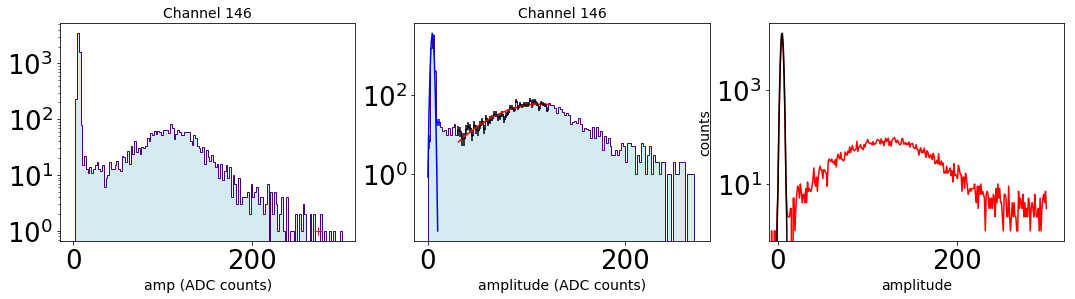

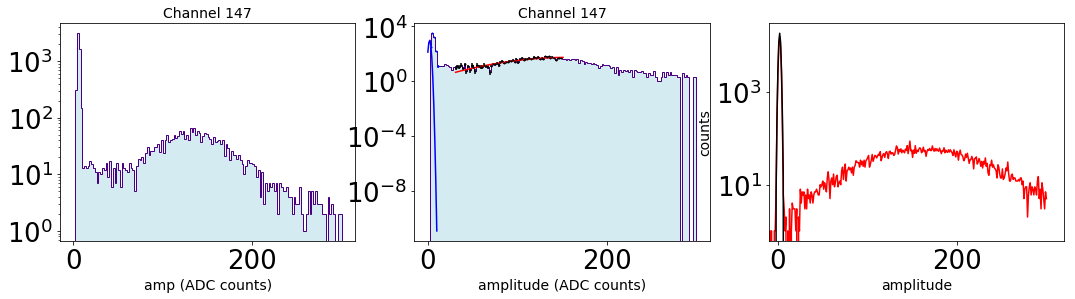

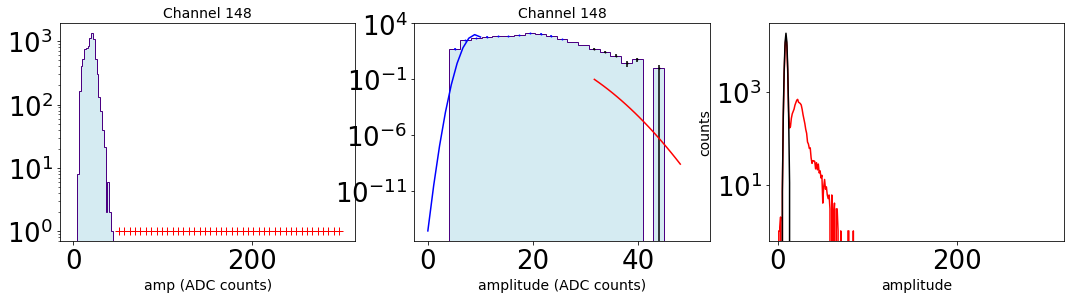

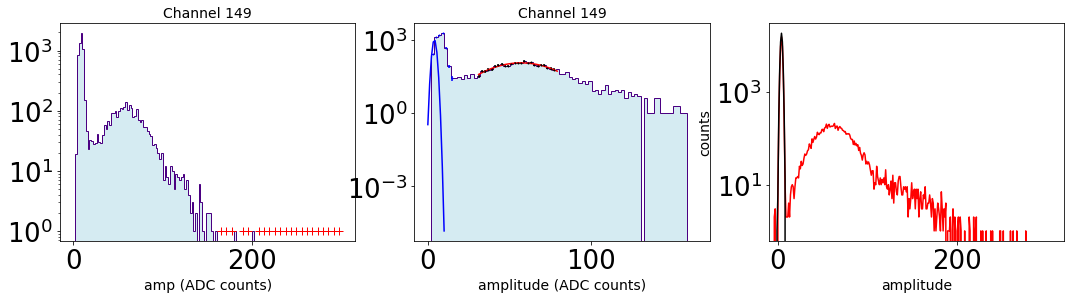

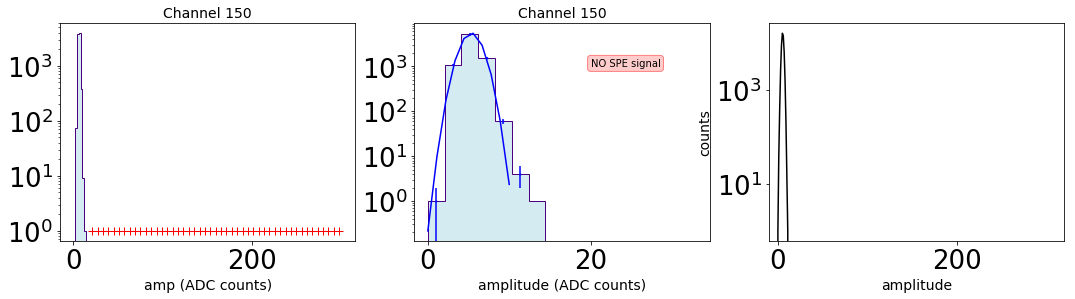

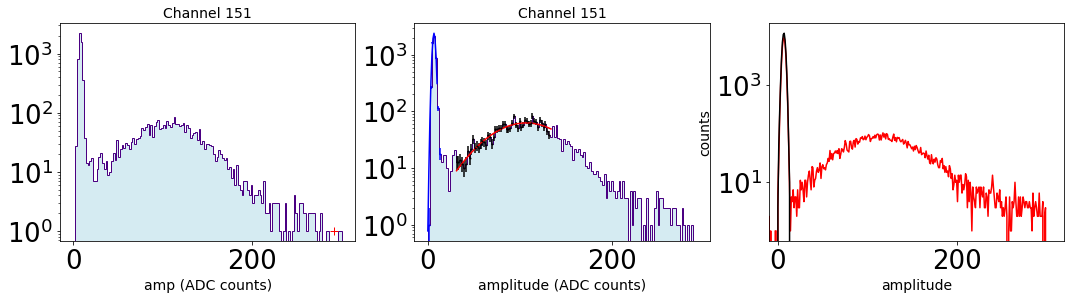

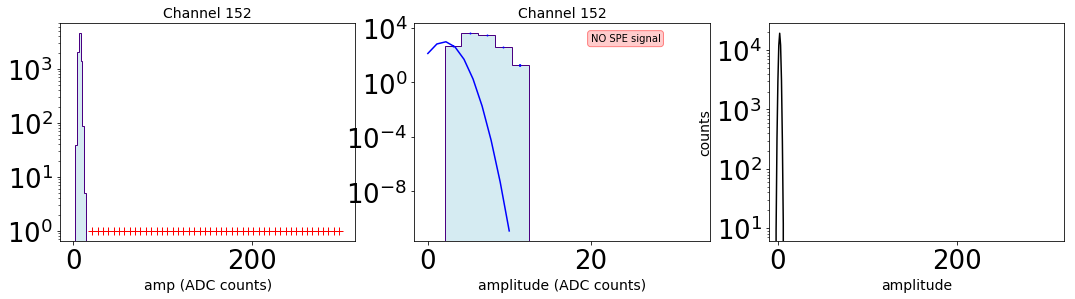

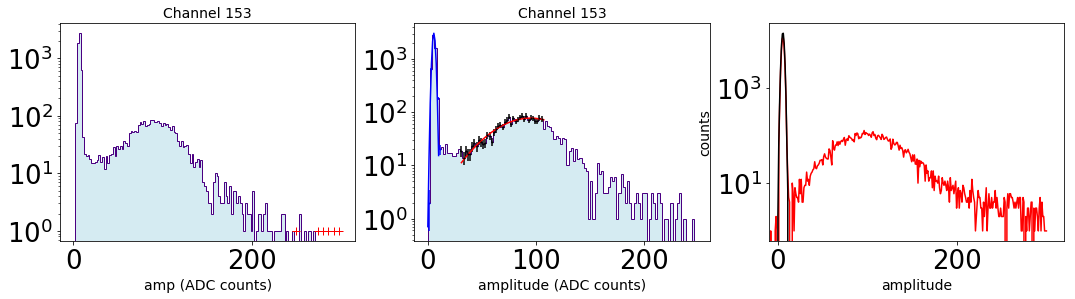

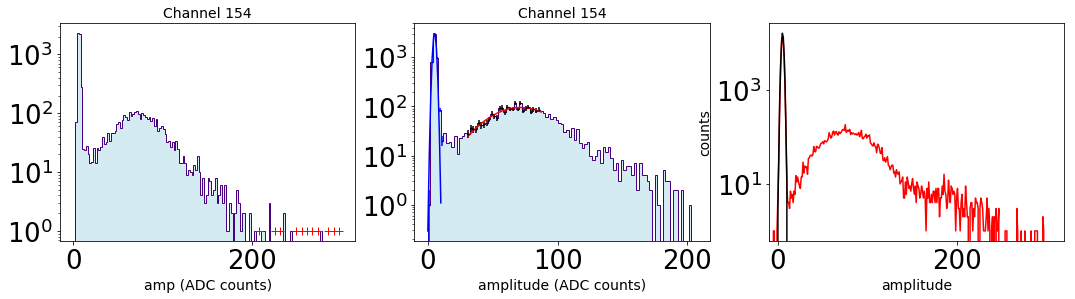

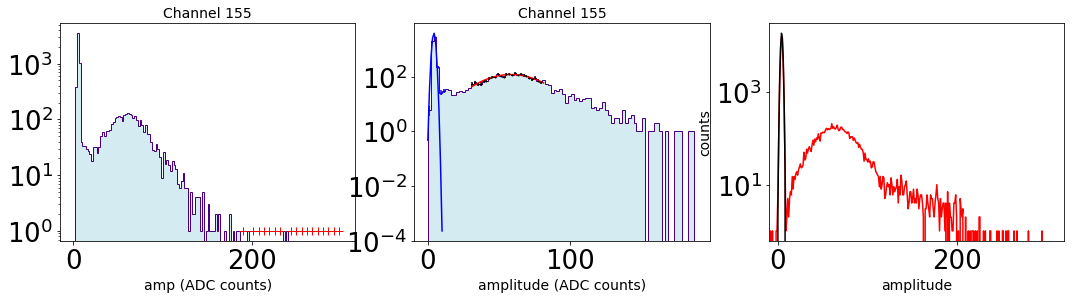

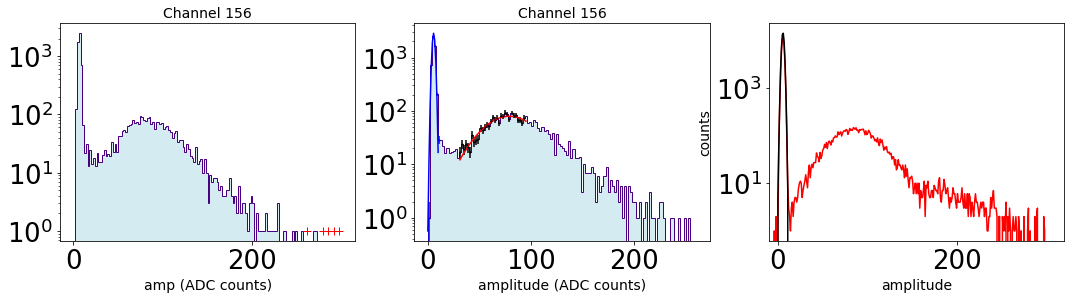

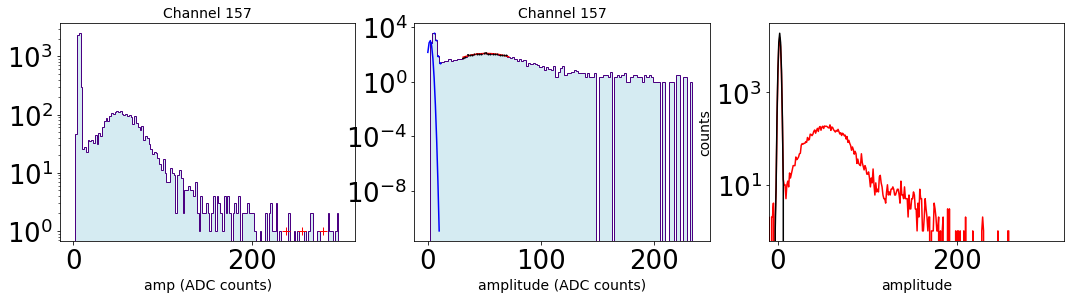

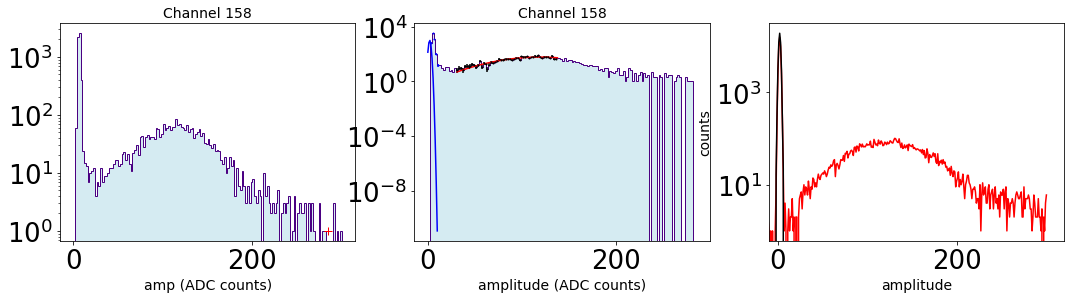

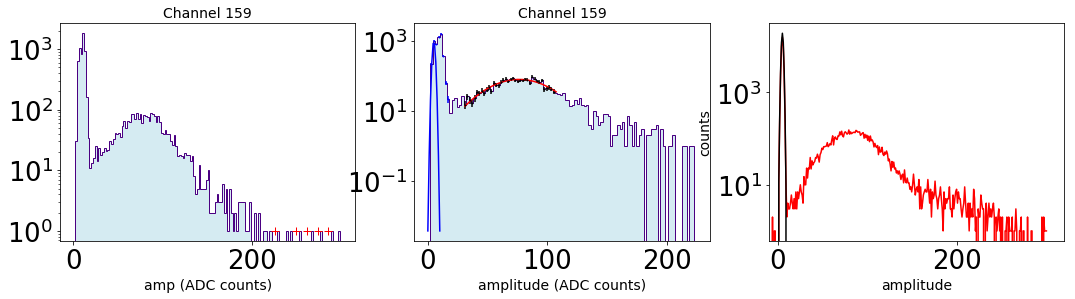

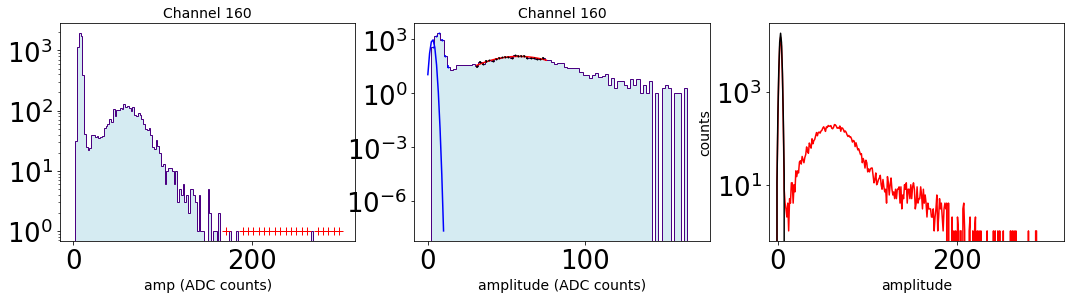

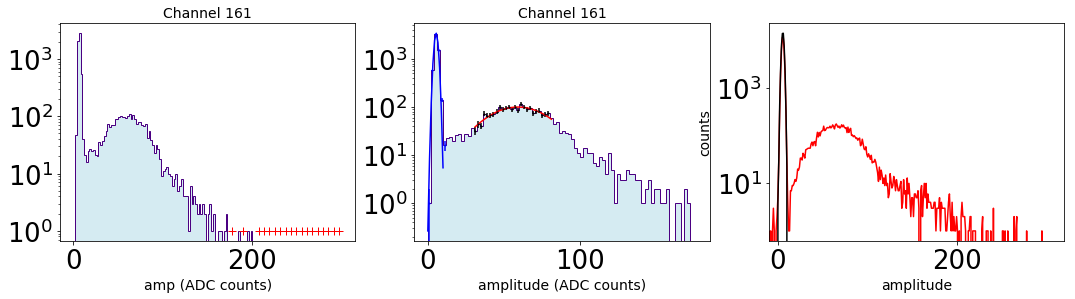

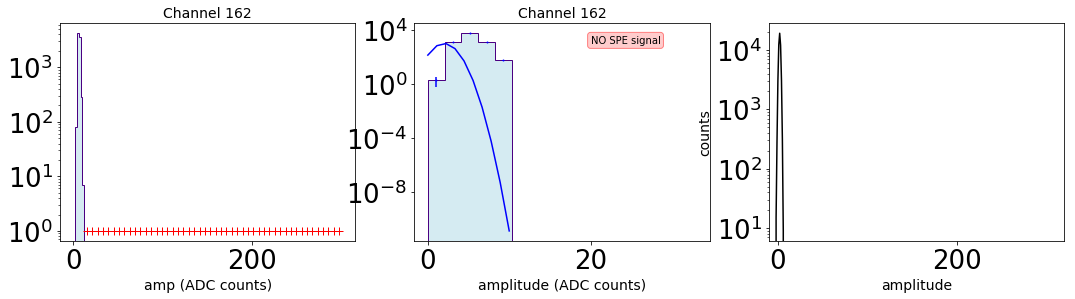

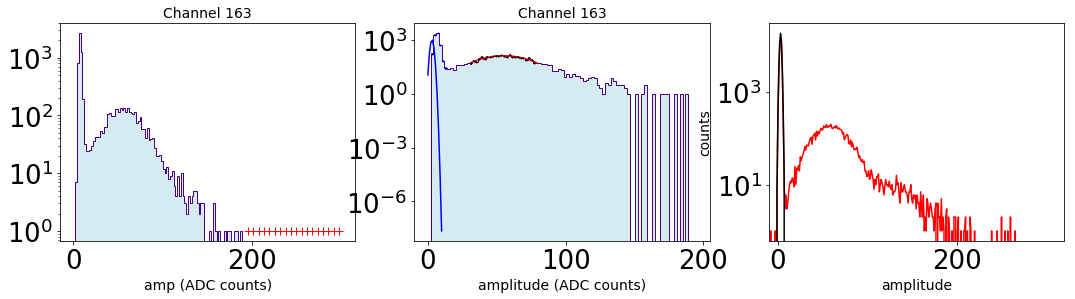

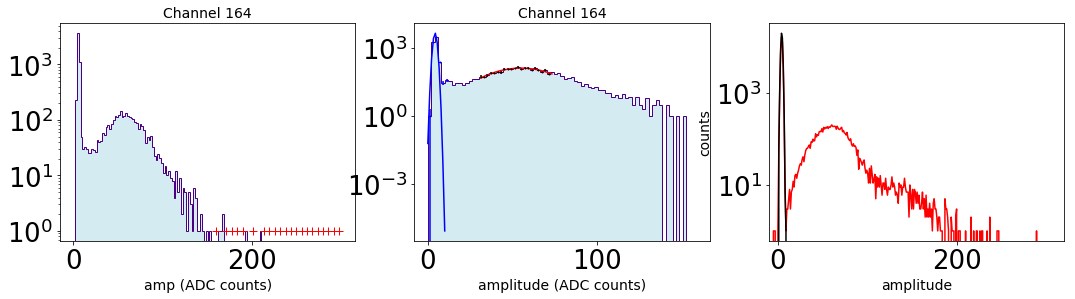

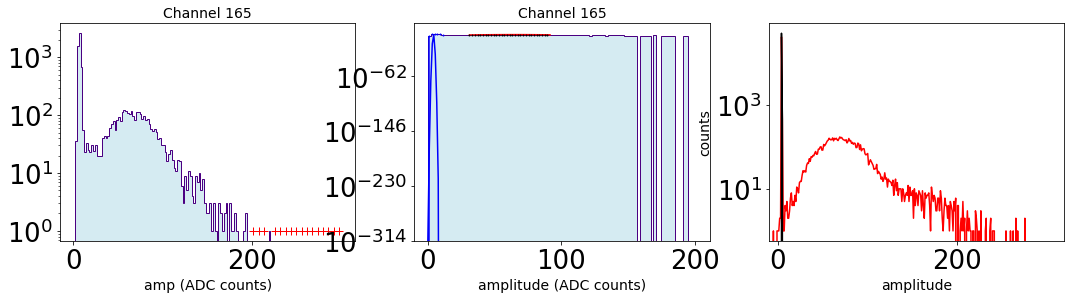

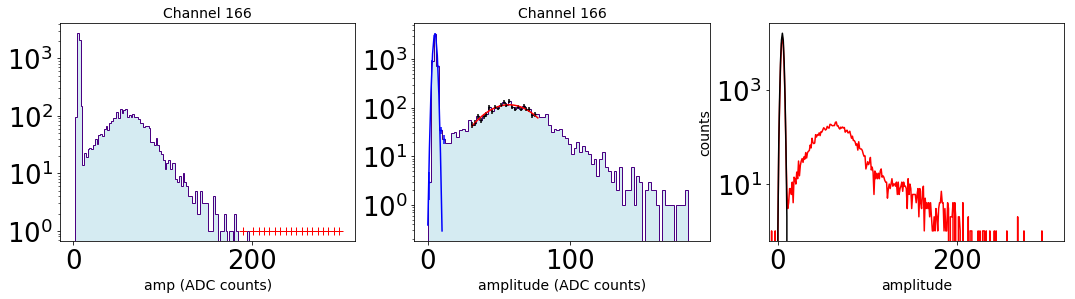

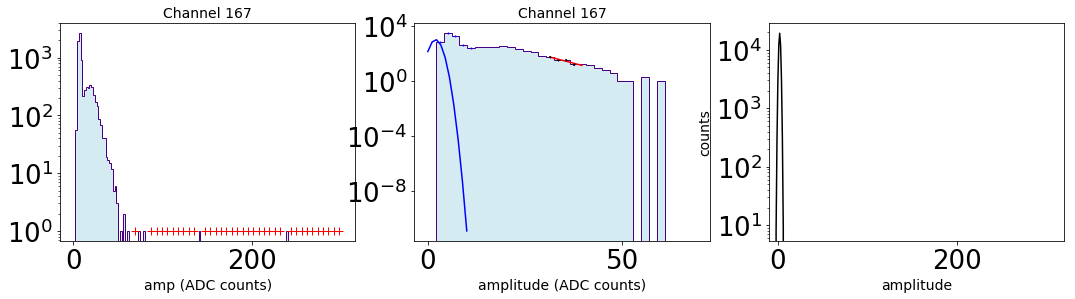

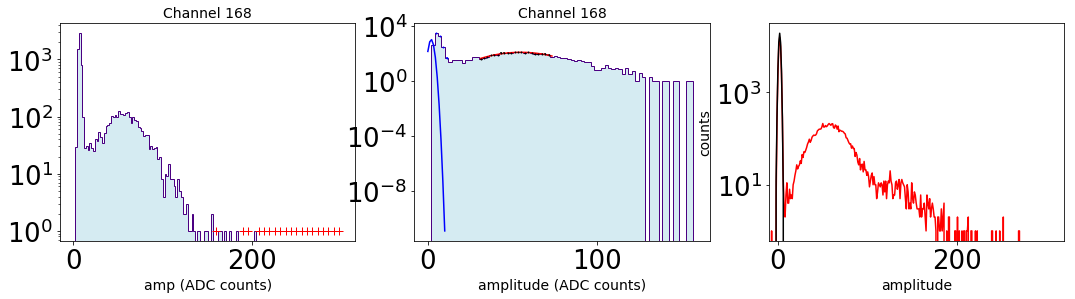

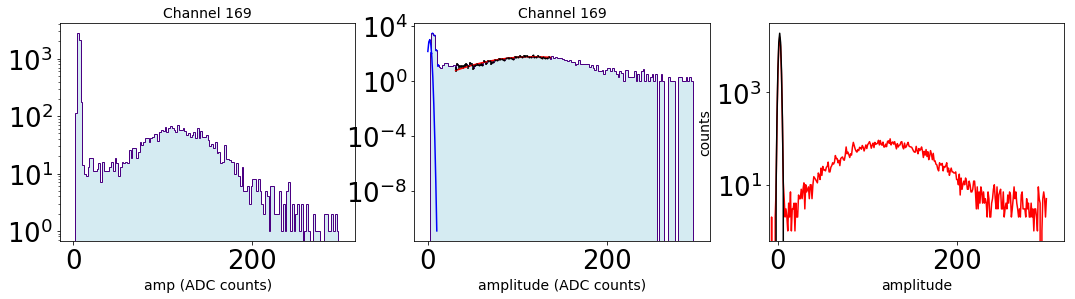

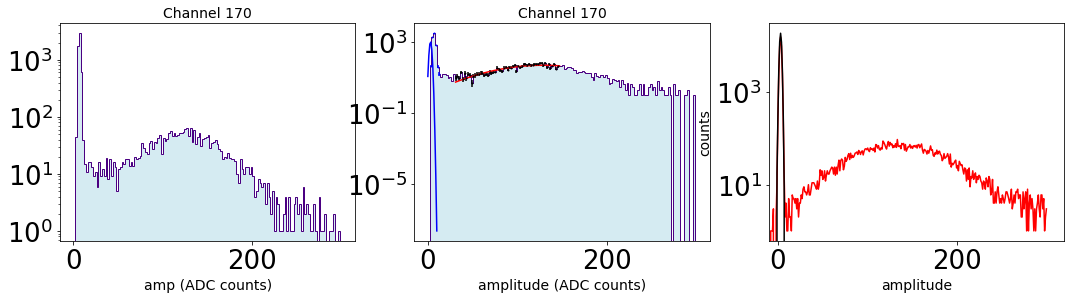

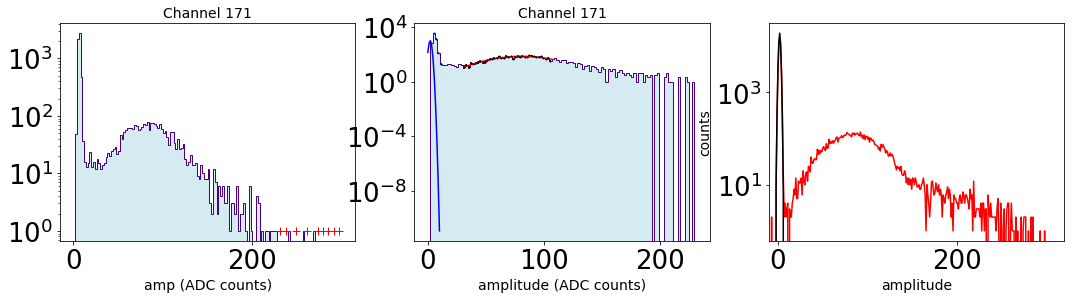

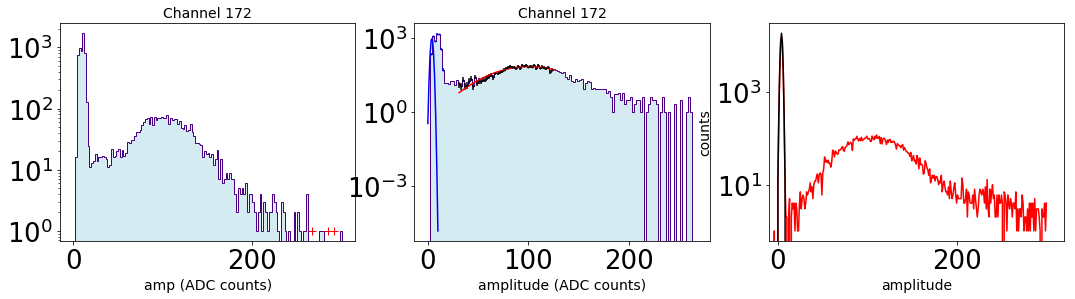

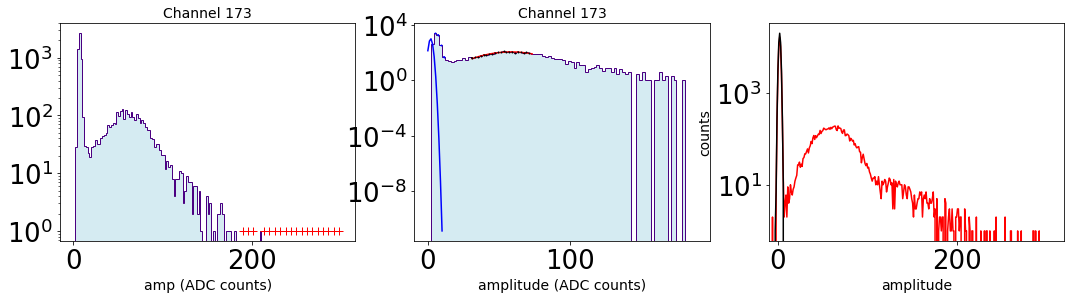

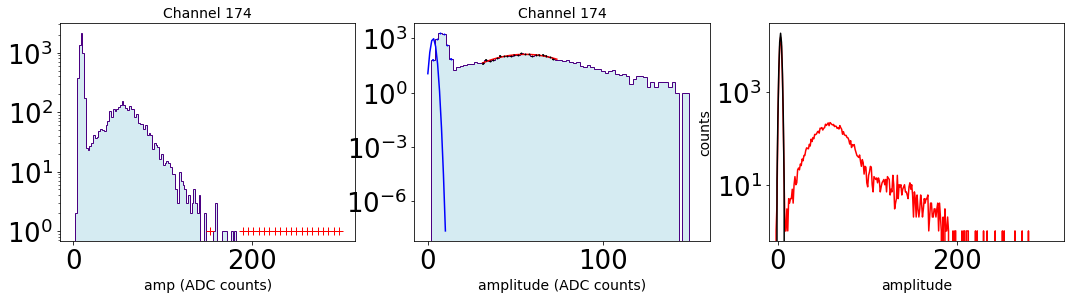

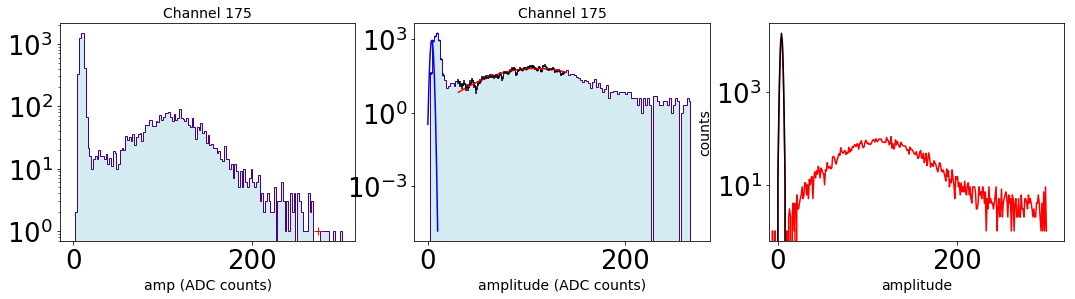

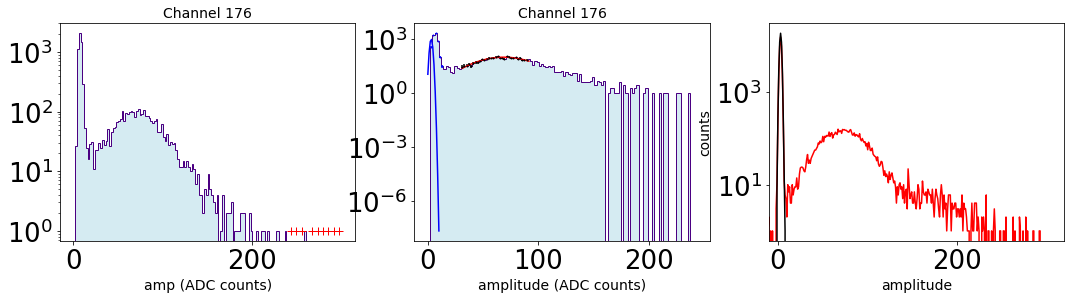

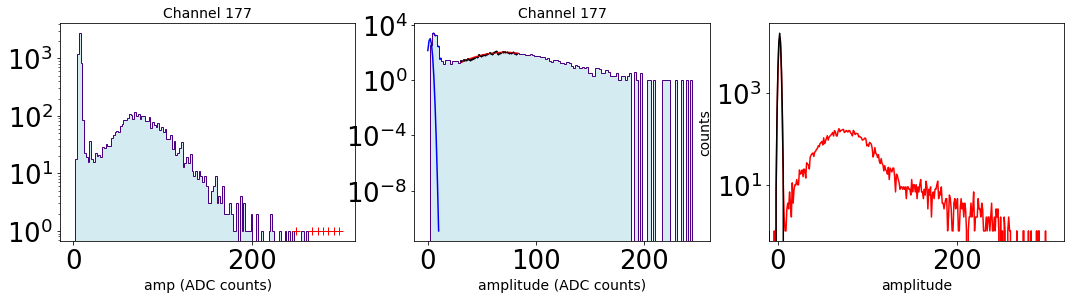

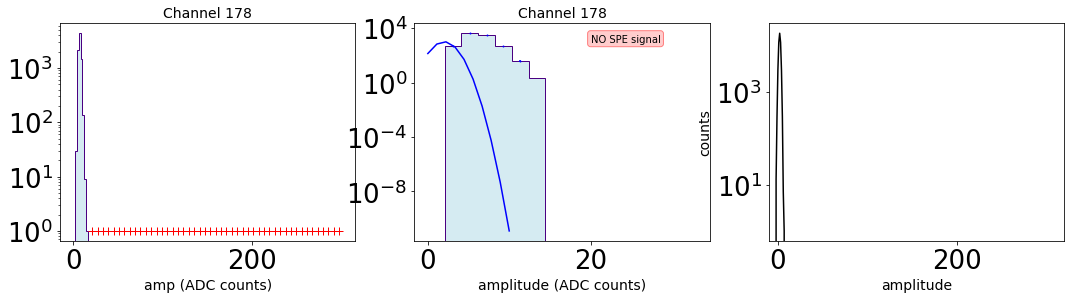

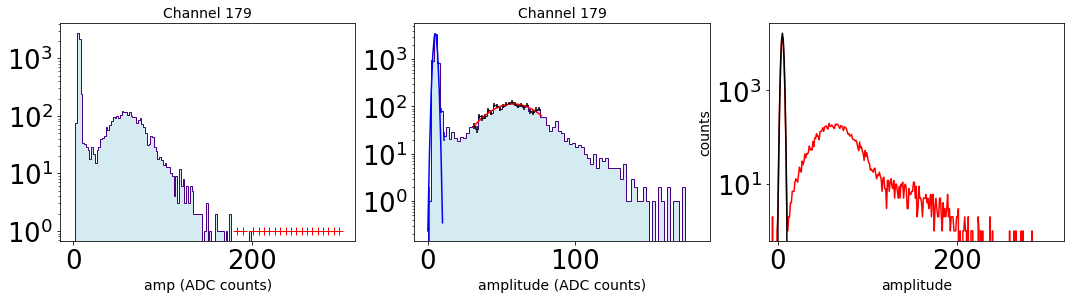

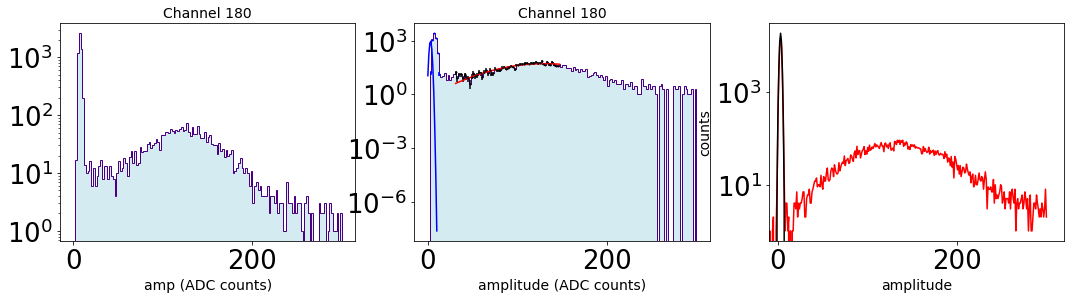

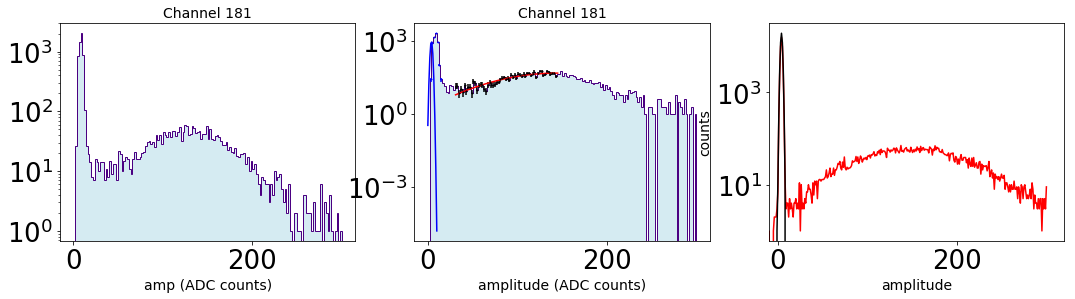

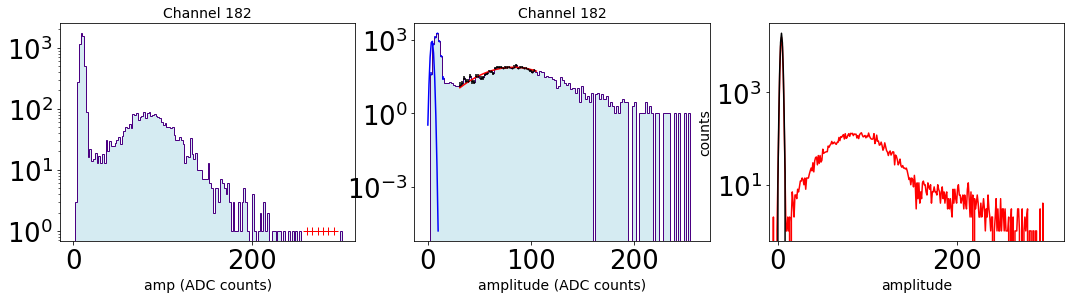

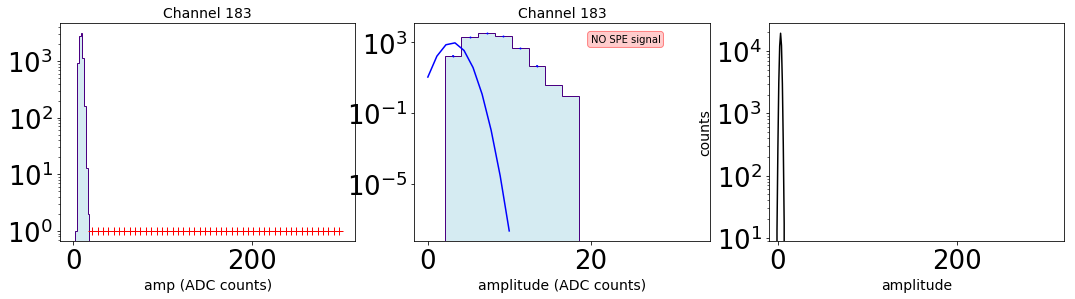

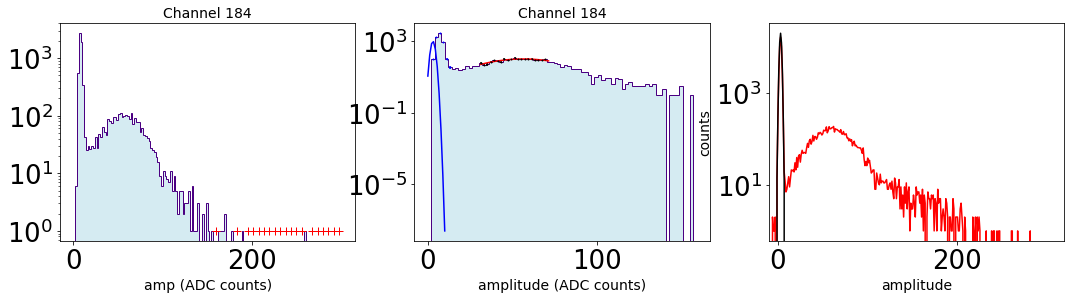

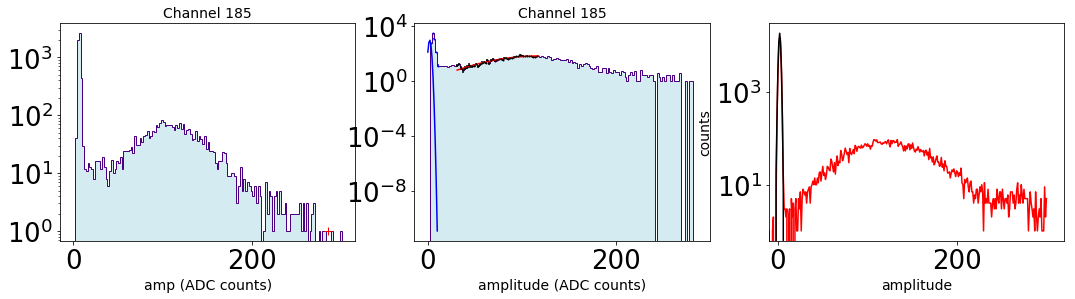

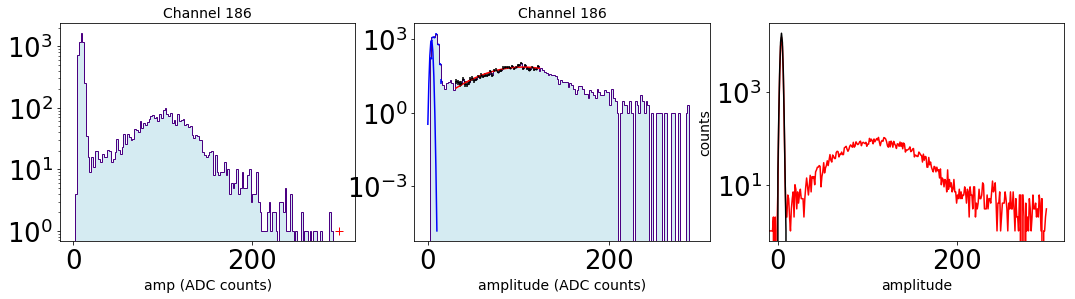

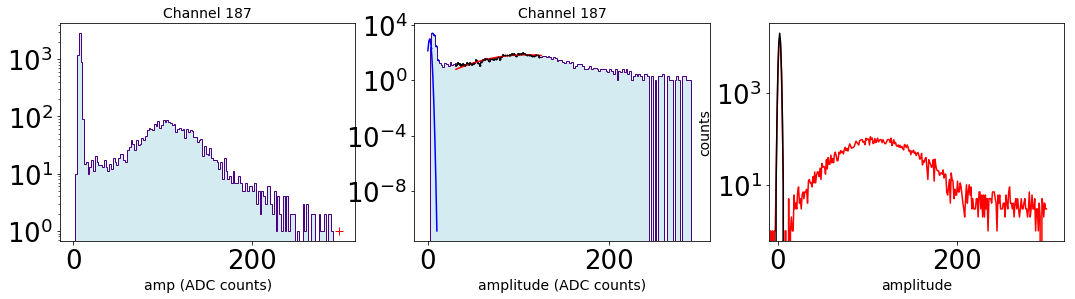

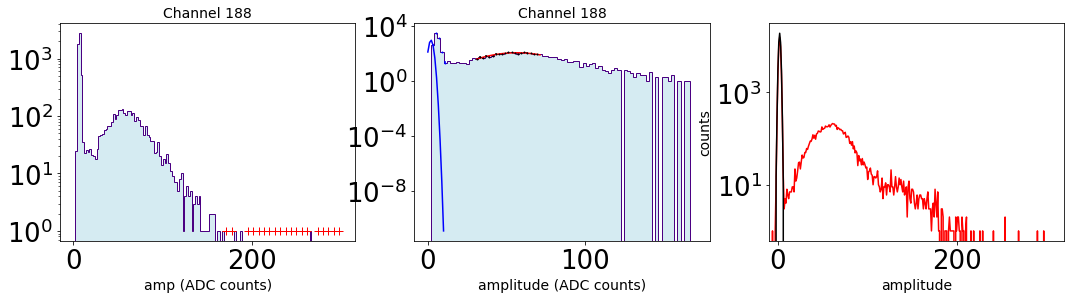

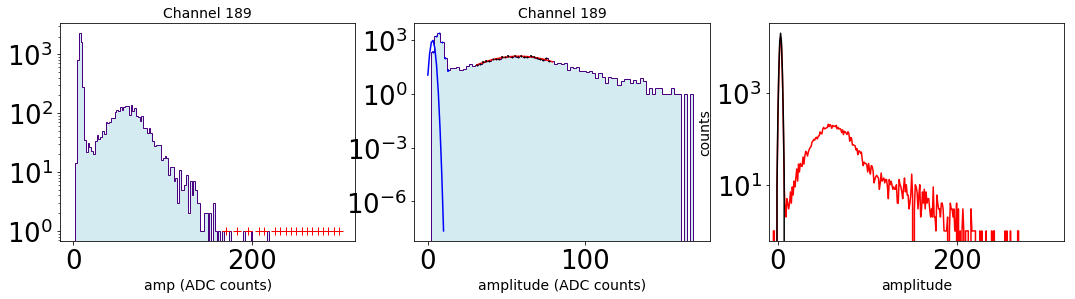

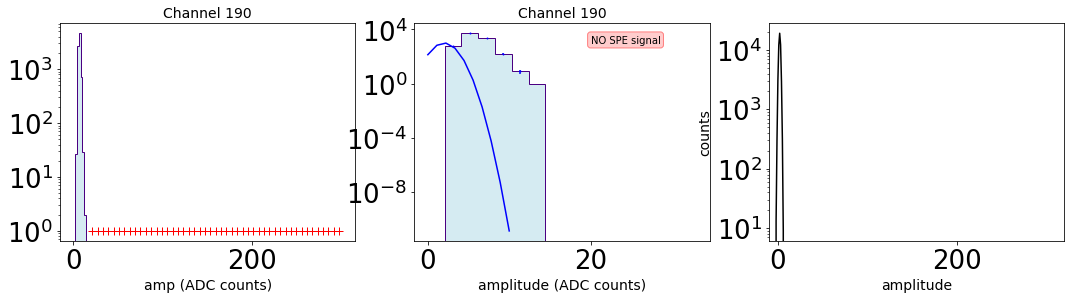

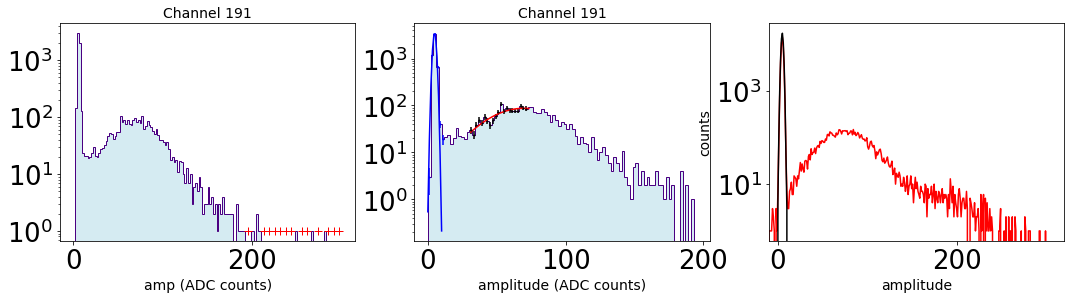

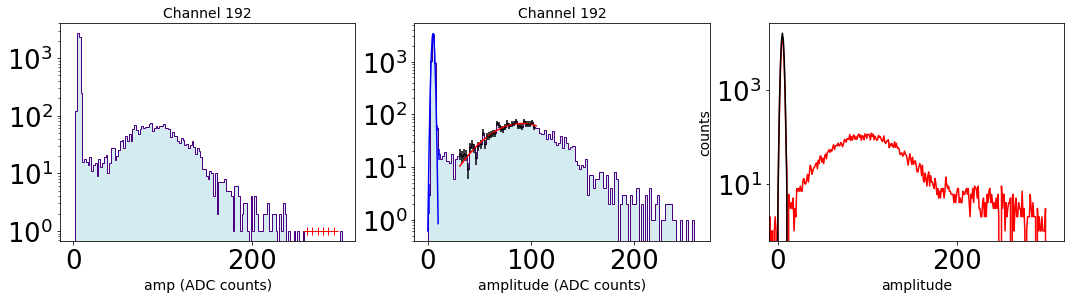

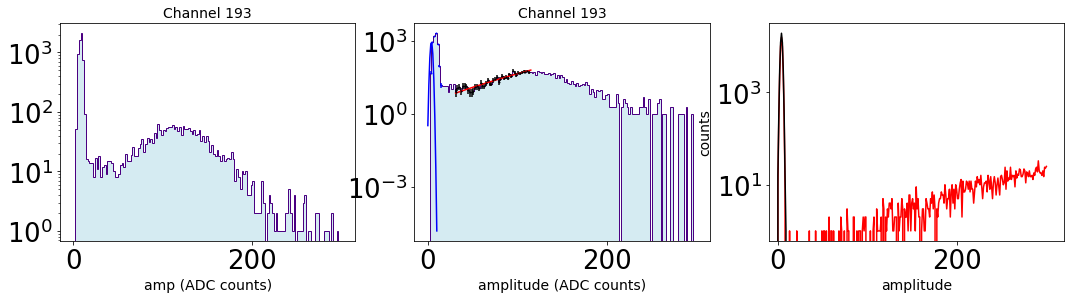

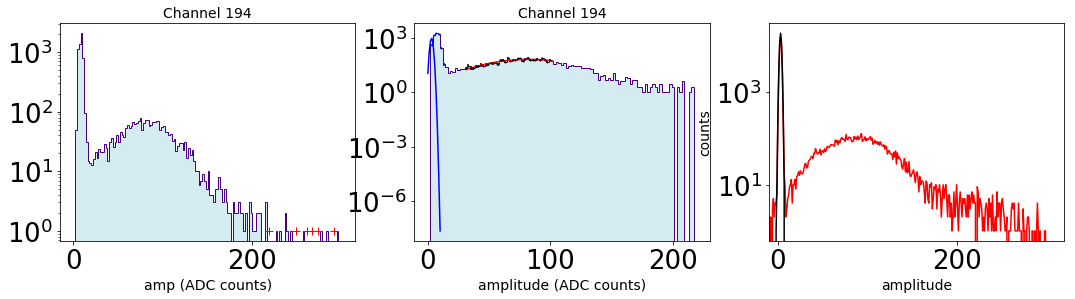

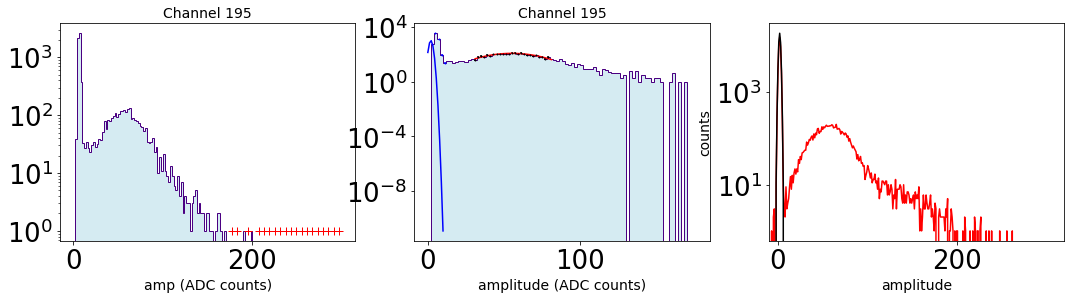

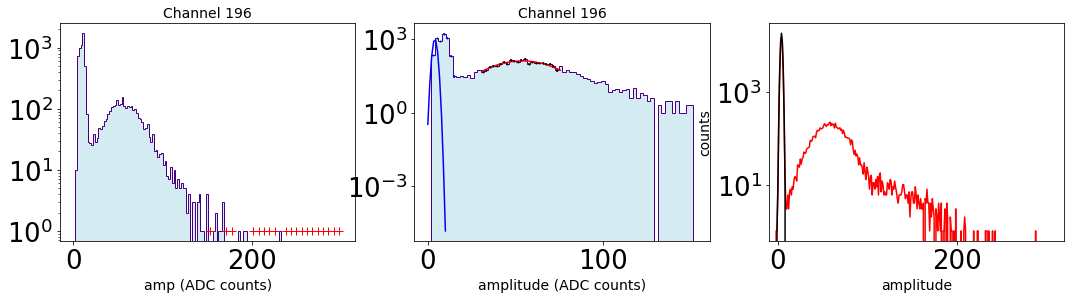

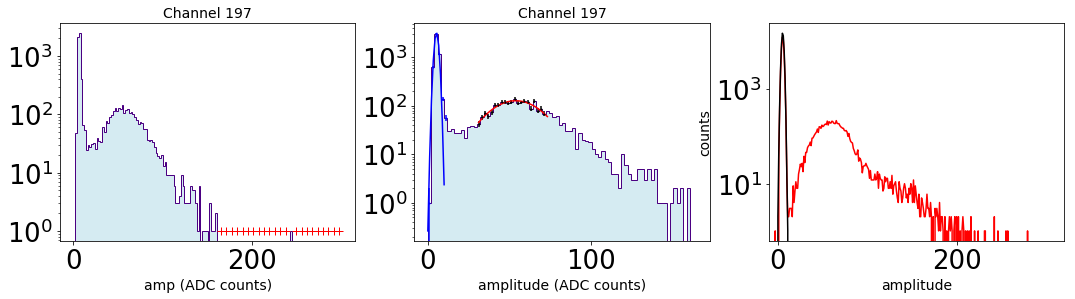

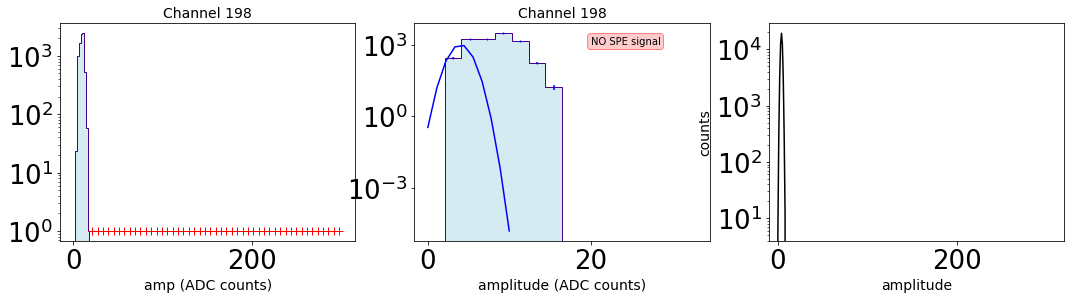

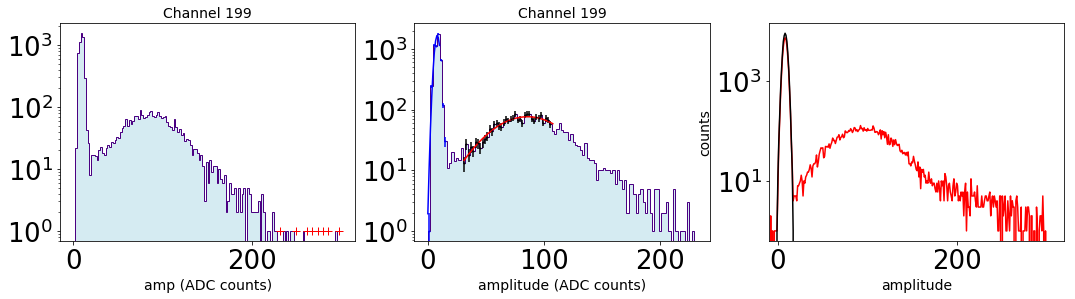

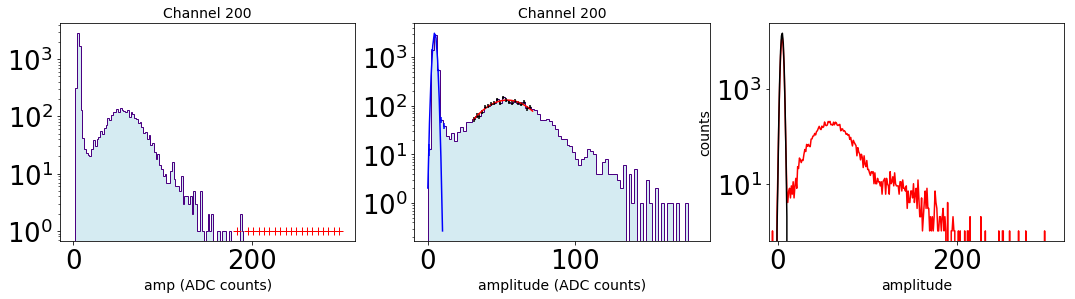

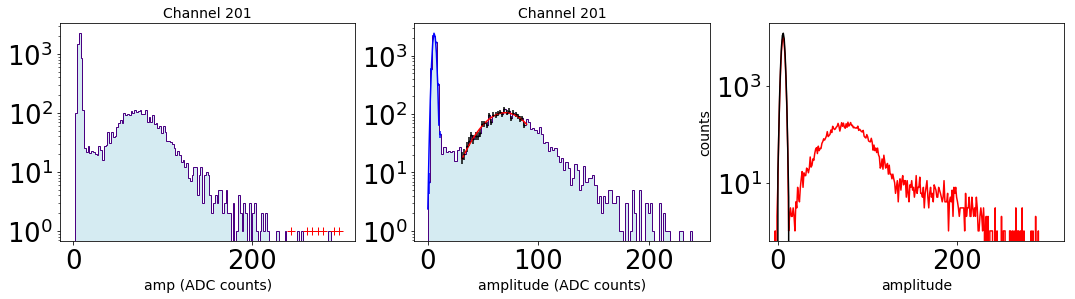

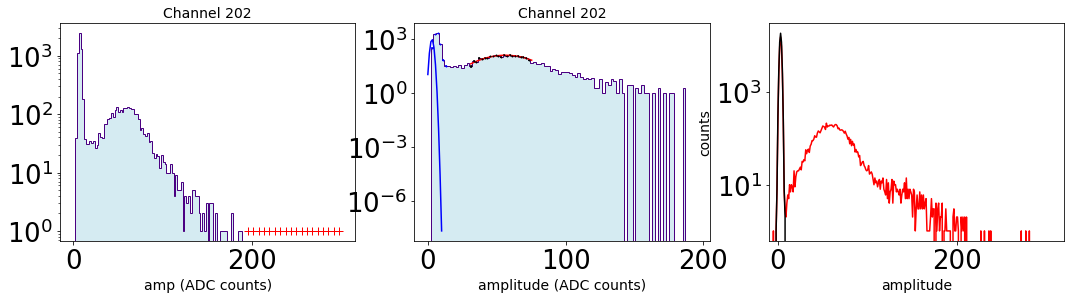

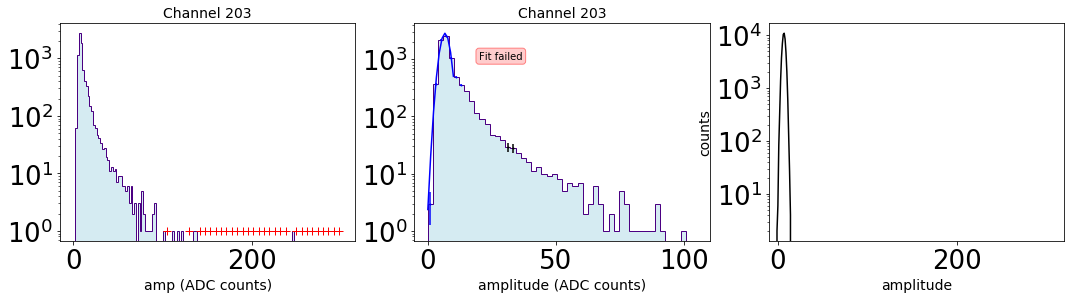

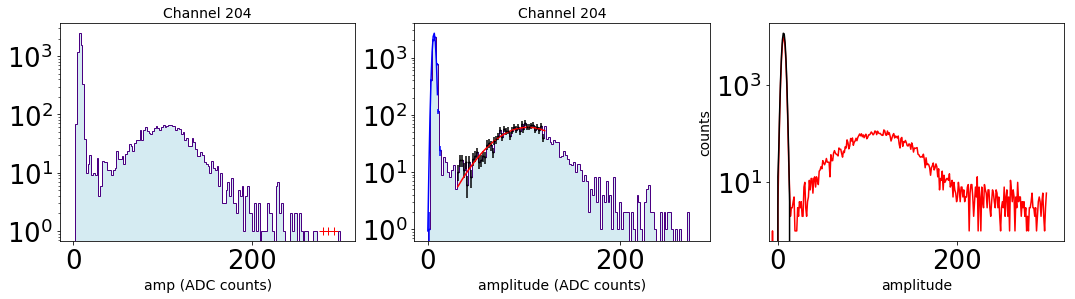

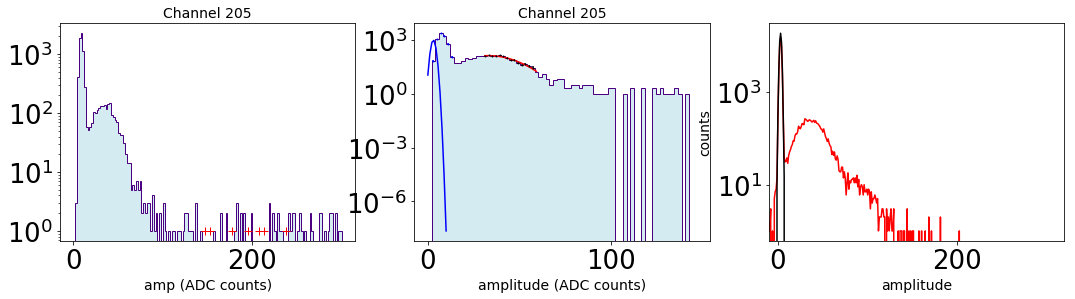

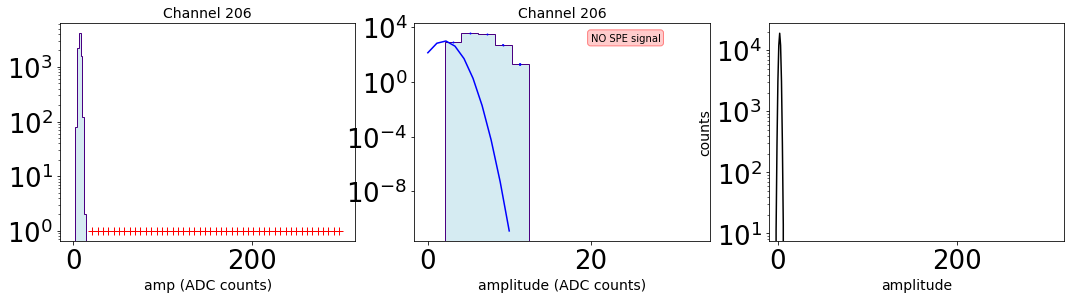

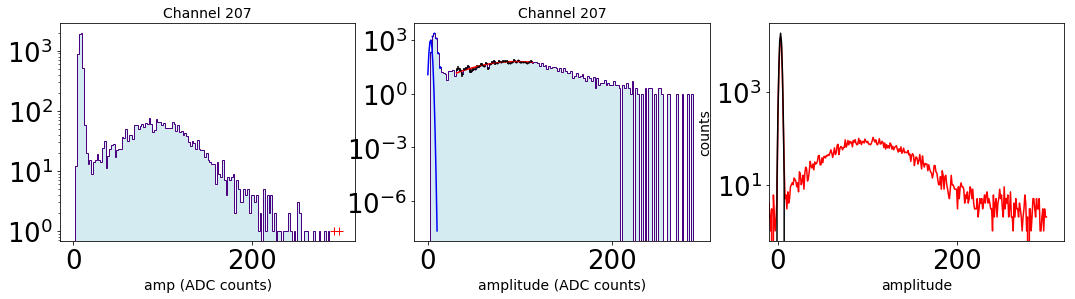

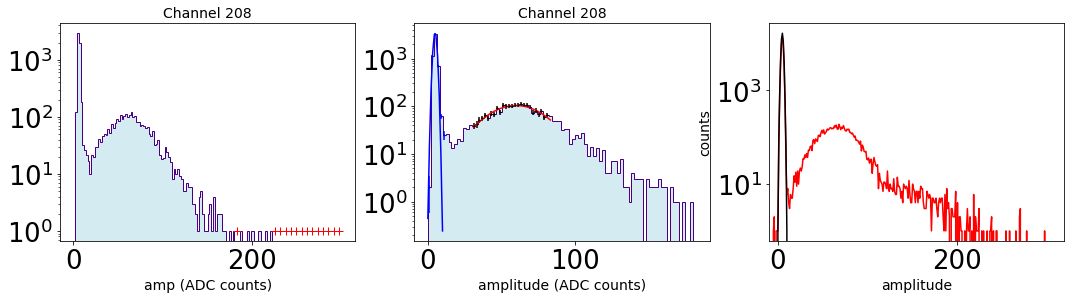

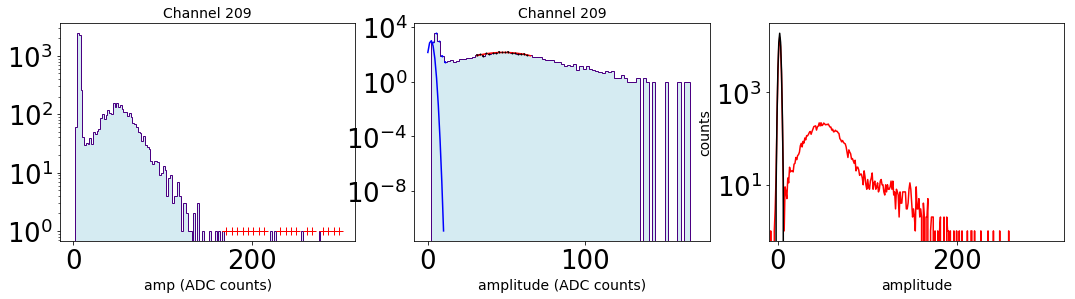

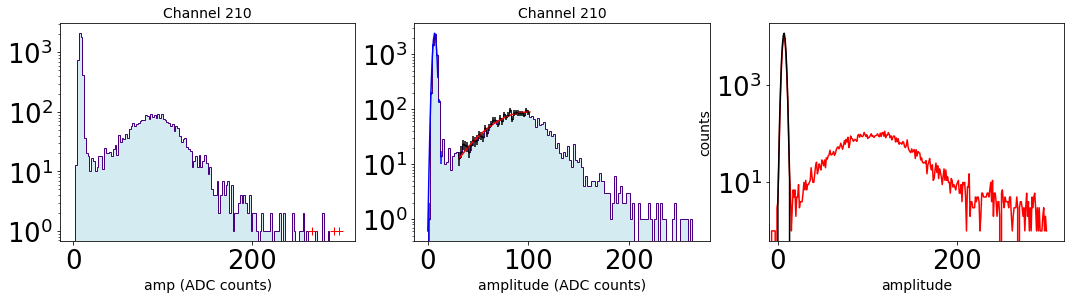

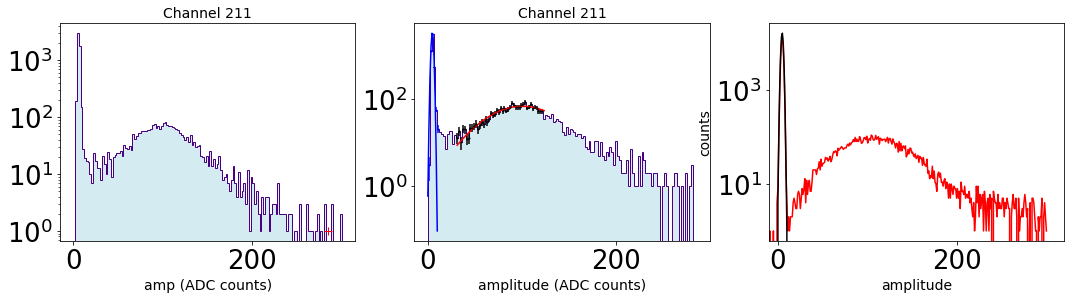

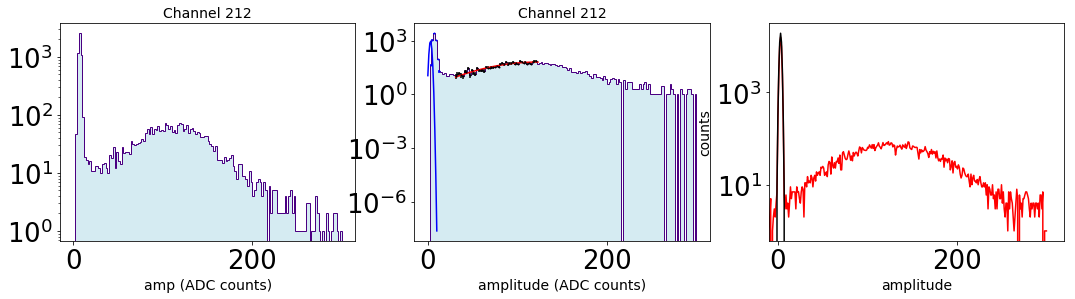

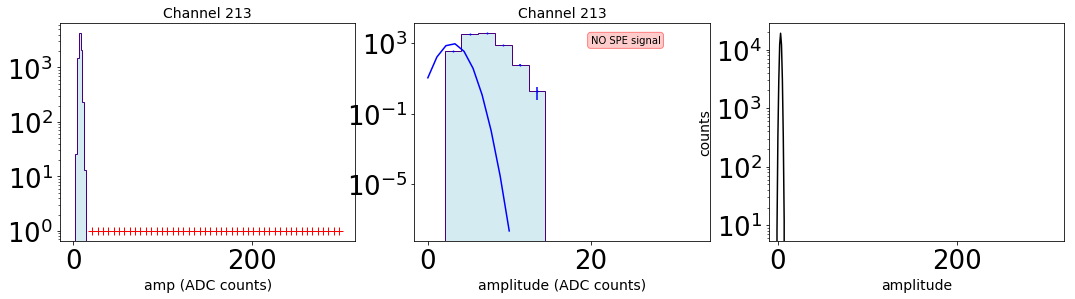

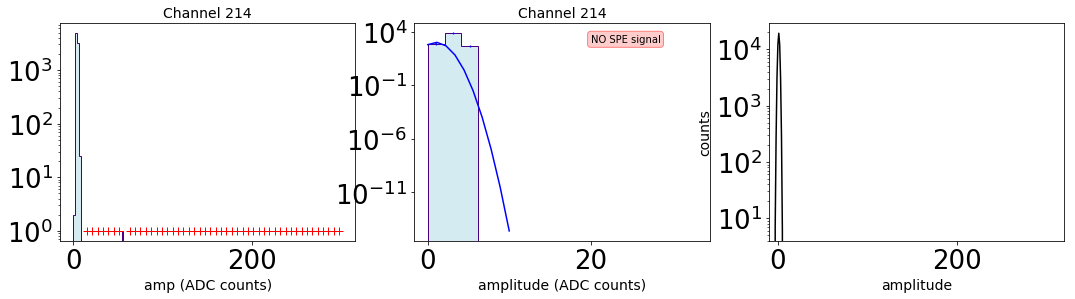

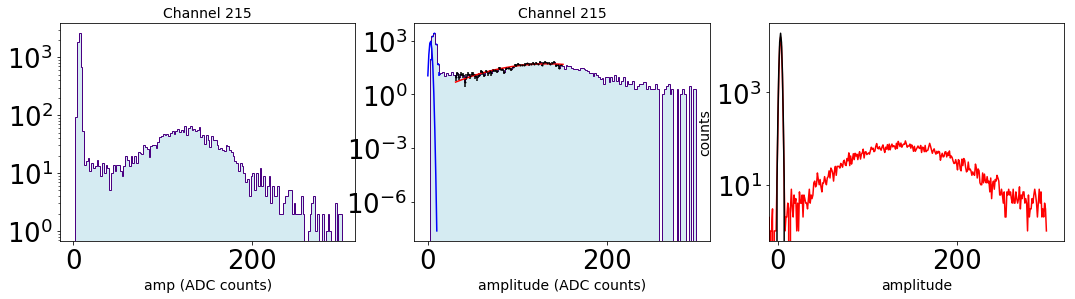

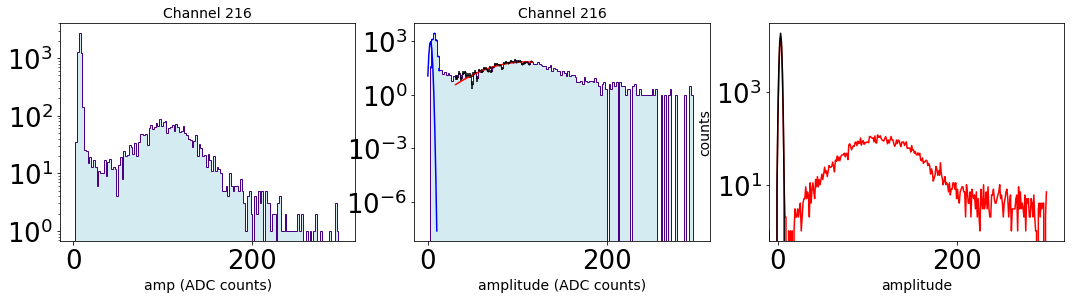

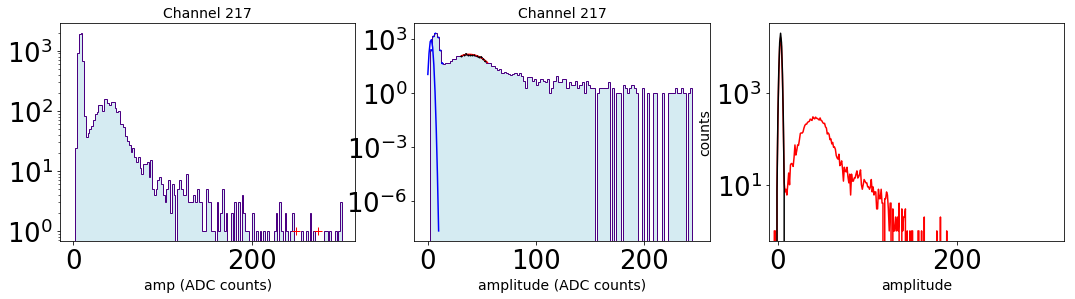

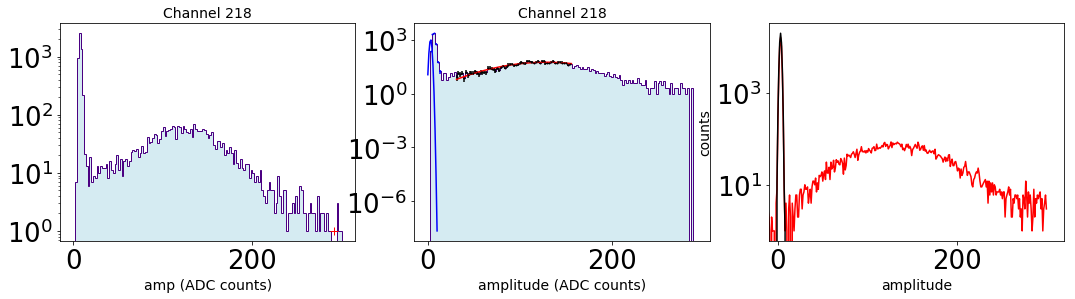

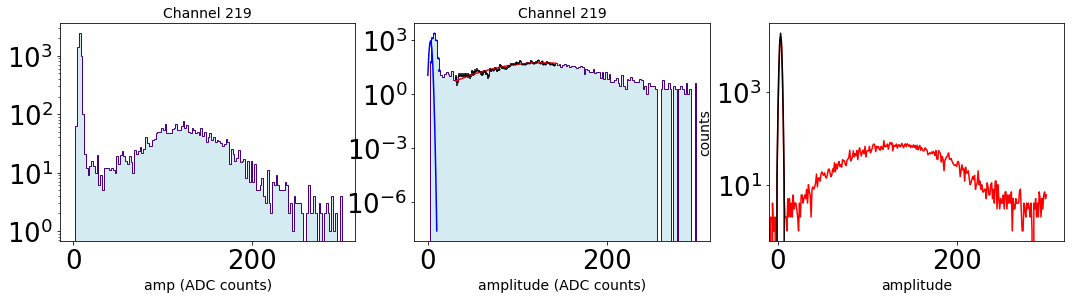

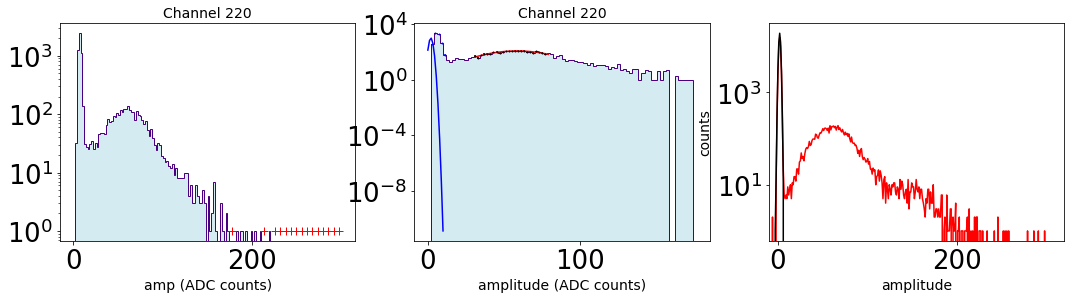

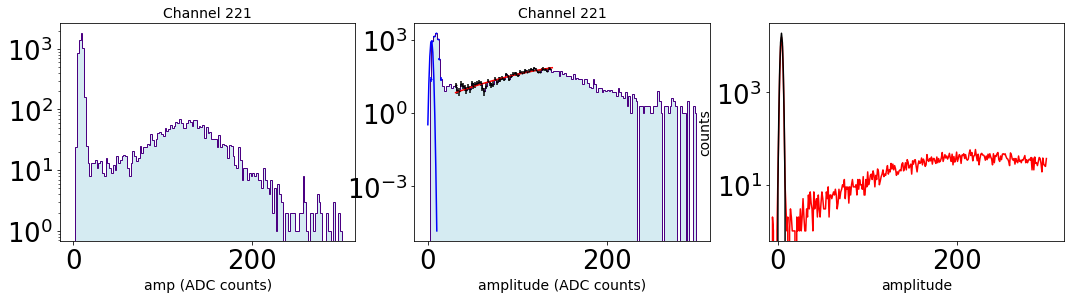

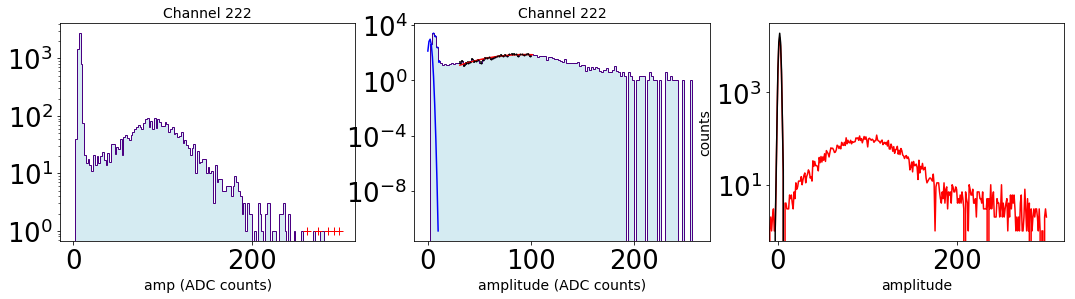

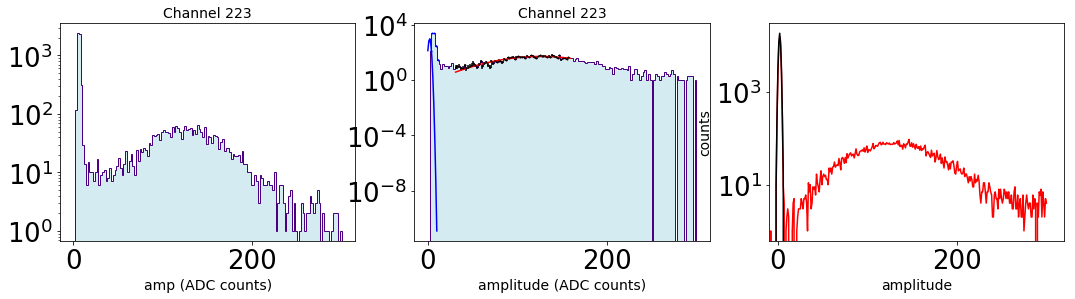

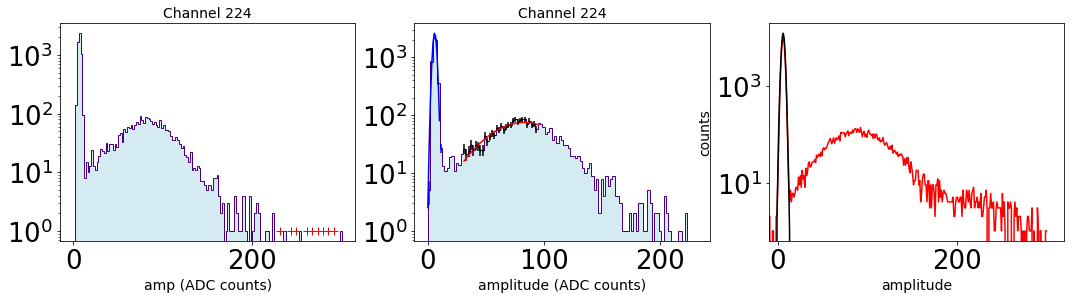

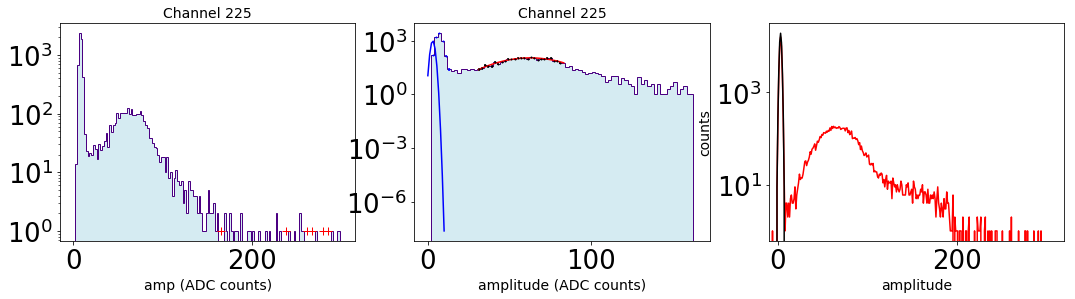

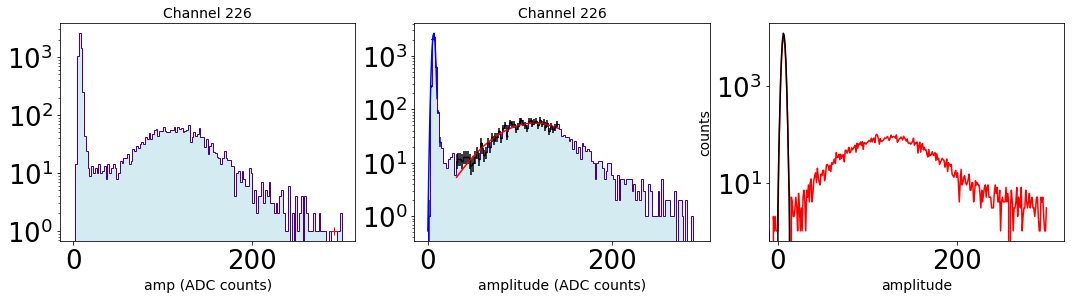

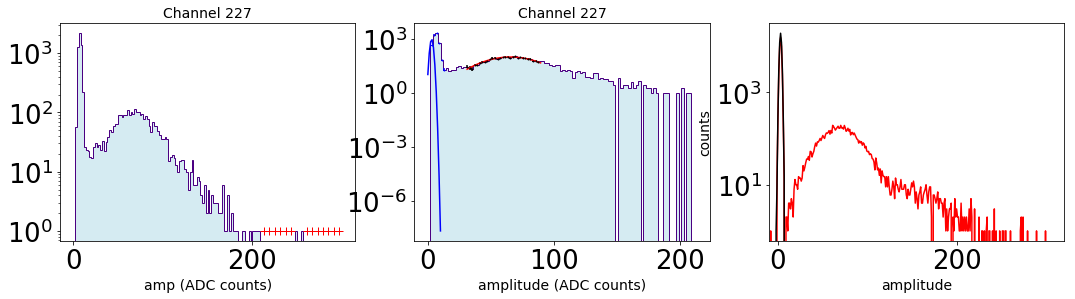

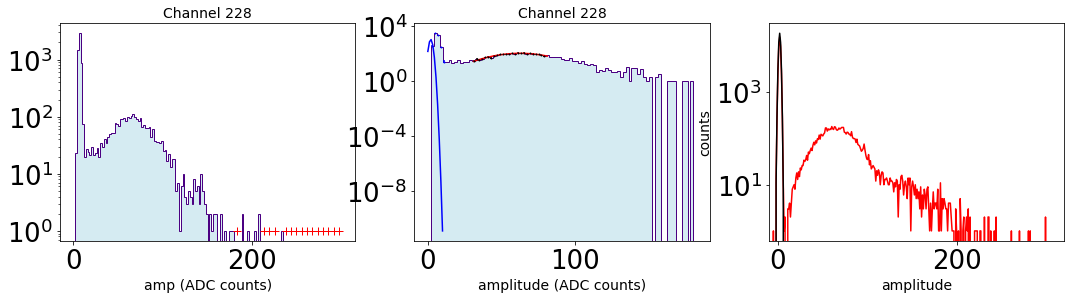

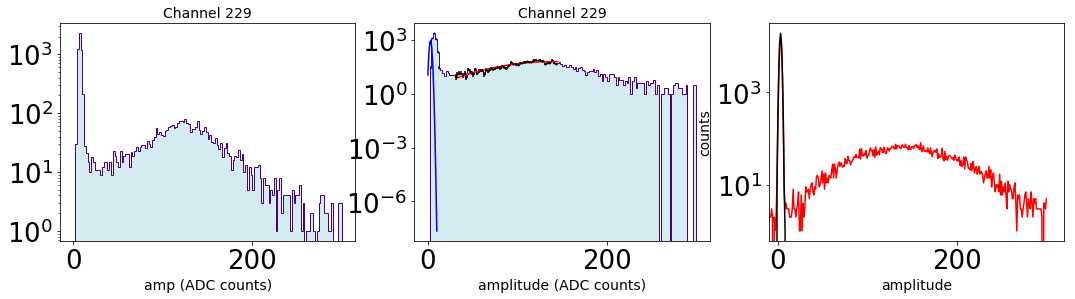

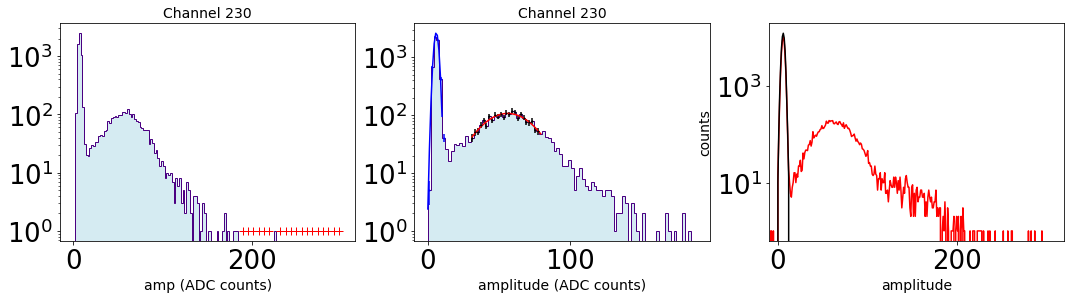

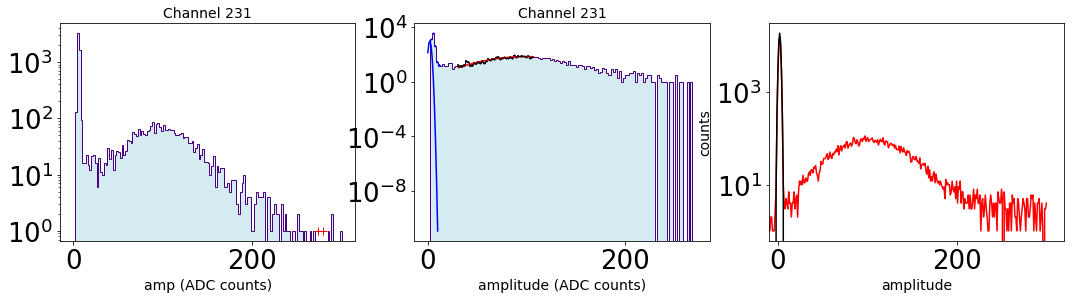

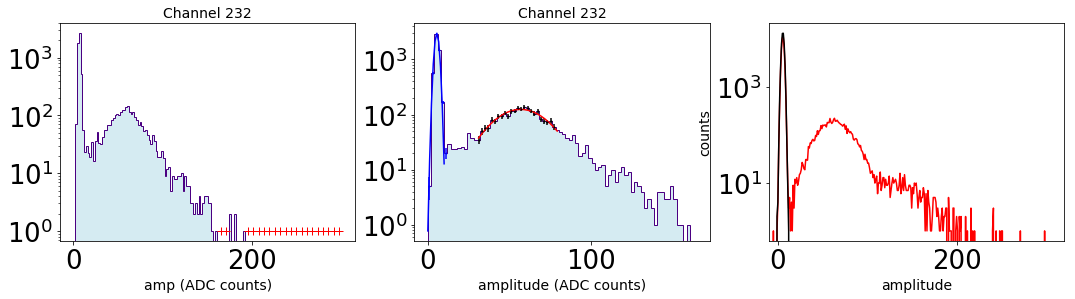

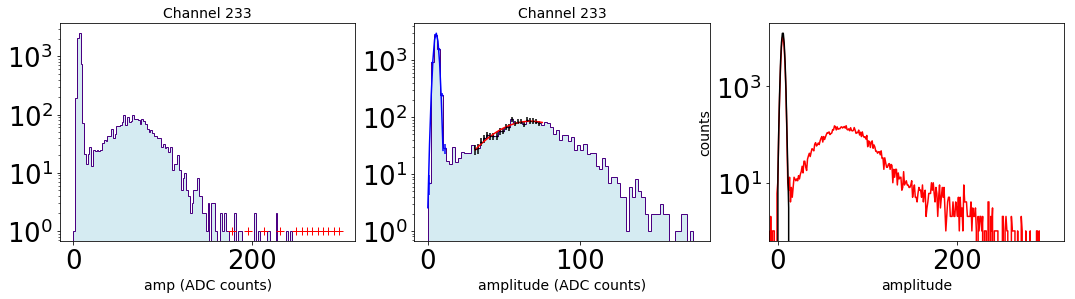

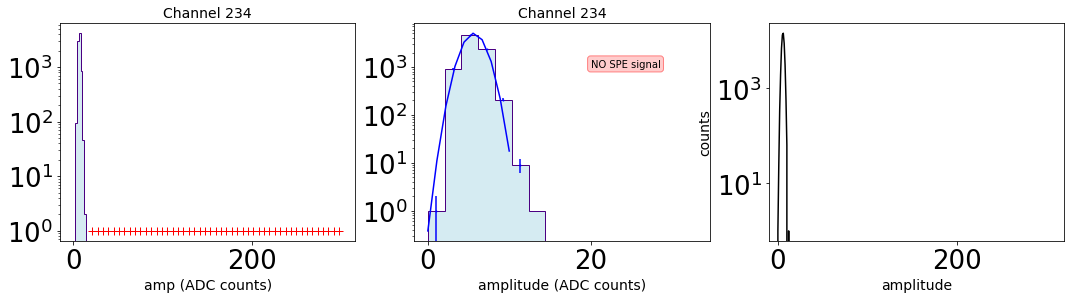

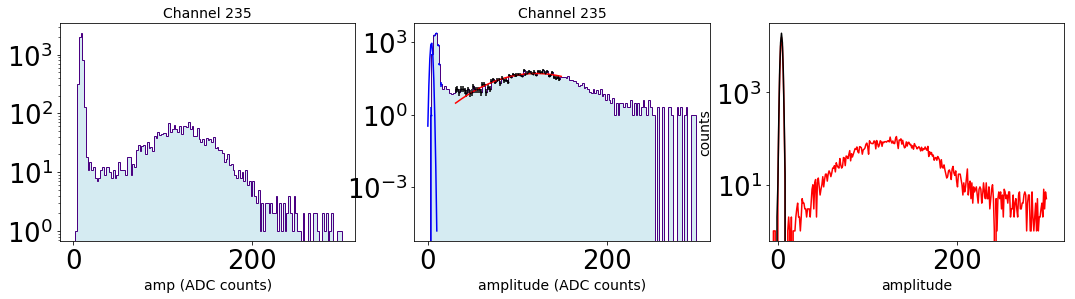

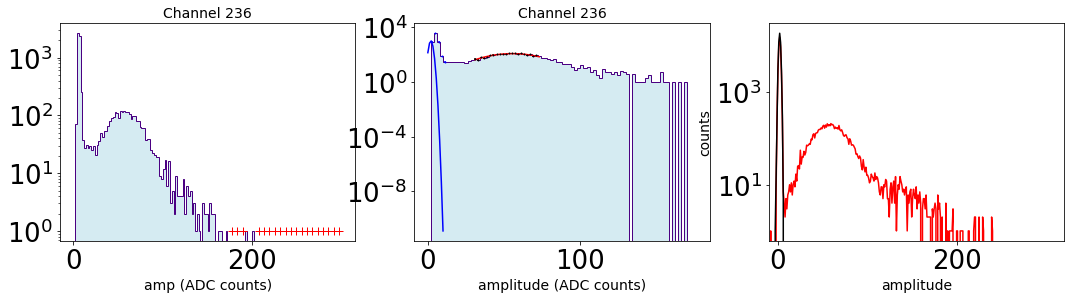

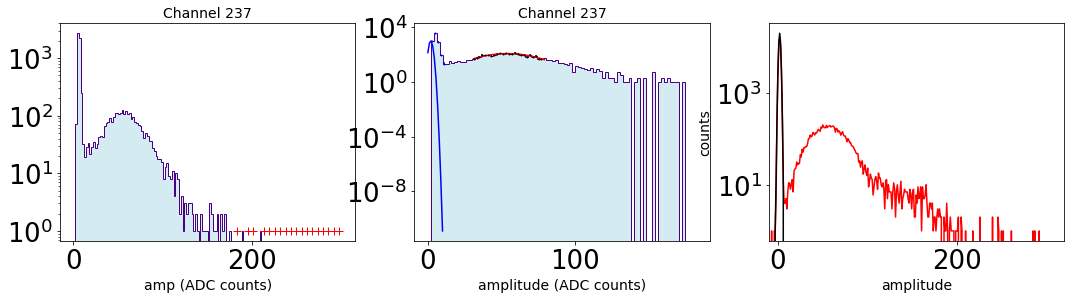

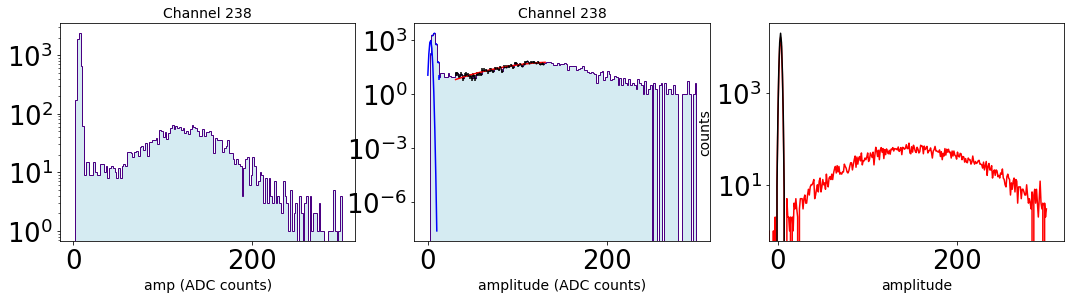

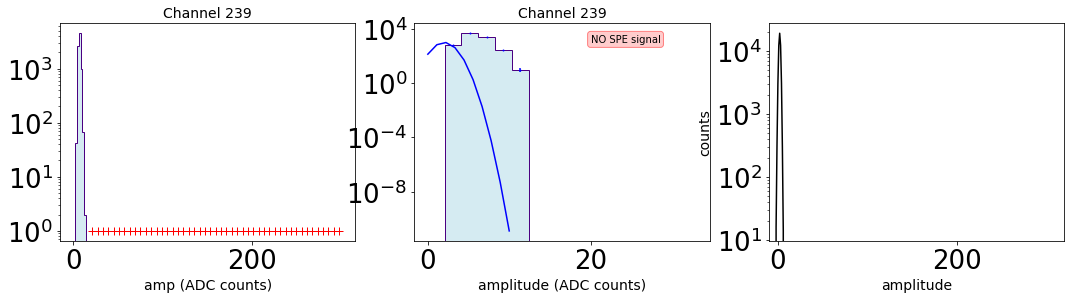

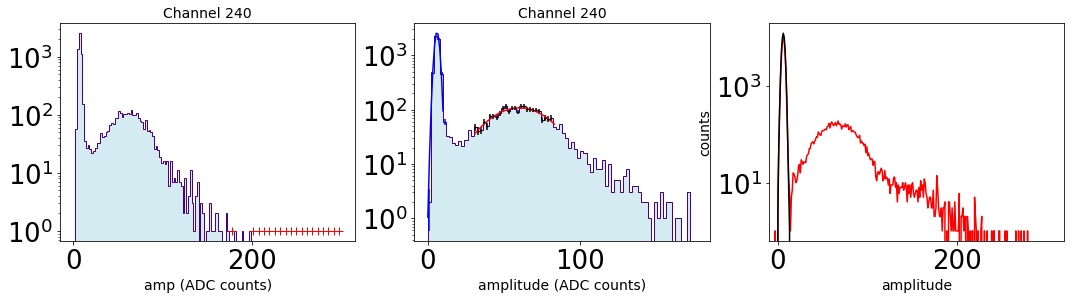

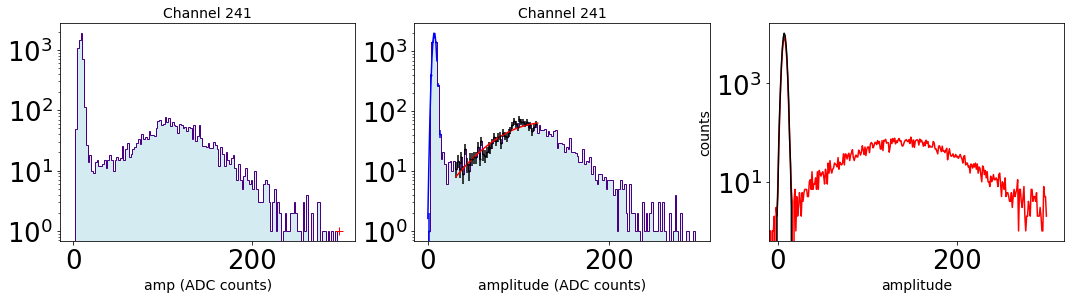

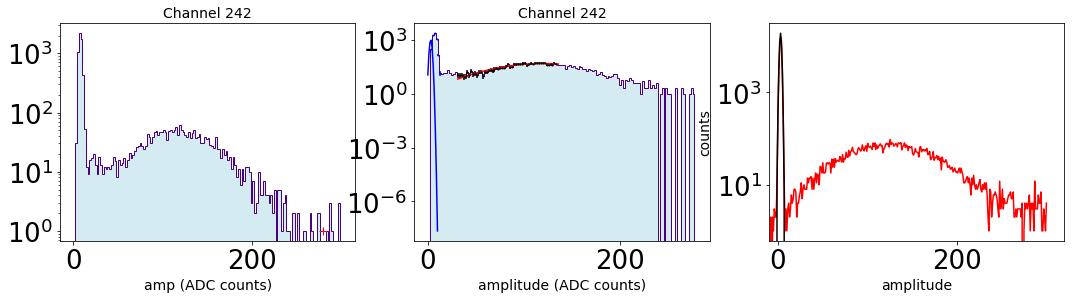

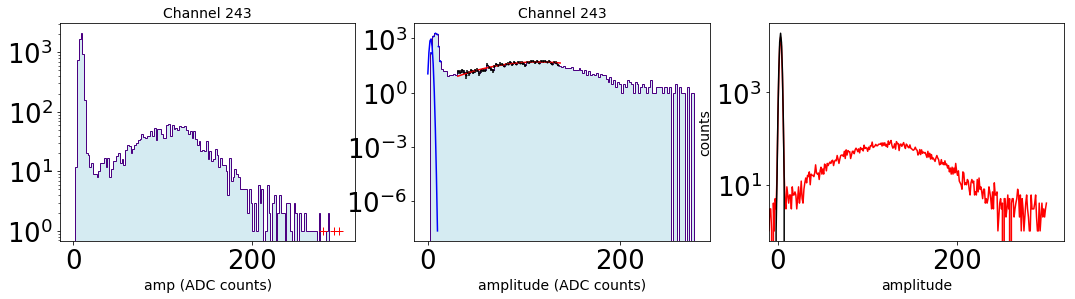

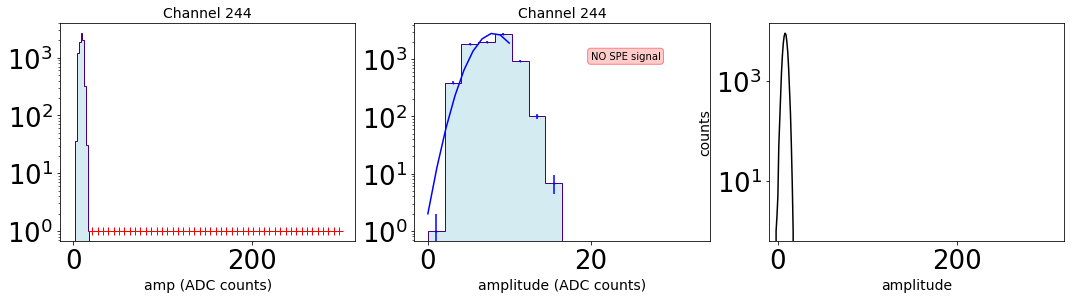

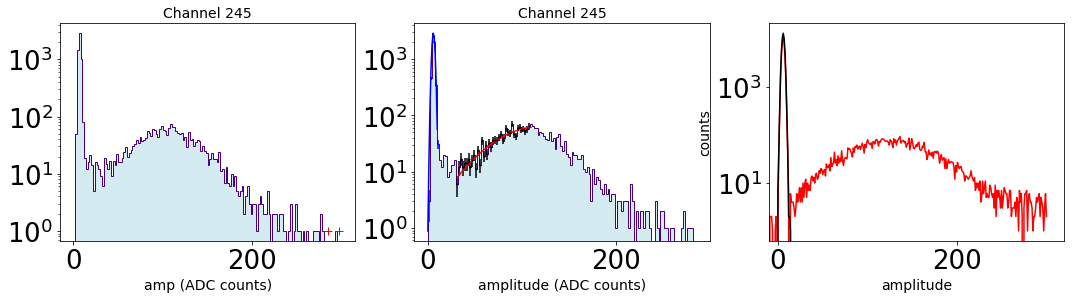

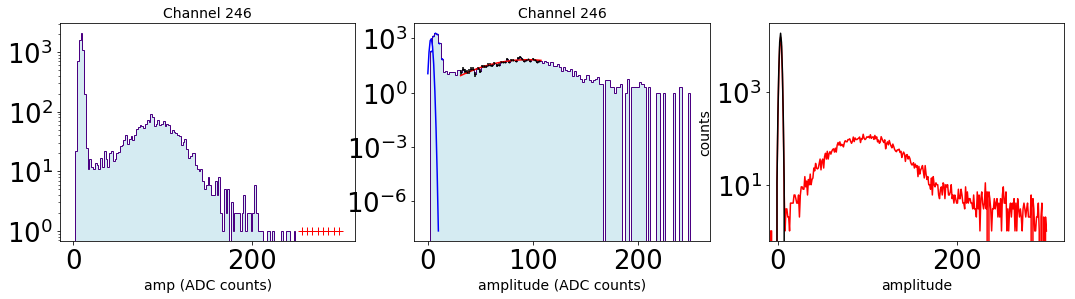

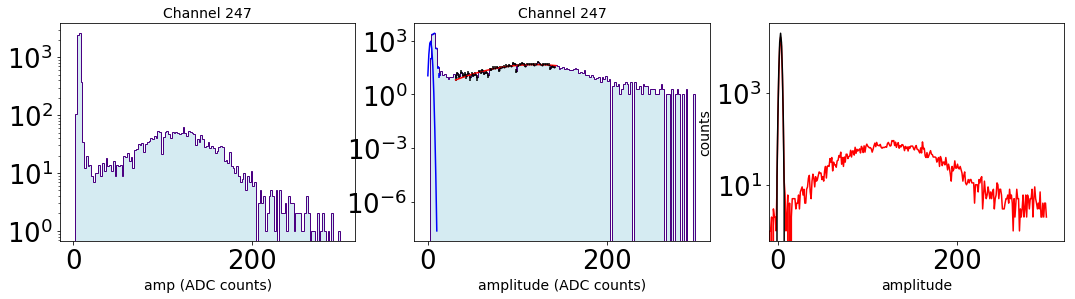

In [17]:
n_channel_s = np.arange(0, 248, 1)
info = {'mean': [ ], 'sig': [ ], 'Norm': [ ], 'pmt': [ ]}
df2 = pd.DataFrame({'channel': [ ], 'idx_LED': [ ]}) 

for n_channel in tqdm(n_channel_s):
    wf = Data[Data['pmt']==n_channel]
    ##################################################################
    # Which binning and range you want for the SPE fit?
    # I am checking the first bin empty and it defines the binning and 
    # the range for the next hist
    ##################################################################
    hist, xbins = np.histogram(wf['Amplitude'], bins=50, range=(0,300))
    xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
    y = hist[np.where(hist<1)]
    x = xbins_center[np.where(hist<1)]

    plt.figure(figsize=(18,4))
    plt.subplot(131)
    #########################################
    # This is just for data visualization
    # (x, y+1) are the point where there are no
    # data in the histogram
    #########################################
    plt.hist(wf['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
    plt.hist(wf['Amplitude'], bins=150, range=(0,300), histtype='step', color='indigo')
    plt.plot(x, y+1, 'r+', ms=8)
    plt.yscale('log')
    plt.title('Channel %d' %n_channel)
    plt.xlabel('amp (ADC counts)')
    ###############################################
    # L'estremo superiore del range è definito
    # come il primo valore con 0 counts dopo 30 ADC
    ###############################################
    idx = x[np.where(x>30)]

    ax = plt.subplot(132)
    if len(idx)==0:
        ax.hist(wf['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
        hist, xbins, _ = ax.hist(wf['Amplitude'], bins=150, range=(0,300), histtype='step', color='indigo')
    else:
        ax.hist(wf['Amplitude'], bins=int(idx[0]/2), range=(0, idx[0]), histtype='bar', color='lightblue', alpha=0.5)
        hist, xbins, _ = ax.hist(wf['Amplitude'], bins=int(idx[0]/2), range=(0, idx[0]), histtype='step', color='indigo')
        
    xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
    #############################
    # ADC del piedistallo
    # usato come input per il fit
    #############################
    idx_0PE_argmax = np.argmax(hist)
    #####################################################
    # temp è usato per trovare il segnale di 1PE
    # da usare come input nel fit. Viene preso il massimo 
    # dopo ~10 ADC
    #####################################################
    temp = hist[(idx_0PE_argmax+4):]
    idx_1PE_argmax = np.argmax(temp) + (idx_0PE_argmax+4)
    ######################
    # Range in cui fittare
    # il segnale di 1PE
    ######################
    low = 15 
    high = idx_1PE_argmax + 10
    if np.max(temp) > 1e1:
        try:
            init_1PE = [100, idx_1PE_argmax, 5]
            ax.errorbar(xbins_center[low:high], hist[low:high], yerr=np.sqrt(hist[low:high]), xerr = 0,
                        fmt='ko', ms=1)
            ###########
            #   FIT
            ###########
            popt_1PE, pcov_1PE = curve_fit(gaus, xbins_center[low:high], hist[low:high], sigma=np.sqrt(hist[low:high]),
                                   p0= init_1PE, maxfev=int(1e6))
            x = np.linspace(xbins_center[low], xbins_center[high], 20)    
            ax.plot(x, gaus(x, *popt_1PE), 'r-', label='Mean: %.1f\nStd: %.1f' %(popt_1PE[1], popt_1PE[2]))
        except:
            ##########
            # NO FIT
            ##########
            popt_1PE = [0,0,0]
            ax.text(20, 1000, s='Fit failed',
                    bbox=dict(boxstyle="round",
                              ec=(1., 0.5, 0.5),
                              fc=(1., 0.8, 0.8),))
    if np.max(temp) < 1e1:
        ##########
        # No 1PE
        ##########
        popt_1PE = [0,0,0]
        ax.text(20, 1000, s='NO SPE signal', 
                bbox=dict(boxstyle="round",
                          ec=(1., 0.5, 0.5),
                          fc=(1., 0.8, 0.8),))
    #######################
    # Per gioco fitto anche
    # il piedistallo
    #######################
    hist_0PE = hist[:(idx_0PE_argmax+4)]
    xbins_center_0PE = xbins_center[:(idx_0PE_argmax+4)]
    try:
        init_0PE = [1000, idx_0PE_argmax, 1]
        ax.errorbar(xbins_center_0PE, hist_0PE, yerr=np.sqrt(hist_0PE), xerr = 0,
                    fmt='bo', ms=1)
        popt_0PE, pcov_0PE = curve_fit(gaus, xbins_center_0PE, hist_0PE, sigma=np.sqrt(hist_0PE),
                                       p0= init_0PE, maxfev=int(1e6))
        x = np.linspace(0, 10, 10)    
        ax.plot(x, gaus(x, *popt_0PE), 'b-', label='Mean: %.1f\nStd: %.1f' %(popt_0PE[1], popt_0PE[2]))
    except:
        popt_0PE = [0,0,0]
        ax.text(20, 100, s='Fit 0PE failed',
                bbox=dict(boxstyle="round",
                          ec=(1., 0.5, 0.5),
                          fc=(1., 0.8, 0.8),))
    ax.set_yscale('log')
    ax.set_ylim(bottom = 0)
    ax.set_title('Channel %d' %n_channel)
    ax.set_xlabel('amplitude (ADC counts)')
    
    ax2 = plt.subplot(133)
    #########################################################
    # N : number of events to simulate
    # occ: lambda, aka occupancy, aka the mean of the poisson
    #########################################################
    N = 50000 
    occ = 0.2 

    noise_mu = popt_0PE[1]
    noise_sigma = np.abs(popt_0PE[2])
    #print('noise: ', noise_mu, noise_sigma)
    #print('par: ', popt_0PE[1], popt_0PE[2])
    LED_mu = popt_1PE[1]
    LED_sigma = np.abs(popt_1PE[2])
    #print('LED: ', LED_mu, LED_sigma)
    #print('par: ', popt_1PE[1], popt_1PE[2])
    
    ##########################################################################################
    # LED signal looks like noise (gaussian) + LED component (gaussian convolved with poisson)
    # noise signal is just the noise part with same mean, sigma
    # noise has mean 0, arbitrary sigma
    # LED has arbitrary mean, sigma. Just played with numbers til it looked about right
    ##########################################################################################
    if (LED_mu > 0):
        LED_vals = (sp.stats.norm.rvs(loc=noise_mu, scale=noise_sigma, size=N) + 
                    sp.stats.norm.rvs(loc=LED_mu, scale=LED_sigma, size=N) * sp.stats.poisson.rvs(occ, size=N))
        LED, bins = np.histogram(LED_vals, bins=400, range=(-100.5, 299.5))
        bins = 0.5 * (bins[1:] + bins[:-1])
        ax2.plot(bins, LED, color='red', label='LED')
    noise_vals = sp.stats.norm.rvs(loc=noise_mu, scale=noise_sigma, size=N)
    noise, bins = np.histogram(noise_vals, bins=400, range=(-100.5, 299.5))
    bins = 0.5 * (bins[1:] + bins[:-1])
    
    ax2.plot(bins, noise, color='black', label='noise')
    ax2.set_xlabel('amplitude')
    ax2.set_ylabel('counts')
    ax2.set_yscale('log')
    ax2.set_ylim(bottom = 0)
    ax2.set_xlim(left = -10)
    
    #plt.show()
    #plt.tight_layout()
    
    N, mean, sig = popt_1PE[0], popt_1PE[1], popt_1PE[2]
    ############################
    # Salvo i parametri in un
    # dizionario. Non si sa mai
    ############################
    info['mean'].append(popt_1PE[1])
    info['sig'].append(popt_1PE[2])
    info['Norm'].append(popt_1PE[0])
    info['pmt'].append(n_channel)

    d_temp = pd.DataFrame({'channel': [ ], 'idx_LED': [ ]})
    #######################################
    # Selezione solo gli eventi che cadono
    # dentro al segnale di 1PE e poi prendo
    # il corrispondente sample time
    #######################################
    
    mask = (wf['Amplitude'] < mean + sig) & (wf['Amplitude'] > mean - sig)
    idx_LED = wf['Sample of Amplitude'][mask]
    
    if len(idx_LED)==0:
        d_temp['channel'] = n_channel
        d_temp['idx_LED'] = np.nan
    else:
        d_temp['idx_LED'] = idx_LED
        d_temp['channel'] = np.ones_like(idx_LED) * n_channel
                    
    df2 = df2.append(d_temp, ignore_index=True)
    del d_temp, idx_LED
                  
mean = df2['idx_LED'].mean()
std = df2['idx_LED'].std()
window = [int(mean-0.5*std),int(mean+0.5*std)]
print('mean: ', mean, 'sigma: ', std, 'window LED: ', window)

In [35]:
def SPErough(data, n_channel_s = np.arange(0, 248, 1)):

    info = {'pmt': [ ], 'noise_mu': [], 'noise_sigma': [], 'noise_norm': [], 'LED_mu': [], 'LED_sigma': [], 'LED_norm': []}
    df2 = pd.DataFrame({'channel': [ ], 'idx_LED': [ ]}) 

    for n_channel in tqdm(n_channel_s):
        wf = data[data['pmt']==n_channel]
        ##################################################################
        # Which binning and range you want for the SPE fit?
        # I am checking the first bin empty and it defines the binning and 
        # the range for the next hist
        ##################################################################
        hist, xbins = np.histogram(wf['Amplitude'], bins=50, range=(0,300))
        xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
        y = hist[np.where(hist<1)]
        x = xbins_center[np.where(hist<1)]

        #########################################
        # This is just for data visualization
        # (x, y+1) are the point where there are no
        # data in the histogram
        #########################################
        ###############################################
        # L'estremo superiore del range è definito
        # come il primo valore con 0 counts dopo 30 ADC
        ###############################################
        idx = x[np.where(x>30)]

        if len(idx)==0:
            hist, xbins, _ = ax.hist(wf['Amplitude'], bins=150, range=(0,300), histtype='step', color='indigo')
        else:
            hist, xbins, _ = ax.hist(wf['Amplitude'], bins=int(idx[0]/2), range=(0, idx[0]), histtype='step', color='indigo')

        xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
        #############################
        # ADC del piedistallo
        # usato come input per il fit
        #############################
        idx_0PE_argmax = np.argmax(hist)
        #####################################################
        # temp è usato per trovare il segnale di 1PE
        # da usare come input nel fit. Viene preso il massimo 
        # dopo ~10 ADC
        #####################################################
        temp = hist[(idx_0PE_argmax+4):]
        idx_1PE_argmax = np.argmax(temp) + (idx_0PE_argmax+4)
        ######################
        # Range in cui fittare
        # il segnale di 1PE
        ######################
        low = 15 
        high = idx_1PE_argmax + 10
        if np.max(temp) > 1e1:
            try:
                init_1PE = [100, idx_1PE_argmax, 5]
                ###########
                #   FIT
                ###########
                popt_1PE, pcov_1PE = curve_fit(gaus, xbins_center[low:high], hist[low:high], sigma=np.sqrt(hist[low:high]),
                                       p0= init_1PE, maxfev=int(1e6))
            except:
                ##########
                # NO FIT
                ##########
                popt_1PE = [0,0,0]

        if np.max(temp) < 1e1:
            ##########
            # No 1PE
            ##########
            popt_1PE = [0,0,0]

        #######################
        # Per gioco fitto anche
        # il piedistallo
        #######################
        hist_0PE = hist[:(idx_0PE_argmax+4)]
        xbins_center_0PE = xbins_center[:(idx_0PE_argmax+4)]
        try:
            init_0PE = [1000, idx_0PE_argmax, 1]
            popt_0PE, pcov_0PE = curve_fit(gaus, xbins_center_0PE, hist_0PE, sigma=np.sqrt(hist_0PE),
                                           p0= init_0PE, maxfev=int(1e6))
        except:
            popt_0PE = [0,0,0]
            
        #########################################################
        # N : number of events to simulate
        # occ: lambda, aka occupancy, aka the mean of the poisson
        #########################################################
        N = 50000 
        occ = 0.2 
        
        noise_norm = popt_0PE[0]
        noise_mu = popt_0PE[1]
        noise_sigma = np.abs(popt_0PE[2])
        LED_norm = popt_1PE[0]
        LED_mu = popt_1PE[1]
        LED_sigma = np.abs(popt_1PE[2])

        ##########################################################################################
        # LED signal looks like noise (gaussian) + LED component (gaussian convolved with poisson)
        # noise signal is just the noise part with same mean, sigma
        # noise has mean 0, arbitrary sigma
        # LED has arbitrary mean, sigma. Just played with numbers til it looked about right
        ##########################################################################################
        if (LED_mu > 0):
            LED_vals = (sp.stats.norm.rvs(loc=noise_mu, scale=noise_sigma, size=N) + 
                        sp.stats.norm.rvs(loc=LED_mu, scale=LED_sigma, size=N) * sp.stats.poisson.rvs(occ, size=N))
            LED, bins = np.histogram(LED_vals, bins=400, range=(-100.5, 299.5))
            bins = 0.5 * (bins[1:] + bins[:-1])
        noise_vals = sp.stats.norm.rvs(loc=noise_mu, scale=noise_sigma, size=N)
        noise, bins = np.histogram(noise_vals, bins=400, range=(-100.5, 299.5))
        bins = 0.5 * (bins[1:] + bins[:-1])

        N, mean, sig = popt_1PE[0], popt_1PE[1], popt_1PE[2]
        ############################
        # Salvo i parametri in un
        # dizionario. Non si sa mai
        ############################

        info['pmt'].append(n_channel)
        info['noise_mu'].append(noise_mu)
        info['noise_sigma'].append(noise_sigma)
        info['noise_norm'].append(noise_norm)
        info['LED_mu'].append(LED_mu)
        info['LED_sigma'].append(LED_sigma)
        info['LED_norm'].append(LED_norm)

        d_temp = pd.DataFrame({'channel': [ ], 'idx_LED': [ ]})
        #######################################
        # Selezione solo gli eventi che cadono
        # dentro al segnale di 1PE e poi prendo
        # il corrispondente sample time
        #######################################

        mask = (wf['Amplitude'] < mean + sig) & (wf['Amplitude'] > mean - sig)
        idx_LED = wf['Sample of Amplitude'][mask]

        if len(idx_LED)==0:
            d_temp['channel'] = n_channel
            d_temp['idx_LED'] = np.nan
        else:
            d_temp['idx_LED'] = idx_LED
            d_temp['channel'] = np.ones_like(idx_LED) * n_channel

        df2 = df2.append(d_temp, ignore_index=True)
        del d_temp, idx_LED

    mean = df2['idx_LED'].mean()
    std = df2['idx_LED'].std()
    window = [int(mean-0.5*std),int(mean+0.5*std)]
    #print('mean: ', mean, 'sigma: ', std, 'window LED: ', window)
    return window, info, df2

In [36]:
window, info, df2 = SPErough(data = Data)

100%|██████████| 248/248 [00:09<00:00, 25.46it/s]


In [42]:
window

[137, 188]

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


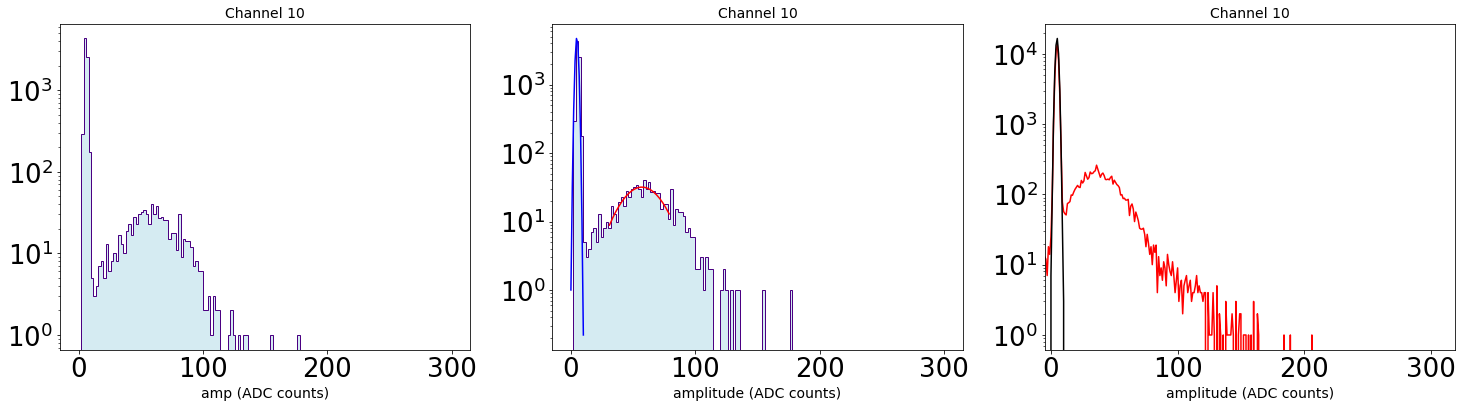

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(25,6))
n_channel = 10

plt.subplot(131)
plt.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
plt.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='step', color='indigo')
plt.yscale('log')
plt.title('Channel %d' %n_channel)
plt.xlabel('amp (ADC counts)')

ax = plt.subplot(132)
ax.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
hist, xbins, _ = ax.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, 
                         range=(0,300), histtype='step', color='indigo')

xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
idx_0PE_argmax = np.argmax(hist)
temp = hist[(idx_0PE_argmax+4):]
idx_1PE_argmax = np.argmax(temp) + (idx_0PE_argmax+4)

low = 15 
high = idx_1PE_argmax + 10
x = np.linspace(xbins_center[low], xbins_center[high], 20) 
ax.plot(x, gaus(x, info['LED_norm'][n_channel], info['LED_mu'][n_channel], info['LED_sigma'][n_channel]), 'r-')

x = np.linspace(0, 10, 10)  
ax.plot(x, gaus(x, info['noise_norm'][n_channel], info['noise_mu'][n_channel], info['noise_sigma'][n_channel]), 'b-')

ax.set_yscale('log')
ax.set_ylim(bottom = 0)
ax.set_title('Channel %d' %n_channel)
ax.set_xlabel('amplitude (ADC counts)')

ax2 = plt.subplot(133)
N = 50000 
occ = 0.2 
if (info['LED_mu'][n_channel] > 0):
    LED_vals = (sp.stats.norm.rvs(loc=info['noise_mu'][n_channel], scale=info['noise_sigma'][n_channel], size=N) + 
                sp.stats.norm.rvs(loc=info['LED_norm'][n_channel], scale=info['LED_sigma'][n_channel], size=N) * sp.stats.poisson.rvs(occ, size=N))
    LED, bins = np.histogram(LED_vals, bins=400, range=(-100.5, 299.5))
    bins = 0.5 * (bins[1:] + bins[:-1])
    ax2.plot(bins, LED, color='red', label='LED')
    
noise_vals = sp.stats.norm.rvs(loc=info['noise_mu'][n_channel], scale=info['noise_sigma'][n_channel], size=N)
noise, bins = np.histogram(noise_vals, bins=400, range=(-100.5, 299.5))
bins = 0.5 * (bins[1:] + bins[:-1])

ax2.plot(bins, noise, color='black', label='noise')
ax2.set_title('Channel %d' %n_channel)
ax2.set_xlabel('amplitude (ADC counts)')
ax2.set_yscale('log')
ax2.set_ylim(bottom = 0)
ax2.set_xlim(left = -5)

plt.show()
plt.tight_layout()

mean:  162.95775 	 standard deviation:  50.318783


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


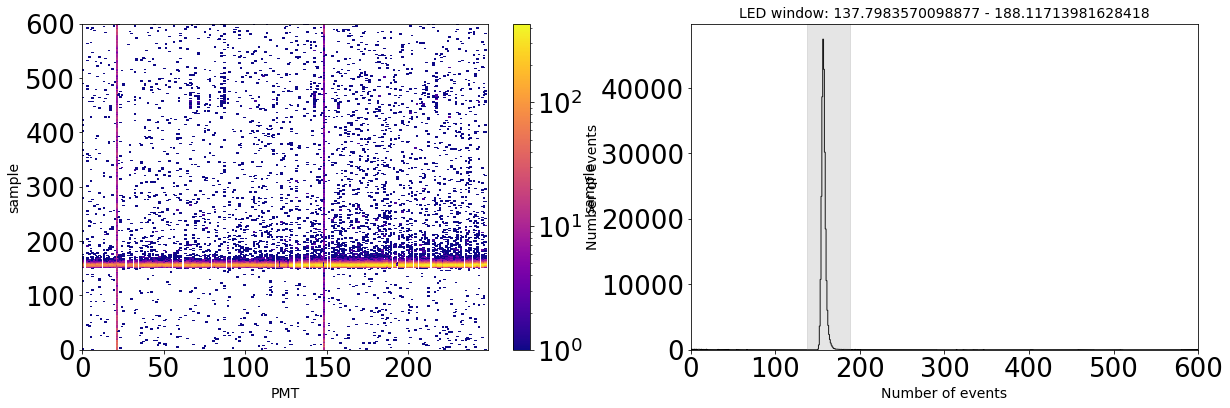

<Figure size 432x288 with 0 Axes>

In [22]:
fig = plt.figure(figsize=(20,6))

######################################################################################################
plt.subplot(121)
hist2d, xbins, ybins, _ = plt.hist2d(x = df2['channel'], y = df2['idx_LED'], 
                                     bins=(249,600), range=((0,249),(0,600)), 
                                     cmap=plt.cm.plasma, norm=mpl.colors.LogNorm(), cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('PMT')
plt.ylabel('sample')
######################################################################################################

######################################################################################################
plt.subplot(122)
y_hist, y_bins, _ = plt.hist(df2['idx_LED'], bins=600, range=(0,600), histtype='step', color='black')
#plt.yscale('log')
plt.xlim(0,600)
mean = df2['idx_LED'].mean()
std = df2['idx_LED'].std()
window = [int(mean-0.5*std),int(mean+0.5*std)]
print('mean: ',mean,'\t standard deviation: ', std)
plt.axvspan(*window, color='grey', alpha=0.2)
plt.title('LED window: '+str(mean-0.5*std)+' - '+str(mean+0.5*std))
plt.xlabel('Number of events')
plt.ylabel('sample')
######################################################################################################

plt.show()
plt.tight_layout()

In [ ]:
#%matplotlib notebook
fig = plt.figure(figsize=(8,6))

y_bins_center = 0.5 * (y_bins[1:] + y_bins[:-1])

plt.plot(y_bins_center, y_hist, 'r--') 
#plt.ylim(bottom = 0, top=500)